# 总体思路

![](https://ai-studio-static-online.cdn.bcebos.com/374e805058c74317829f2ea818731f456ad4bfdc79fb40349cf1e2cd5004a54a)


# 训练总结

1. Rdrop似乎并不能提交训练效果，添加后dev acc看起来提高，但test acc却下降
2. 重新划分数据集能够达到更好的效果，尝试9:1、8:2、7:3 其中8:2效果最好
3. 在继续训练时调低学习率可以有所提高，但有达到一定程度后，仅有最开始一个evaluation 提高了dev acc，紧接着很长时见的dev acc下降
4. 可以打印dev acc的趋势图来判断dev acc走势，判断更优点可能存在的位置
5. Batch Size 大时，可以大概预判该组参数的大致结果，若不错则调低Batch Size寻找更优点
6. 通过同音字的纠正可以提高mispelling那一组的准确度（+7%左右）
7. ernie-gram-zh 效果优于 ernie-1.0、bert-base-chinese、bert-wwm-ext-chinese、roberta-wwm-ext、 ernie-2.0-en（翻译所有句子后放入）
8. "ernie-2.0-EN" en版不适用于中文，但dev acc和test a acc差距只有0.3，有时间可以探索
9. 投票却降低了test acc
10. 单独训练Oppo数据集，能够在 Conversational Semantics 和 Lexical Semantics 两点傻上达到很好效果 但 Syntactic Structure、Misspelling、Speech Filter却下降厉害
11. 在OPPO数据集中加入BQ和LCQMC相关与 SS/MS/SF的部分进行训练会提升一定的效果
12. 可以尝试让两个模型 （ALL 和 OPPO）分别预测 SS/MS/SF 和 CS/LS，但未成功
13. Jieba分词很有趣，但会分错
14. lazypinyin/pycorrector/bihua组合可以将misspelling提升到最高（翘舌平舌几乎没有影响）

# 第一部分：数据预处理 （耗时约0.5小时）

## 1.1 数据读写分割方法


### 1.1.1 字符串处理与对比方法

In [1]:
#获取仅有一个subset不同的两个字符串

#方法1-1，从左往右对比两个句子对，直到出现不同的字符，返回相同字数的个数
# text_1 = "成龙姓什么叫什么"
# text_2 = "成龙姓什么"
# 返回 5
def check_same_words_forward(text_1,text_2):
    i = 0
    if len(text_1) < len(text_2):
        while i < len(text_1):
            if text_1[i] == text_2[i]:
                i = i + 1
            else:
                return i 
        return i  
        # 返回从左往右数的相同字数个数
    else:
        while i < len(text_2):
            if text_2[i] == text_1[i]:
                i = i + 1
            else:
                return i
        return i 
        # 返回从左往右数的相同字数个数

#方法1-2，从右往左对比两个句子对，直到出现不同的字符，返回相同字数的个数
# text_1 = "成龙姓什么叫什么"
# text_2 = "成龙姓什么"
# 返回 2
def check_same_words_backward(text_1,text_2):
    count = 0
    i = len(text_1)-1
    j = len(text_2)-1
    while i >= 0 and j>= 0:
        if text_1[i] == text_2[j]:
            i = i - 1
            j = j - 1
            count = count + 1
        else:
            return count 
    return count 
    # 返回从右往左数的相同字数个数

#方法1-3，对比两个抽取出的两串字符，如果一个不包含另一个的任何字符，代表它们完全不同，返回True，否则则是多个subset的情况返回False
# text_1 = "茶叶能减肥吗？"
# text_2 = "茶叶可以减肥吗"
# sub_text_1 => "能" sub_text_2=> "可以"
# 返回True
# text_1 = "茶叶能不能减肥吗？"
# text_2 = "茶叶可不可以减肥吗"
# sub_text_1 => "能不能" sub_text_2=> "可不可以"
# 返回False
def compare_subset(sub_text_1, sub_text_2):
    if len(sub_text_1)<= len(sub_text_2):
        for x in sub_text_1:
            if x in sub_text_2:
                return False
        return True
    else:
        for x in sub_text_2:
            if x in sub_text_1:
                return False
        return True

#方法1-4，对句子对进行分类、抽取和对比，若属于分类（i）（ii）（iii）则返抽取出的字符串对，若不属于则返回“Not_The_Case”
def check_subset(text_1, text_2):
    #从左往右，若句子对的最左边字符相同的情况
    if text_1[0]== text_2[0]:
        #从右往左，从右往左寻找不同的字符串
        # 调用方法一，从左往右分析，返回相同字数个数
        index = check_same_words_forward(text_1, text_2)
        # 调用方法三，对比抽取出的字符串，判断二者是否包含同样的字符
        is_case_2 = compare_subset(text_1[index:],text_2[index:] )
        if is_case_2:  
            return text_1[index:], text_2[index:]
        #从右往左，若句子对的最右边字符相同的情况，开始寻找中间不同的部分
        if text_1[-1] == text_2[-1]:
            # 调用方法一，从左往右分析，返回相同字数个数
            index_forward = check_same_words_forward(text_1, text_2)
            # 调用方法二，从右往左分析，返回相同字数个数
            index_backward = check_same_words_backward(text_1, text_2)
            # 若相同index_forward和index_backward相同，且句子对长度相同，则返回“”，代表这两个句子去除标点符号后完全一致
            if index_forward == index_backward and index_forward == len(text_1) and index_forward == len(text_2):
                return "", ""
            # 若不同字符数之和小于句子对中最短的句子
            elif (index_forward + index_backward) <= min(len(text_1),len(text_2)):
                # 调用方法三，对比抽取出的字符串，判断二者是否包含同样的字符
                is_class_4 = compare_subset(text_1[index_forward:len(text_1) - index_backward],text_2[index_forward:len(text_2) - index_backward] )
                if is_class_4:
                    return text_1[index_forward:len(text_1) - index_backward], text_2[index_forward:len(text_2) - index_backward]
                    # 返回头尾相同，中间完全不同的字符串
            # 若不同字符数之和大于句子对中最短句子，则代表有重叠的部分
            else:
                # 计算出重叠的字符数
                overlap = (index_forward + index_backward) - min(len(text_1),len(text_2))
                # 这里讲长句进行划分先从左往右找出相同，再从右往左找出相同，返回中间的不同
                if len(text_1) > len(text_2):
                    return text_1[index_forward:len(text_1) - (index_backward - overlap)],""
                else:
                    return "",text_2[index_forward:len(text_2) - (index_backward - overlap)]
        #从右往左，若句子对的最右边字符不相同的情况，则从右往左寻找不同的字符串
        elif text_1[-1] != text_2[-1]:
            # 调用方法一，从左往右分析，返回相同字数个数
            index = check_same_words_forward(text_1, text_2)
            # 调用方法三，对比抽取出的字符串，判断二者是否包含同样的字符
            is_case_2 = compare_subset(text_1[index:],text_2[index:] )
            if is_case_2:  
                return text_1[index:], text_2[index:]
    #从左往右，若句子对的最左边字符不相同的情况
    else:
        #从右往左，若句子对的最右边字符相同的情况，则从右往左寻找不同的字符串
        if text_1[-1]== text_2[-1]:
            # 调用方法二，从右往左分析，返回相同字数个数
            index = check_same_words_backward(text_1, text_2)
            # 调用方法三，对比抽取出的字符串，判断二者是否包含同样的字符
            is_case_3 = compare_subset(text_1[0:len(text_1) - index],text_2[0:len(text_2) - index] )
            if is_case_3:  
                return text_1[0:len(text_1) - index], text_2[0:len(text_2) - index]
    #其他情况返回"Not_The_Case"
    #print(text_1 + "    " + text_2)
    return "Not_The_Case", "Not_The_Case"


### 1.1.2 从数据集中读取句子对和标签的方法

In [2]:
# 方法1-1，从训练集读句子对和标签
def read_candidates_train(data_path):
    data_list_1 = []
    data_list_2 = []
    label_list = []
    with open(data_path, 'r', encoding='utf-8') as f:
        for line in f:
            value = line.rstrip().split("\t")
            data_list_1.append(value[0])
            data_list_2.append(value[1])
            label_list.append(value[2])
        print("\nThe number of lines in " + data_path+ " is " + str(len(data_list_1)))
    return data_list_1, data_list_2, label_list

# 方法1-2，从测试集合读读句子对
def read_candidates_test(data_path):
    data_list_1 = []
    data_list_2 = []
    with open(data_path, 'r', encoding='utf-8') as f:
        for line in f:
            value = line.rstrip().split("\t")
            data_list_1.append(value[0])
            data_list_2.append(value[1])
        print("\nThe number of lines in " + data_path+ " is " + str(len(data_list_1)))
    return data_list_1, data_list_2

# 方法1-3，从预测中读预测结果(千言鲁棒性比赛)
def read_labels(data_path):
    labels = []
    with open(data_path, 'r', encoding='utf-8') as f:
        for line in f:
            value = line.rstrip().split("\t")
            labels.append(value[0]) #value[0]是预测标签
        print("\nThe number of predict result lines in " + data_path + " is " + str(len(labels)))
    return labels

# 方法1-4，从训练集读数据，以行的形式
def read_candidates_line(data_path, is_print = False):
    data_line_list = []
    with open(data_path, 'r', encoding='utf-8') as f:
        for line in f:
            data_line_list.append(line[:-1])
        if is_print:
            print("\nThe number of lines in " + data_path+ " is " + str(len(data_line_list)))
    return data_line_list

# 方法1-5 从指定list中打印一定量的结果以供观察
def print_examples(text_pair_list, subset_list = None, label_list = None, number = 20):
    for i in range (0,len(text_pair_list)):
        print("句子对: " + text_pair_list[i])
        if subset_list!= None:
            print("子串: " + subset_list[i])
        if label_list!= None:
            print("标签: " + label_list[i])
        if i == number:
            break

# 方法1-6 统计0/1标签
def summarize_one_zero(text_pair_list, label_list):
    zero_list = []
    one_list = []
    for i in range (0, len(label_list)):
        if label_list[i][-1] == '1':
            one_list.append(text_pair_list[i] + "\t" + label_list[i] )
        else:
            zero_list.append(text_pair_list[i] + "\t" + label_list[i] )
    return zero_list, one_list

# 方法1-7 把校正后的结果写入文件
def write_file(file_path, results):
    with open(file_path, 'w', encoding="utf-8") as f:
        for label in results:
            f.write(str(label) + "\n")

# 方法1-8 打印包含指定字符的句子对
def print_dataset(text_pairs_list, label_list, example_numbers = -1):
    zero_s_list, one_s_list = summarize_one_zero(text_pairs_list,label_list)
    print("="*15 + "     统计    " + "="*15)
    if len(text_pairs_list) != 0:
        print("one in text_pairs_list accounts for %.2f" %(len(one_s_list)/len(text_pairs_list)*100))
        print("zero in text_pairs_list accounts for %.2f" %(len(zero_s_list)/len(text_pairs_list)*100))
    print("="*15 + "     相同    " + "="*15)
    print(len(one_s_list))
    if example_numbers == -1:
        print_examples(one_s_list, None, None, len(one_s_list))
    else: 
        print_examples(one_s_list, None, None, example_numbers)
    print("="*15 + "     不同    " + "="*15)
    print(len(zero_s_list))
    if example_numbers == -1:
        print_examples(zero_s_list, None, None, len(zero_s_list))
    else: 
         print_examples(zero_s_list, None, None, example_numbers)

# 方法 1-9 用jieba分词和获取词性
import paddle
import jieba
import jieba.posseg as pseg

paddle.enable_static() #启动Paddle静态图
jieba.enable_paddle() #启动Paddle的jieba模式

def get_words_and_words_nature(text):
    words_nature_list = []
    words_list = []
    words = pseg.cut(text, use_paddle=True)
    for w in words:
        words_list.append(w.word)
        words_nature_list.append(w.flag)
    return words_list, words_nature_list

# 方法1-10 对比两个列表中的句子对是否一致
def identify_different_text_pairs(text_pairs_list_1, text_pairs_list_2):
    different_text_pairs_list = []
    same_text_pairs_list = []
    for text_pair in text_pairs_list_1:
        if text_pair in text_pairs_list_2:
            same_text_pairs_list.append(text_pair)
        else:
            different_text_pairs_list.append(text_pair)
    return different_text_pairs_list, same_text_pairs_list

# 方法1-11 去掉
import re
def remove_symbol(text_original):
    punctuations = '''！!（）()【】[]「」{}；;：:，,。、？?@#$%^&_~'''
    text_without_symbol = ""
    for char in text_original:
        if char not in punctuations:
            text_without_symbol = text_without_symbol + char
    if text_without_symbol[-1] == ".":
        text_without_symbol = text_without_symbol[:-1]
    return text_without_symbol

# 方法1-12 组成（word，nature）形式
def merge_word_nature(words,natures):
    words_natures = [["" for i in range(2)] for j in range(len(words))]
    for i in range(0, len(words)):
        words_natures[i][0] = words[i]
        words_natures[i][1] = natures[i]
    return words_natures

# 获取反义词表
def get_antonym_list():
    antonym_lines = read_candidates_line("common_data/dict_antonym.txt")
    antonym_list = []
    for line in antonym_lines:
        value = line.rstrip().split("\\t")
        antonym_list.append((value[0],value[1]))
    return antonym_list

# 查询是否是反义词
def check_antonym(d_1,d_2):
    antonym_list = read_candidates_line("common_data/dict_antonym.txt")
    line_1 = d_1 + "\\t" + d_2
    line_2 = d_2 + "\\t" + d_1
    if line_1 in antonym_list:
        # print(line)
        return True
    elif line_2 in antonym_list:
        return True
    else:
        return False

# 获取指定列表的标签
def get_labels_by_list(text_pair_1_list, text_pair_2_list, test_a_list, label_list):
    text_pair_candidate_list = []
    label_candidate_list = []
    for i in range (0, len(text_pair_1_list)):
        text_pair_candidate_list.append(text_pair_1_list[i] + "\t" + text_pair_2_list[i])
    
    for j in range (0, len(test_a_list)):
        if test_a_list[j] in text_pair_candidate_list:
            label_candidate_list.append(str(j) + "\t" + str(label_list[j]))
    
    return label_candidate_list


Paddle enabled successfully......


 ## 1.2 构建全称/缩写/错误的字典

In [3]:
# 用缩写代替全称
def replace_long_by_short(text_1, text_2, full_short_list):
    # 获取全称与缩写的字典，并存入 fullnames 和 shortnames 中
    fullnames = []
    shortnames = []
    for full_short in full_short_list:
        value = full_short.rstrip().split("\t")
        fullnames.append(value[0])
        shortnames.append(value[1])

    for x in range (0, len(fullnames)):
        if (fullnames[x] in text_1): 
            text_1 = text_1.replace(fullnames[x],shortnames[x])
        if (fullnames[x] in text_2):
            text_2 = text_2.replace(fullnames[x],shortnames[x])
    return text_1, text_2

# 纠正oppo类拼写错误
def replace_error_by_correct(text_1, text_2, errors_corrects_list):
    # 获取错误与正确的字典，并存入 errors 和 corrects 中
    errors = []
    corrects = []
    for e_c in errors_corrects_list:
        value = e_c.rstrip().split("\t")
        errors.append(value[0])
        corrects.append(value[1])

    for x in range (0, len(errors)):
        if len(errors[x]) > len(corrects[x]):
            if (errors[x] in text_1): 
                text_1 = text_1.replace(errors[x],corrects[x])
            if (errors[x] in text_2):
                text_2 = text_2.replace(errors[x],corrects[x])
        else:
            if (errors[x] in text_1 and corrects[x] not in text_1): 
                text_1 = text_1.replace(errors[x],corrects[x])
            if (errors[x] in text_2 and corrects[x] not in text_2):
                text_2 = text_2.replace(errors[x],corrects[x])
    return text_1, text_2

In [4]:
# 处理省会、城市、镇村区的缩写与全称
# 去除 地名后的"省","市","盟","地区","壮族自治区","维吾尔自治区","特别行政区","林区","自治区"等
def collect_full_shot_provience_city_town(location):
    p_c_t = [
        "拉祜族佤族布朗族傣族自治县","保安族东乡族撒拉族自治县","彝族哈尼族拉祜族自治县","傣族拉祜族佤族自治县","哈尼族彝族傣族自治县",
        "哈尼族彝族傣族自治县","苗族瑶族傣族自治县","彝族回族苗族自治县","满族蒙古族自治县","土家族苗族自治州","哈尼族彝族自治县",
        "布依族苗族自治州","蒙古族藏族自治州","哈尼族彝族自治州","傣族景颇族自治州","土家族苗族自治县","白族普米族自治县",
        "苗族土家族自治县","布依族苗族自治县","土家族苗族自治县","苗族布依族自治县","仡佬族苗族自治县","哈尼族彝族自治县",
        "独龙族怒族自治县","壮族苗族自治州","苗族侗族自治州","黎族苗族自治县","壮族瑶族自治县","藏族羌族自治州",
        "苗族侗族自治县","回族苗族自治县","彝族傣族自治县","彝族傣族自治县","彝族苗族自治县","傣族佤族自治县","柯尔克孜自治州",
        "苗族彝族自治县","回族彝族自治县","回族土族自治县","彝族回族自治县","族撒拉族自治县","哈萨克族自治县","哈萨克自治州",
        "拉祜族自治县","纳西族自治县","哈尼族自治县","傈僳族自治县","哈萨克自治县","仫佬族自治县","毛南族自治县",
        "傈僳族自治州","朝鲜族自治县","朝鲜族自治州","蒙古族自治县","撒拉族自治县","土家族自治县","维吾尔自治区",
        "各族自治县","佤族自治县","回族自治县","土族自治县","彝族自治县","锡伯自治县","水族自治县","怒族自治县","羌族自治县",
        "藏族自治县","彝族自治县","苗族自治县","侗族自治县","瑶族自治县","满族自治县","回族自治县","蒙古自治州","白族自治州",
        "固族自治县","瑶族自治县","傣族自治州","苗族自治县","藏族自治州","畲族自治县","彝族自治州","回族自治州","壮族自治区",
        "黎族自治县","锡伯自治县","特别行政区","地区","自治区","自治县","省","市","盟","县","区","镇","乡","村"]
    special_location = ["神农架林区"]
    for x in p_c_t:
        if location == "神农架林区":
            location = "神农架"
        elif len(location) > 2 and x in location:
            location = location[:-len(x)]
            break
    return location
    
# 读取地名数据（地名全程\t地名简写） 如 （新疆维吾尔族自治区\t新疆）
import json
def read_location(json_file_path):
    loc_full_short = []
    with open(json_file_path, 'r') as file:
        china_location_data = json.load(file)
    locations_province_list = []
    locations_city_list = []
    locations_area_list = []
    # 省级
    for p_i in range(0, len(china_location_data)):
        province_full = china_location_data[p_i]['name'].replace(" ", "")
        province_short = collect_full_shot_provience_city_town(province_full)
        if province_full != province_short:
            loc_full_short.append(province_full + "\t" + province_short)
        # 市级
        for c_i in range(0, len(china_location_data[p_i]['city'])):
            city_full = china_location_data[p_i]['city'][c_i]['name'].replace(" ", "")
            city_short = collect_full_shot_provience_city_town(city_full)
            loc_full_short.append(province_full+city_full + "\t" + city_short)
            loc_full_short.append(province_full+city_short + "\t" + city_short)
            loc_full_short.append(province_short+city_short + "\t" + city_short)
            loc_full_short.append(city_full + "\t" + city_short)
            #县/乡/区级
            for a_i in range(0, len(china_location_data[p_i]['city'][c_i]['area'])):
                area_full = china_location_data[p_i]['city'][c_i]['area'][a_i].replace(" ", "")
                area_short = collect_full_shot_provience_city_town(area_full)
                loc_full_short.append((province_full + area_full + "\t" + area_short))
                loc_full_short.append((province_full + area_short + "\t" + area_short))
                loc_full_short.append((province_short + area_full + "\t" + area_short))
                loc_full_short.append((province_short + area_short + "\t" + area_short))
                loc_full_short.append((city_full + area_full + "\t" + area_short))
                loc_full_short.append((city_full + area_short + "\t" + area_short))
                loc_full_short.append((city_short + area_full + "\t" + area_short))
                loc_full_short.append((city_short + area_short + "\t" + area_short))

    final_loc_full_sort = list(set(loc_full_short))

    #从长到短排列
    final_loc_full_sort.sort(key = lambda i:len(i),reverse=True)

    return final_loc_full_sort

# 打印测试 省市级的缩写，观察是否正确
loc_full_short = read_location("common_data/locations.json")
print(len(loc_full_short))
print(loc_full_short[100])

# 将所有的缩写组合并写入文件（避免每一轮都需要运行）
full_short_list = loc_full_short 
write_file("common_data/full_short_cities.txt", full_short_list )

23497
云南省孟连傣族拉祜族佤族自治县	孟连


In [5]:
# 处理特有名词的缩写与全称
def collect_full_shot_special_case():
    phone_long_short_list = [
        "oppoa95s\ta95s","oppoa95\ta95","oppoa93s\ta93s","oppoa93\ta93","oppoa92s\ta92s","oppoa92\ta92","oppoa9s\ta9s",
        "oppoa9\ta9","oppoa83s\ta83s","oppoa83\ta83","oppoa82s\ta82s","oppoa82\ta82","oppoa8s\ta8s","oppoa8\ta8",
        "oppoa73s\ta73s","oppoa73\ta73","oppoa72s\ta72s","oppoa72\ta72","oppoa7s\ta7s","oppoa7\ta7","oppoa6s\ta6s",
        "oppoa6\ta6","oppoa56s\ta56s","oppoa56\ta56","oppoa55s\ta55s","oppoa55\ta55","oppoa5s\ta5s","oppoa5\ta5",
        "oppoa4s\ta4s","oppoa4\ta4","oppoa35s\ta35s","oppoa35\ta35","oppoa32s\ta32s","oppoa32\ta32","oppoa3s\ta3s",
        "oppoa3\ta3","oppor17pro\tr17pro","oppor17\tr17","oppor16pro\tr16pro","oppor16\tr16","oppor15pro\tr15pro",
        "oppor15\tr15","oppor14pro\tr14pro","oppor14\tr14","oppor13pro\tr13pro","oppor13\tr13","oppor12pro\tr12pro",
        "oppor12\tr12","oppor11pro\tr11pro","oppor11\tr11","oppor10pro\tr10pro","oppor10\tr10","oppor9splus\tr9splus",
        "oppor9pro\tr9pro","oppor9\tr9","oppok9s\tk9s","oppok9x\tk9x","oppok9pro\tk9pro","oppok9\tk9","oppok8s\tk8s",
        "oppok8x\tk8x","oppok8pro\tk8pro","oppok8\tk8","oppok7s\tk7s","oppok7x\tk7x","oppok7pro\tk7pro","oppok7\tk7",
        "oppok6s\tk6s","oppok6x\tk6x","oppok6pro\tk6pro","oppok6\tk6","oppok5s\tk5s","oppok5x\tk5x","oppok5pro\tk5pro",
        "oppok5\tk5","oppoace2\tace2"]
    year_long_short_list = []
    for year in range (2010,2036):
        year_long_short_list.append(str(year) + "年\t" + str(year - 2000) + "年")
    for year in range (2000,2010):
        year_long_short_list.append(str(year) + "年\t0" + str(year - 2000) + "年")
    for year in range (1936,2000):
        year_long_short_list.append(str(year) + "年\t" + str(year - 1900) + "年")
    name_long_short_list = [
        "华为荣耀\t荣耀","海康威视\t海康","王者荣耀\t王者","饿了吗\t饿了么",
        "五一劳动节\t劳动节","六一儿童节\t儿童节","八一建军节\t建军节","十一国庆节\t国庆节",
        "中国农业银行\t农行","中国建设银行\t建行","中国工商银行\t工行","中国邮政储蓄银行\t邮储","中国交通银行\t交行","农业银行\t农行","建设银行\t建行","工商银行\t工行","中国银行\t中行","邮政储蓄银行\t邮储","交通银行\t交行",
        "清华大学\t清华","北京大学\t北大","中国人民大学\t人大","北京交通大学\t北京交大","北京工业大学\t北工大","北京理工大学\t北理工","北京航空航天大学\t北航","北京科技大学\t北京科大",
        "北京化工大学\t北化","北京邮电大学\t北邮","中国农业大学\t中国农大","北京林业大学\t北林","中国传媒大学\t中传","中央民族大学\t中央民大","北京师范大学\t北师","中央音乐学院\t央音",
        "对外经济贸易大学\t贸大","北京中医药大学\t北中医","北京外国语大学\t北外","中国石油大学\t中石大","中国政法大学\t法大","中央财经大学\t中财大","华北电力大学\t华电","北京体育大学\t北体大",
        "中国地质大学\t地大","上海交通大学\t上海交大","复旦大学\t复旦","华东师范大学\t华东师大","上海外国语大学\t上外","上海财经大学\t上海财大","同济大学\t同济","华东理工大学\t华理","上海大学\t上大",
        "天津大学\t天大","南开大学\t南开","天津医科大学\t天津医大","重庆大学\t重大","河北工业大学\t河工大","太原理工大学\t太原理工","内蒙古大学\t内大","大连理工大学\t大工","辽宁大学\t辽工",
        "大连海事大学\t大连海大","吉林大学\t吉大","东北师范大学\t东北师大","哈尔滨工业大学\t哈工大","东北林业大学\t东北林大","哈尔滨工程大学\t哈工程","东北农业大学\t东北农大","苏州大学\t苏大",
        "南京师范大学\t南京师大","中国矿业大学\t中国矿大","中国药科大学\t中国药大","河海大学\t河海","南京航空航天大学\t南航","南京农业大学\t南农","南京理工大学\t南理工","浙江大学\t浙大",
        "中国科学技术大学\t中国科大","安徽大学\t安大","合肥工业大学\t合工大","厦门大学\t厦大","福州大学\t福大","山东大学\t山大","中国海洋大学\t海大","郑州大学\t郑大","武汉大学\t武大",
        "华中科技大学\t华中科大","武汉理工大学\t武汉理工","华中师范大学\t华中师大","华中农业大学\t华农","中南财经政法大学\t中南大","湖南师范大学\t湖南师大","华南师范大学\t华南师大",
        "暨南大学\t暨大","华南理工大学\t华工","中山大学\t中大","四川大学\t川大","西南交通大学\t西南交大","电子科技大学\t电子科大","四川农业大学\t四川农大","西南财经大学\t西南财大",
        "云南大学\t云大","贵州大学\t贵大","西安交通大学\t西安交大","西北工业大学\t西工大","西安电子科技大学\t西电","长安大学\t长大","西北农林科技大学\t西北农大","陕西师范大学\t陕西师大",
        "兰州大学\t兰大","新疆大学\t新大","石河子大学\t石大","中国人民解放军海军军医大学\t海军军医大学","第二军医大学\t海军军医大学","中国人民解放军空军军医大学\t空军军医大学",
        "第四军医大学\t空军军医大学","国防科技大学\t国防科大","青海大学\t青大","宁夏大学\t宁大","海南大学\t海大","西藏大学\t藏大","南昌理工\t南理","四川美术学院\t四川美学","西华师范大学\t西华师大",
        "华侨大学\t华大","广西大学\t广西大学","西北大学\t西北大学","西南大学\t西南大学","南昌大学\t南昌大学","南京大学\t南京大学","江南大学\t江南大学","江苏大学\t江苏大学",
        "中南大学\t中南大学","中山大学\t中山大学","东华大学\t东华大学","东南大学\t东南大学","东北大学\t东北大学","湖南大学\t湖南大学","湖北大学\t湖北大学",
        "中国移动\t移动","中国联通\t联通","中国电信\t电信","中国国产\t国产","中国南方人\t南方人","中国北方人\t北方人","中国科大\t科大","中国广电\t广电","中国移动\t移动","中国瓷器\t瓷器","中国石化\t中石化",
        "中信银行\t中信","华夏银行\t华夏","光大银行\t光大","兴业银行\t兴业","招商银行\t招行","广发银行\t广发","中国工程院\t工程院","中国科学院\t科学院",
        "中国东方航空公司\t东航","东方航空公司\t东航","东方航空\t东航","中国南方航空公司\t南航","南方航空公司\t南航","南方航空\t南航","上海航空公司\t上航","上海航空\t上航",
        "厦门航空公司\t厦航","厦门航空\t厦航","山东航空公司\t山航","山东航空\t山航","深圳航空公司\t深航","深圳航空\t深航","四川航空公司\t川航","四川航空\t川航",
        "中国国际航空股份有限公司\t国航","中国国际航空公司\t国航","中国国航\t国航","海南航空公司\t海航","海南航空\t海航","国泰航空公司\t国泰","国泰航空\t国泰","春秋航空公司\t春秋","春秋航空\t春秋",
        "韵达快递\t韵达","中通快递\t中通","圆通快递\t圆通","申通快递\t申通","菜鸟驿站\t菜鸟",
        "社会保险\t社保","医保社保\t医社保","医保和社保\t医社保","社保医保\t医社保","社保和医保\t医社保","世界卫生组织\t世卫组织",
        "加上\t加","减去\t减","乘以\t乘","除以\t除"]

    special_long_short_list = phone_long_short_list + year_long_short_list + name_long_short_list
    
    #从长到短排列
    special_long_short_list.sort(key = lambda i:len(i),reverse=True)

    write_file("common_data/full_short_others.txt", special_long_short_list)

collect_full_shot_special_case()

# 打印特殊名称缩写，观察是否正确
special_full_short = read_candidates_line("common_data/full_short_others.txt")
print(len(special_full_short))
print(special_full_short[50])


374
oppoa35	a35


In [6]:
# 处理特有名词的缩写与全称
def collect_common_error_case():
    common_errors_list = [
        "opop\toppo","poop\toppo","popo\toppo","0ppo\toppo","opp0\toppo","0pp0\toppo","opoppo\toppo",
        "pop\toppo","opo\toppo"]
 
    errors_corrects_list = common_errors_list

    write_file("common_data/errors_corrects_list.txt", errors_corrects_list )

collect_common_error_case()

# 打印特殊名称缩写，观察是否正确
errors_corrects_list = read_candidates_line("common_data/errors_corrects_list.txt")
print(len(errors_corrects_list))
print(errors_corrects_list[5])


9
0pp0	oppo


In [35]:
# 处理中文数字与阿拉伯数字
# 将数字转换为汉字表述
# 一位数 转换
def one_digit_conversion(number, special_value = False):
    word_list = ["一","二","三","四","五","六","七","八","九","零"]
    word_hard_list = ["十","百","千","万"]
    number_list = ["1","2","3","4","5","6","7","8","9","0"]
    text = ""
    for i in range(0, len(number_list)):
        if number_list[i] in number:
            if number_list[i] == "2" and special_value:
                text = number.replace(number_list[i],"两")
            else:
                text = number.replace(number_list[i],word_list[i])
    return text
# 两位数 转换
def two_digit_conversion(number, special_value = False):
    text = ""
    if number[0] != "0":
        if number[0] == "1" and special_value:
            text = text + "十"
        else:
            text = text + one_digit_conversion(number[0]) + "十"
        if number[1] != "0":
            text = text + one_digit_conversion(number[1])
    elif number[0] == "0": 
        if number[1] == "0":
            text = text
        else:
            text = text + "零" + one_digit_conversion(number[1])
    return text
# 三位数 转换
def three_digit_conversion(number):
    text = ""
    if number[0] != "0":
        text = text + one_digit_conversion(number[0]) + "百"
        text = text + two_digit_conversion(number[1:])  
    else:
        if number.count('0') == 3:
            text = text
        else:
            text = text + "零" + two_digit_conversion(number[1:])         
    return text
# 四位数 转换
def four_digit_conversion(number):
    text = ""
    if number[0] != "0":
        text = text + one_digit_conversion(number[0]) + "千"
        text = text + three_digit_conversion(number[1:]) 
    else:
        if number.count('0') == 4:
            text = text
        else:
            text = text + "零" + three_digit_conversion(number[1:]) 
    return text
# 五位数 转换
def five_digit_conversion(number):
    text = ""
    if number[0] != "0":
        text = text + one_digit_conversion(number[0],True) + "万"
        text = text + four_digit_conversion(number[1:])
    else:
        if number.count('0') == 5:
            text = text
        else:
            text = text + "零" + four_digit_conversion(number[1:])
    return text
# 六位数 转换
def six_digit_conversion(number):
    text = ""
    if number[0] != "0":
        text = text + two_digit_conversion(number[:2],True) + "万"
        text = text + four_digit_conversion(number[2:])
    else:
        if number.count('0') == 6:
            text = text
        else:
            text = text + "零" + five_digit_conversion(number[1:]) 
    return text
# 七位数 转换
def seven_digit_conversion(number):
    text = ""
    if number[0] != "0":
        text = text + three_digit_conversion(number[:3]) + "万"
        text = text + four_digit_conversion(number[3:])
    else: 
        if number.count('0') == 7:
            text = text
        else:
            text = text + "零" + six_digit_conversion(number[1:]) 
    return text
# 八位数 转换
def eight_digit_conversion(number):
    text = ""
    if number[0] != "0":
        text = text + four_digit_conversion(number[:4]) + "万"
        text = text + four_digit_conversion(number[4:])
    else: 
        if number.count('0') == 8:
            text = text
        else:
            text = text + "零" + seven_digit_conversion(number[1:])  
    return text
# 九位数 转换
def nine_digit_conversion(number):
    text = ""
    if number[0] != "0":
        text = text + one_digit_conversion(number[0]) + "亿"
        text = text + eight_digit_conversion(number[1:])
    else: 
        if number.count('0') == 9:
            text = text
        else:
            text = text + "零" + eight_digit_conversion(number[1:])  
    return text
# 十位数 转换
def ten_digit_conversion(number):
    text = ""
    if number[0] != "0":
        text = text + two_digit_conversion(number[:2],True) + "亿"
        text = text + eight_digit_conversion(number[2:])
    else: 
        if number.count('0') == 10:
            text = text
        else:
            text = text + "零" + nine_digit_conversion(number[1:])  
    return text
# 十一位数 转换
def eleven_digit_conversion(number):
    text = ""
    if number[0] != "0":
        text = text + three_digit_conversion(number[:3]) + "亿"
        text = text + eight_digit_conversion(number[3:])
    else: 
        if number.count('0') == 11:
            text = text
        else:
            text = text + "零" + ten_digit_conversion(number[1:])  
    return text

# 判断字符串是否包含数字,并将其改为中文
def replace_number_with_word(number):
    text = ""
    # 一位数 转换
    if len(number) == 1:
        text = one_digit_conversion(number, True)   
    # 两位数 转换
    elif len(number) == 2: 
        text = two_digit_conversion(number, True)
    # 三位数 转换
    elif len(number) == 3 :
        text = three_digit_conversion(number)
    # 四位数 转换
    elif len(number) == 4 :
        text = four_digit_conversion(number)
    # 五位数 转换
    elif len(number) == 5 :
        text = five_digit_conversion(number)
    # 六位数 转换
    elif len(number) == 6 :
        text = six_digit_conversion(number)
    # 七位数 转换
    elif len(number) == 7 :
        text = seven_digit_conversion(number)
    # 八位数 转换
    elif len(number) == 8 :
        text = eight_digit_conversion(number)
    # 九位数 转换
    elif len(number) == 9 :
        text = nine_digit_conversion(number)
    # 十位数 转换
    elif len(number) == 10 :
        text = ten_digit_conversion(number)   
    # 十位数 转换
    elif len(number) == 11 :
        text = eleven_digit_conversion(number)
    while "零零" in text: 
        text = text.replace("零零", "零")
    return text

# 寻找带有加减乘除的的句子对
import re
# 方法3-5 抽取包含指定字或字符的句子对
def replace_number_with_words(text_1_original, text_2_original):
    text_1 = text_1_original
    text_2 = text_2_original

    cal_words = [["等于","等","="],["加上","加","+"],["减去","减","-"],["乘以","乘","×"], ["乘以","乘","*"], ["除以","除","÷"], ["除以","除","/"], ["点","点","."]]
    exclusion_words = ["什","陌","参","陆","幺"]
    
    for cal_word in cal_words:
        if cal_word[2] in text_1: text_1 = text_1.replace(cal_word[2],cal_word[1]) 
        if cal_word[0] in text_1: text_1 = text_1.replace(cal_word[0],cal_word[1])
        if cal_word[2] in text_2: text_2 = text_2.replace(cal_word[2],cal_word[1]) 
        if cal_word[0] in text_2: text_2 = text_2.replace(cal_word[0],cal_word[1])

    nums_in_text_1 = re.findall(r'\d+', text_1)
    nums_in_text_2 = re.findall(r'\d+', text_2)
    # 若找到数字，则将阿拉伯数字为汉字
    if nums_in_text_1!=[]:
        n_text_1 = []
        w_text_1 = []
        # 将字符型转为int型再由大到小排列，最后转回字符型
        for num in nums_in_text_1:
            n_text_1.append(int(num))
        n_text_1.sort(reverse = True)
        for n in n_text_1:
            w_text_1.append(str(n))
        # 进行替换
        for w in w_text_1:
            word_num_1 = replace_number_with_word(w)
            text_1 = text_1.replace(w,word_num_1) 
    
    if nums_in_text_2!=[]:
        n_text_2 = []
        w_text_2 = []
        # 将字符型转为int型再由大到小排列，最后转回字符型
        for num in nums_in_text_2:
            n_text_2.append(int(num))
        n_text_2.sort(reverse = True)
        for n in n_text_2:
            w_text_2.append(str(n))
        # 进行替换
        for w in w_text_2:
            word_num_2 = replace_number_with_word(w)
            text_2 = text_2.replace(w,word_num_2) 
    
    return text_1, text_2
    # 也可以只对相等的进行转换
    # if text_1 == text_2:
    #     return text_1, text_2
    # else:
    #     return text_1_original, text_2_original

In [8]:
# 无意义词的组合
def collect_meanlingless_words():
    # 呼唤语音助手
    meanlingless_name_list = []
    hi_list = ["hello","hi","hey","哈喽","嗨","你好","您好","嗯","啊","嘿","阿"]
    name_list = ["不小布","小布","小爱","小艾","小不","小步","小度","小o","小冰","siri"]
    for hi in hi_list:
        for name in name_list:
            meanlingless_name_list.append(hi+name)
    
    # 请问句
    meanlingless_question_list = []
    source_list = ["麻烦","我想","我","想",""]
    question_list = ["询问","知道","问问","咨询","求助","求问","求教","求解","求救","请问","请教","讨教","了解","问"]
    target_list = ["您","你","大家","各位",""] # 位
    after_words_1_list = ["一一下","一下","下",""] # 
    after_words_2_list = ["啊",""]
    for source in source_list:
        for question in question_list:
            for target in target_list:
                for after_words_1 in after_words_1_list:
                    for after_words_2 in after_words_2_list:
                        text = source + question + target + after_words_1 + after_words_2
                        if (len(text) > 2 or text in (question_list[:-1])) and (text[-1] not in target_list) and (text[len(text)-2:] not in target_list):
                            meanlingless_question_list.append(text)
    print(question_list[:-2])
    
    # 求解释
    meanlingless_explain_list = []
    source_list = ["有谁能","谁能","谁来","谁","有人能","有人","请","求",""]
    target_list = ["给我",""]
    explain_list = ["解释","科普","介绍","讲解","简述"]
    after_words_1_list = ["一一下","一下","下",""]
    after_words_2_list = ["啊","呢","吗",""]
    for source in source_list:
        for target in target_list:
            for explain in explain_list:
                for after_words_1 in after_words_1_list:
                    for after_words_2 in after_words_2_list:
                        text = source + target + explain + after_words_1 + after_words_2      
                        if len(text) > 2 or text in explain_list[:-1] :
                            meanlingless_explain_list.append(text)

    # 求帮忙
    meanlingless_help_list = []
    a_list = ["求","请","谢谢","谢"]
    b_list = ["学霸","大神","你","您",""]
    c_list = ["帮忙","援助","帮助"]
    for a in a_list:
        for b in b_list:
            for c in c_list:
                meanlingless_help_list.append(a+b+c)

    # 说说 谈谈
    meanlingless_speak_list = []
    a_list = ["可以","能具体","能","请具体","请","求",""]
    b_list = ["和我","跟我",""]
    c_list = ["谈谈","说说","讲讲"]
    d_list = ["吗",""]
    for a in a_list:
        for b in b_list:
            for c in c_list:
                for d in d_list:
                    text = a + b + c + d
                    if len(text) > 2 or text in c_list:
                        meanlingless_help_list.append(text)
    # 告诉
    meanlingless_talk_list = []
    a_list = ["可以","能具体","能","请具体","请","求",""]
    b_list = ["告诉","回答"]
    c_list = ["我",""]
    d_list = ["一一下","一下","下",""]
    e_list = ["吗","啊",""]
    for a in a_list:
        for b in b_list:
            for c in c_list:
                for d in d_list:
                    for e in e_list:
                        text = a + b + c + d + e
                        if (len(text) > 2 or text in b_list) and text != "回答我":
                            meanlingless_talk_list.append(text)


    # 重复词
    meanlingless_repeat_list = []
    repeat_words = ["谢","呵","急","求助","求救"]
    for repeat in repeat_words:
        for i in range (0,5):
            meanlingless_repeat_list.append(repeat*(5-i))
    for name in name_list:
        for i in range (0,5):
            meanlingless_repeat_list.append(name*(5-i))
    for hi in hi_list:
        for i in range (0,5):
            meanlingless_repeat_list.append(hi*(5-i))

    # 其他句子  
    other_meanlingless_list = [
        "谢谢了","麻烦","话说","听说","说出","简答","试述","询叩","问下","举例说明","请举例说明",
        "那","阿","么","吗","呢","嘛","呀","呗","哇","咯","啰",
        "等于多少怎么算","相当多少","等于多少","等多少","是多少","等于几","怎么算","等几","等于","等",
        "有谁来说一说","谁来说一说","我我想问问","我该怎么理解","我在等你回答",
        "请你告诉我","我可以告诉你","我告诉你","我想了解下","能不能告诉我","请告诉我","你能告诉我","你能不能告诉我","能不能告诉我",
        "知不知道","我就想知道你能不能","我为什么想知道","大家都想知道","我真的想知道","我好想知道","我可以知道","我就想知道",
        "那个你好我想了解一下","那个您好我想了解一下","你好我想了解一下","您好我想了解一下","您好我想知道",
        "那个你好我想问一下","那个您好我想问一下","你好我想问一下","您好我想问一下","你好我想知道",
        "我我问一下","麻烦烦问下","我想了解下","给我介绍些","可不可以告诉我","是否能告诉我","能否告诉我"
        "有谁知道啊","有谁知道呢","谁知道啊","谁知道呢","有谁知道","谁知道","你知道吗"
        "你帮我看下","你告诉我","你们说","你说说","我一个朋友","有谁有","小布我们",
        "你知道不知道","我想问一下我的","你知不知道我","我真的感觉","你知不知道","你觉得","告诉我","是什么呢","都是什么呢",
        "指的是什么","我想知道","谁能告诉我","能告诉我","能告诉","我想请问什么是","请各位","请问您知道","请问你知道"]

    # 组合所有情况
    meanlingless_words_list = meanlingless_name_list + meanlingless_question_list + meanlingless_explain_list + meanlingless_help_list + meanlingless_talk_list + meanlingless_repeat_list + other_meanlingless_list

    meanlingless_words_list.sort(key = lambda i:len(i),reverse=True)
    # meanlingless_words_list = meanlingless_explain_list

    write_file("common_data/meanlingless_words.txt", meanlingless_words_list )

collect_meanlingless_words()

# 打印特殊名称缩写，观察是否正确
meanlingless_words = read_candidates_line("common_data/meanlingless_words.txt")
print(len(meanlingless_words))
print(meanlingless_words[10])


# 去掉那些无意义的字词
def remove_meaningless_words_any(text_1, text_2, meaningless_list):
    # 判断是否是多出了meanlingless词
    a = ""
    b = ""
    subset_1,subset_2 = check_subset(text_1,text_2)
    if subset_1 == "" and subset_2 != "" and subset_2 in meaningless_list:
        if text_2 == subset_2 + text_2[(len(subset_2)):]:
            b = text_2[(len(subset_2)):]
        elif text_2 == text_2[:len(text_2) - len(subset_2)]+ subset_2:
            b = text_2[:len(text_2) - len(subset_2)]
        if b!= "":
            return text_1, b
    elif subset_1 != "" and subset_2 == "" and subset_1 in meaningless_list:
        if text_1 == subset_1 + text_1[(len(subset_1)):]:
            a = text_1[(len(subset_1)):]
        elif text_1 == text_1[:len(text_1) - len(subset_1)]+ subset_1:
            a = text_1[:len(text_1) - len(subset_1)]
        if a!= "":
            return a, text_2
    
    # 补充checksubset处理的不足
    a = ""
    b = ""
    is_text_1_done = False
    is_text_2_done = False
    len_word_a = 0
    word_a = ""
    len_word_b = 0
    word_b = ""
    for word in meaningless_list:
        if len(word) >= 0:
            if not is_text_1_done and word in text_1:
                if text_1 == word + text_1[(len(word)):]:
                    a = text_1[(len(word)):]
                    len_word_a = len(word)
                    word_a = word
                    is_text_1_done = True
                elif text_1 == text_1[:len(text_1) - len(word)]+ word:
                    a = text_1[:len(text_1) - len(word)]
                    len_word_a = len(word)
                    word_a = word
                    is_text_1_done = True 
            if not is_text_2_done and word in text_2:
                if text_2 == word + text_2[(len(word)):]:
                    b = text_2[(len(word)):]
                    len_word_b = len(word)
                    word_b = word
                    is_text_2_done = True
                elif text_2 == text_2[:len(text_2) - len(word)]+ word:
                    b = text_2[:len(text_2) - len(word)]
                    len_word_b = len(word)
                    word_b = word
                    is_text_2_done = True
    one_word_list = ["吗","呢","嘛","呀","呗","哇","咯","啰"]
    two_words_list = ["好吗","好么","什么"]
    
    if a != "" and a == text_2:
        return a, text_2
    elif b != "" and text_1 == b:
        return text_1, b
    elif a != "" and b != "" and a == b:
        return a,b
    elif is_text_1_done or is_text_2_done: 
        if not (text_1[len(text_1)-2:] in two_words_list or text_2[len(text_2)-2:] in two_words_list):
            if len_word_a > 1  and len_word_b == 0 and len(a) == len(text_2) and a != "":
                return a, text_2
            elif len_word_b > 1 and len_word_a == 0 and len(text_1) == len(b) and b != "":
                return text_1, b
            elif len_word_a > 1 and len_word_b > 1 and len(a) == len(b) and a != "" and b != "" :
                return a, b
            else:
                return text_1, text_2
        else:
            return text_1, text_2      
    else:
        return text_1, text_2

['询问', '知道', '问问', '咨询', '求助', '求问', '求教', '求解', '求救', '请问', '请教', '讨教']
4816
有谁能给我解释一一下啊


## 1.3 对测试数据进行预处理(较为耗时的部分，约25～30分钟)

In [10]:
# Process Test A/B
def process_test_a(data_list_1, data_list_2, print_progress = False):
    # 载入全称与缩写
    city_short_cities_list = read_candidates_line("common_data/full_short_cities.txt")
    other_short_cities_list = read_candidates_line("common_data/full_short_others.txt")
    full_short_list = city_short_cities_list + other_short_cities_list
    # 载入无意义的字词
    meanlingless_insert_words = read_candidates_line("common_data/meanlingless_words.txt")
    # 载入常见错别字
    errors_corrects_list = read_candidates_line("common_data/errors_corrects_list.txt")
    # 存放输出结果
    text_pairs_list = []

    if print_progress: print("="*15 + " In Progress " + "="*15)
    for i in range (0, len(data_list_1)):
        text_1 = data_list_1[i]
        text_2 = data_list_2[i]

        #去除没有意义的符号
        text_1 = remove_symbol(data_list_1[i])
        text_2 = remove_symbol(data_list_2[i])

        # 去除没有意义的空白
        text_1 = text_1.replace(" ","")
        text_2 = text_2.replace(" ","")

        # 纠正错别字
        text_1, text_2 = replace_error_by_correct(text_1.lower(), text_2.lower(), errors_corrects_list)
        
        # 替换全称到缩写
        text_1, text_2 = replace_long_by_short(text_1.lower(), text_2.lower(), full_short_list)  
        
        # 去掉无意义的字
        text_1, text_2 = remove_meaningless_words_any(text_1, text_2, meanlingless_insert_words)
        
        # 替换阿拉伯数字到汉字
        text_1, text_2 = replace_number_with_words(text_1, text_2)
        
        # 将预处理后的结果写入文件
        text_pairs_list.append(text_1 + "\t" + text_2) 
        if print_progress and i%10000 == 0:
            print("%.2f of text pairs for insert subset identification have processed " %((i/len(data_list_1))*100))    
    if print_progress: print("="*15 + "     Done    " + "="*15)
    write_file("work/test_B_processed.txt",text_pairs_list)

# 准备句子对和标签
# test_text_pair_1_list, test_text_pair_2_list = read_candidates_test("test_A.tsv")
test_text_pair_1_list, test_text_pair_2_list = read_candidates_test("work/test_B_1118.tsv")

# 寻找包含指定字或字符的句子对
process_test_a(test_text_pair_1_list,test_text_pair_2_list, True)


The number of lines in work/test_B_1118.tsv is 100000
=============== In Progress ===============
0.00 of text pairs for insert subset identification have processed 
10.00 of text pairs for insert subset identification have processed 
20.00 of text pairs for insert subset identification have processed 
30.00 of text pairs for insert subset identification have processed 
40.00 of text pairs for insert subset identification have processed 
50.00 of text pairs for insert subset identification have processed 
60.00 of text pairs for insert subset identification have processed 
70.00 of text pairs for insert subset identification have processed 
80.00 of text pairs for insert subset identification have processed 
90.00 of text pairs for insert subset identification have processed 
===============     Done    ===============


## 1.4 对训练数据进行重新分割

### 1.4.1 解压组合数据

In [11]:
# 解压数据
!unzip -oq /home/aistudio/work/train_dataset.zip -d /home/aistudio/work
# 组合Oppo训练集和验证集
!cat /home/aistudio/work/OPPO/train /home/aistudio/work/OPPO/dev > /home/aistudio/work/oppo_train_dev_original.txt
# 组合原始训练集和验证集
!cat /home/aistudio/work/LCQMC/train /home/aistudio/work/BQ/train /home/aistudio/work/OPPO/train > /home/aistudio/work/train_original.txt
!cat /home/aistudio/work/LCQMC/dev /home/aistudio/work/BQ/dev /home/aistudio/work/OPPO/dev > /home/aistudio/work/dev_original.txt
!cat /home/aistudio/work/train_original.txt /home/aistudio/work/dev_original.txt > /home/aistudio/work/train_dev_original.txt

### 1.4.2 初步查看数据

In [14]:
# 计算数据集中各文件数据量（行数）

def count_lines(data_path):
    with open(data_path, 'r', encoding='utf-8') as f:  
        count = 0
        for line in f:
            count = count + 1
            if count <= 3:
                print(line[:-2])
        print("File: " + data_path + ". Its number of lines is " + str(count))

count_lines("/home/aistudio/work/oppo_train_dev_original.txt")
count_lines("/home/aistudio/work/train_original.txt")
count_lines("/home/aistudio/work/dev_original.txt")
count_lines("/home/aistudio/work/train_dev_original.txt")

# 方法一 按行读取文件中的数据，返回每一行的列表
def read_text_pairs_in_line(data_path):
    text_pairs = []
    with open(data_path, 'r', encoding='utf-8') as f:
        for line in f:
            text_pairs.append(line) # 可以加上[-1] 用以去掉 \n 避免换行
        print("The number of text pairs in " + data_path + " is " + str(len(text_pairs)))
    return text_pairs

# 方法三 统计数据集每一行的长度
def analyze_dataset(dataset, describtion, is_test = False):
    count_more_than_300 = 0
    count_250_300 = 0
    count_200_250 = 0
    count_150_200 = 0
    count_100_150 = 0
    count_50_100 = 0
    count_0_50 = 0
    count_positive = 0
    count_negative = 0
    positive_list = []
    negative_list = []
    for i in range (len(dataset)):
        if len(dataset[i]) >= 300 :
            count_more_than_300 = count_more_than_300 + 1
        if len(dataset[i]) >= 250 :
            count_250_300 = count_250_300 + 1
        if len(dataset[i]) >= 200 :
            count_200_250 = count_200_250 + 1
        elif len(dataset[i]) >= 150 :
            count_150_200 = count_150_200 + 1
        elif len(dataset[i]) >= 100 :
            count_100_150 = count_100_150 + 1
        elif len(dataset[i]) >= 50 :
            count_50_100 = count_50_100 + 1
        else :
            count_0_50 = count_0_50 + 1
        if is_test == False:
            if dataset[i][-2:-1] == "1":
                count_positive = count_positive + 1
                positive_list.append(dataset[i])
            else: 
                count_negative = count_negative + 1
                negative_list.append(dataset[i])
    print("\n=========== 数据集：" + describtion + " ==============")
    print("长度 大于300 的句子对：" + str(count_more_than_300))
    print("长度 大介于250和300间 的句子对：" + str(count_250_300))
    print("长度 介于200和250间 的句子对：" + str(count_200_250))
    print("长度 介于150和200间 的句子对：" + str(count_150_200))
    print("长度 介于100和150间 的句子对：" + str(count_100_150))
    print("长度 介于50和100间 的句子对：" + str(count_50_100))
    print("长度 小于50间 的句子对：" + str(count_0_50))
    if is_test:
        return None, None
    else:
        print("标签为 1 的句子对有 " + str(count_positive) + " 组，共占比%.2f" %(100*count_positive/(count_positive + count_negative)) + "%")
        print("标签为 0 的句子对有 " + str(count_negative) + " 组，共占比%.2f" %(100*count_negative/(count_positive + count_negative)) + "%")
        return positive_list, negative_list

# 读取文件中的数据
oppo_train_dev_list = read_text_pairs_in_line("/home/aistudio/work/oppo_train_dev_original.txt")
print(oppo_train_dev_list[0])

train_dev_list = read_text_pairs_in_line("/home/aistudio/work/train_dev_original.txt")
print(train_dev_list[0])

test_A_list = read_text_pairs_in_line("/home/aistudio/work/test_A.tsv")
print(test_list[0])

test_B_list = read_text_pairs_in_line("/home/aistudio/work/test_B_1118.tsv")
print(test_list[0])

# 统计数据集中text pair的长度
positive_list, negative_list = analyze_dataset(oppo_train_dev_list, " TRAIN DEV (OPPO) ")

positive_list, negative_list = analyze_dataset(train_dev_list, " TRAIN DEV ")

positive_list, negative_list = analyze_dataset(test_A_list, " Test A ", True)

positive_list, negative_list = analyze_dataset(test_B_list, " Test B ", True)

充电提示音	开启充电提示音	
那叫你帮我找在这里香肠派对吗	那麻烦帮我定下位好吗	
导航去大理	导航去观音桥	
File: /home/aistudio/work/oppo_train_dev_original.txt. Its number of lines is 177173
喜欢打篮球的男生喜欢什么样的女生	爱打篮球的男生喜欢什么样的女生	
我手机丢了，我想换个手机	我想买个新手机，求推荐	
大家觉得她好看吗	大家觉得跑男好看吗？	
File: /home/aistudio/work/train_original.txt. Its number of lines is 505939
开初婚未育证明怎么弄？	初婚未育情况证明怎么开？	
谁知道她是网络美女吗？	爱情这杯酒谁喝都会醉是什么歌	
人和畜生的区别是什么？	人与畜生的区别是什么！	
File: /home/aistudio/work/dev_original.txt. Its number of lines is 28802
喜欢打篮球的男生喜欢什么样的女生	爱打篮球的男生喜欢什么样的女生	
我手机丢了，我想换个手机	我想买个新手机，求推荐	
大家觉得她好看吗	大家觉得跑男好看吗？	
File: /home/aistudio/work/train_dev_original.txt. Its number of lines is 534741
The number of text pairs in /home/aistudio/work/oppo_train_dev_original.txt is 177173
充电提示音	开启充电提示音	0

The number of text pairs in /home/aistudio/work/train_dev_original.txt is 534741
喜欢打篮球的男生喜欢什么样的女生	爱打篮球的男生喜欢什么样的女生	1

The number of text pairs in /home/aistudio/work/test_A.tsv is 50000
李成儒的演技	李成儒的书

The number of text pairs in /home/aistudio/work/test_B_1118.tsv is 100000
李成儒的演技	李成儒的书


### 1.4.3 重新划分训练集

In [15]:
# 读取文件中的数据
def read_text_pairs_in_line(data_path):
    text_pairs = []
    with open(data_path, 'r', encoding='utf-8') as f:
        for line in f:
            text_pairs.append(line) # 可以加上[-1] 用以去掉 \n 避免换行
        print("The number of text pairs in " + data_path + " is " + str(len(text_pairs)))
    return text_pairs

# 按行读取文件中的数据(Max Length)
def read_text_pairs_in_line_with_max_length(source_path, max_length):
    max_length_text_pairs = []
    other_text_pairs = []
    with open(source_path, 'r', encoding='utf-8') as f:
        for line in f:
            if len(line) <= max_length:
                max_length_text_pairs.append(line)
            else:
                other_text_pairs.append(line)
        print("超过要求长度的句子对有: " + str(len(other_text_pairs)) + " 组")
        print("符合要求长度的句子对有: " + str(len(max_length_text_pairs)) + " 组")
    return max_length_text_pairs

# 读取数据集（依据是否设定max length）
import random
def read_text_pairs(file_path, max_length):
    dataset = []
    if max_length == 0: 
        text_pairs = read_text_pairs_in_line(file_path)
    else:
        text_pairs = read_text_pairs_in_line_with_max_length(file_path, max_length)
    #读取数据到dataset中
    for text_pair in text_pairs:
        dataset.append(text_pair)
    #数据乱序
    print("\n乱序前的第1项： " + dataset[0])
    random.shuffle(dataset)
    print("乱序后的第1项： " + dataset[0])
    return dataset

# 划分数据集
def reorganize_dataset(dataset, train_percent):
    dataset_train = []
    dataset_dev = []
    random.shuffle(dataset) # 再次乱序
    for i in range (0,len(dataset)):
        if i<(len(dataset)*train_percent):
            dataset_train.append(dataset[i])
        else:
            dataset_dev.append(dataset[i])
    return dataset_train, dataset_dev

# 将重新划分号的数据写入指定文件中
def write_lines(text_pairs, target_path):
    with open(target_path, 'w', encoding="utf-8") as f:
        for line in text_pairs:
            f.write(line)
        print("写入文件 " + target_path + " 的数据为 " + str(len(text_pairs)))

# ============ 使用以上方法进行划分 ============ 
print("\n========= OPPO =========")
print("=== 读取数据集 ===")
file_path_1 = "/home/aistudio/work/oppo_train_dev_original.txt"
print("文件：" + file_path_1)
dataset_oppo = read_text_pairs(file_path_1, 100)
print("数据量：" + str(len(dataset_oppo)))
print("\n=== 划分数据集 ===")
oppo_dataset_train, oppo_dataset_dev = reorganize_dataset(dataset_oppo, 0.8)
print("训练集大小：" + str(len(oppo_dataset_train)))
print("验证集大小："  + str(len(oppo_dataset_dev)))
print("\n=== 写入文件 ===")
write_lines(oppo_dataset_train, '/home/aistudio/work/oppo_train_8.txt')
write_lines(oppo_dataset_dev, '/home/aistudio/work/oppo_dev_2.txt')


print("\n========= OPPO + LCQMC + BQ =========")
print("=== 读取数据集 ===")
file_path_2 = "/home/aistudio/work/train_dev_original.txt"
print("文件：" + file_path_2)
dataset = read_text_pairs(file_path_2, 100)
print("数据量：" + str(len(dataset)))

print("\n=== 划分数据集 ===")
dataset_train, dataset_dev = reorganize_dataset(dataset, 0.8)
print("训练集大小：" + str(len(dataset_train)))
print("验证集大小："  + str(len(dataset_dev)))

print("\n=== 写入文件 ===")
write_lines(dataset_train, '/home/aistudio/work/train_8.txt')
write_lines(dataset_dev, '/home/aistudio/work/dev_2.txt')


========= OPPO =========
=== 读取数据集 ===
文件：/home/aistudio/work/oppo_train_dev_original.txt
超过要求长度的句子对有: 0 组
符合要求长度的句子对有: 177173 组

乱序前的第1项： 充电提示音	开启充电提示音	0

乱序后的第1项： 没跟你说这句话呀	跟你没得说了	0

数据量：177173

=== 划分数据集 ===
训练集大小：141739
验证集大小：35434

=== 写入文件 ===
写入文件 /home/aistudio/work/oppo_train_8.txt 的数据为 141739
写入文件 /home/aistudio/work/oppo_dev_2.txt 的数据为 35434

========= OPPO + LCQMC + BQ =========
=== 读取数据集 ===
文件：/home/aistudio/work/train_dev_original.txt
超过要求长度的句子对有: 105 组
符合要求长度的句子对有: 534636 组

乱序前的第1项： 喜欢打篮球的男生喜欢什么样的女生	爱打篮球的男生喜欢什么样的女生	1

乱序后的第1项： 最美的时光大结局是什么	最美的时光的大结局是什么？	1

数据量：534636

=== 划分数据集 ===
训练集大小：427709
验证集大小：106927

=== 写入文件 ===
写入文件 /home/aistudio/work/train_8.txt 的数据为 427709
写入文件 /home/aistudio/work/dev_2.txt 的数据为 106927


# 第二部分：模型训练与预测（训练耗时约14小时）

## 2.1 安装PadlleNLP

In [16]:
pip install --upgrade paddlenlp==2.0.8 -i https://pypi.org/simple

     |████████████████████████████████| 573kB 35kB/s eta 0:00:012
  Found existing installation: paddlenlp 2.0.7
    Uninstalling paddlenlp-2.0.7:
      Successfully uninstalled paddlenlp-2.0.7
Note: you may need to restart the kernel to use updated packages.


## 2.2 进行模型训练

Test A 中的训练最优的模型过程如下

（1）第一次
0923-3	train_8_vs_dev_2 (max_length 100)
--early_stop 10
--eval_step 250
--max_seq_length 100
--train_batch_size 32
--learning_rate 2E-5
--warmup_proportion 0.1
--epochs 10
未设置 rdrop_coef
有效训练步数 Stop Steps：30500
若 10 batch 未提升则 early stop
训练时间： 6h
结果 0.7949

（2）第二次
0924-4	train_8_vs_dev_2 (max_length 100)
0923_3_30500_7949继续
未设置 rdrop_coef
有效训练步数：39500
改：--learning_rate 5E-6
训练时间： 7h
结果 0.8128

（3）第三次
0930-1	train_8_vs_dev_2(max_length 100)
0924_4_39000_8128 继续
--eval_step 100 
--max_seq_length 100
--train_batch_size 32 
--learning_rate 5E-6 
--epochs 3
有效训练步数 100
结果 0.8133


In [19]:
#问题匹配的训练    
!$unset CUDA_VISIBLE_DEVICES
!python -u -m paddle.distributed.launch --gpus "0" train.py \
       --pretrain_model "ernie-gram-zh" \
       --train_set /home/aistudio/work/train_8.txt \
       --dev_set /home/aistudio/work/dev_2.txt \
       --device gpu \
       --eval_step 400 \
       --max_seq_length 100\
       --save_dir ./saved_models \
       --train_batch_size 150 \
       --learning_rate 5E-6 \
       --epochs 1

/bin/bash: CUDA_VISIBLE_DEVICES: 未找到命令
-----------  Configuration Arguments -----------
gpus: 0
heter_worker_num: None
heter_workers: 
http_port: None
ips: 127.0.0.1
log_dir: log
nproc_per_node: None
run_mode: None
server_num: None
servers: 
training_script: train.py
training_script_args: ['--pretrain_model', 'ernie-gram-zh', '--train_set', '/home/aistudio/work/train_8.txt', '--dev_set', '/home/aistudio/work/dev_2.txt', '--device', 'gpu', '--eval_step', '400', '--max_seq_length', '100', '--save_dir', './saved_models', '--train_batch_size', '150', '--learning_rate', '5E-6', '--epochs', '1']
worker_num: None
workers: 
------------------------------------------------
WARNING 2021-11-25 10:12:26,766 launch.py:359] Not found distinct arguments and compiled with cuda or xpu. Default use collective mode
launch train in GPU mode!
INFO 2021-11-25 10:12:26,767 launch_utils.py:510] Local start 1 processes. First process distributed environment info (Only For Debug): 
    +========================

## 2.3 打印训练过程中的loss和acc

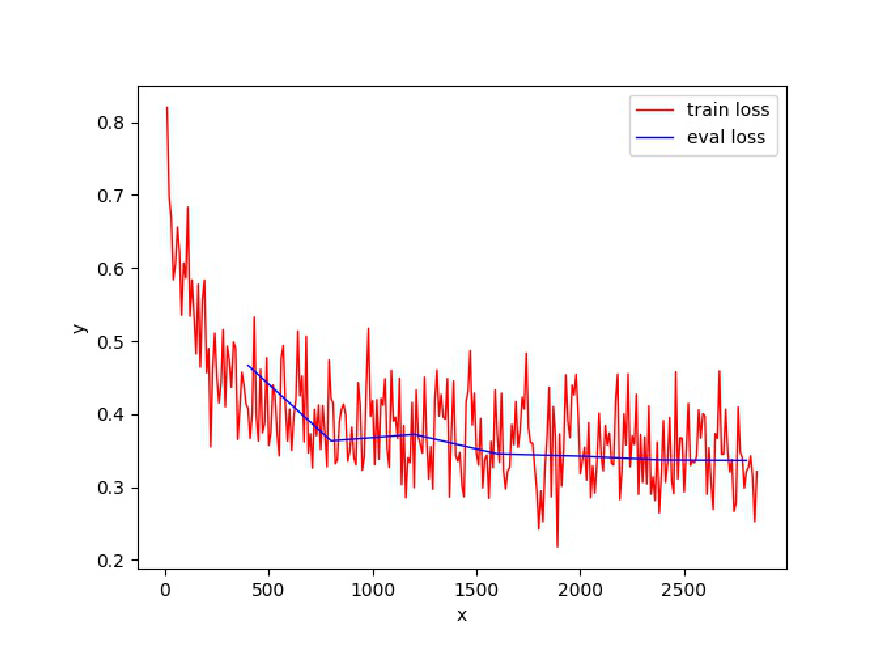

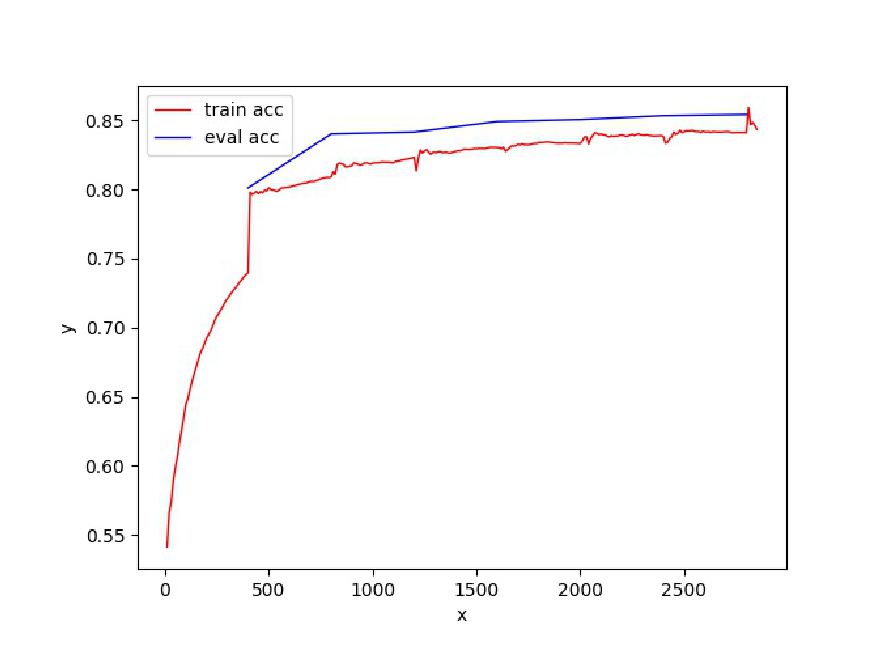

In [21]:
# 图形处理库
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# 显示图片的方法
def show_image(image_path, axis_on_off):
    # 打开指定图片
    img = Image.open(image_path) 

    plt.figure(figsize=(15, 15))

    # 是否显示坐标轴
    plt.axis(axis_on_off) 

    # 显示图片
    plt.imshow(img)

show_image("work/loss.jpg","off")
show_image("work/acc.jpg","off")

## 2.4 进行预测

In [23]:
########### test A/B 句子预测 ################
!unset CUDA_VISIBLE_DEVICES
!python -u \
    predict.py \
    --pretrain_model "ernie-gram-zh" \
    --device gpu \
    --params_path "saved_models/0930_1_100_6_8133/model_state.pdparams" \
    --batch_size 128 \
    --input_file work/test_B_processed.txt \
    --result_file "predict_results/ccf_qianyan_qm_result_B.csv"

[2021-11-25 10:54:30,110] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/ernie-gram-zh/ernie_gram_zh.pdparams
W1125 10:54:30.112032 12073 device_context.cc:404] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.0, Runtime API Version: 10.1
W1125 10:54:30.116677 12073 device_context.cc:422] device: 0, cuDNN Version: 7.6.
[2021-11-25 10:54:37,611] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/ernie-gram-zh/vocab.txt
The number of lines is 100000
Loaded parameters from saved_models/0930_1_100_6_8133/model_state.pdparams


# 第三部分：校正Misspelling（耗时约xx小时）

## 3.1 导入必要的库

In [ ]:
!pip install pypinyin
!pip install https://github.com/kpu/kenlm/archive/master.zip
!pip install pycorrector

## 3.2 找出 text_1 == text_2 的句子对

In [25]:
# 查询带有指定字词的句子对
def compare_equal_text_pair(text_list_1, text_list_2, text_label_list, print_progress = False):
    text_pairs_list = []
    label_list = []
    print("="*15 + " In Progress " + "="*15)
    for i in range (0, len(text_list_1)):
        text_1 = text_list_1[i]
        text_2 = text_list_2[i]
        
        if text_1 == text_2:
            text_pairs_list.append(text_list_1[i] + "\t" + text_list_2[i])
            if text_label_list!= None:
                label_list.append(str(i) + "\t" + str(text_label_list[i]))
 
        if print_progress and i%10000 == 0:
            print("%.2f of text pairs for different subsets identification have processed " %((i/len(text_list_1))*100))    
    print("="*15 + "     Done    " + "="*15)
    return text_pairs_list, label_list

# 使用 准备数据
test_text_pair_1_list,test_text_pair_2_list = read_candidates_test("work/test_B_processed.txt")
view_label_list = read_labels("predict_results/ccf_qianyan_qm_result_B.csv")

# 进行识别
equal_text_pairs_list, equal_label_list = compare_equal_text_pair(test_text_pair_1_list,test_text_pair_2_list, view_label_list, True)
print(len(equal_text_pairs_list))
print(equal_text_pairs_list[0])
print(len(equal_label_list))
print(equal_label_list[0])
write_file("common_data/equal_1_list.txt",equal_text_pairs_list)
print(len(read_candidates_line("common_data/equal_1_list.txt")))

# 打印结果
test_zero_list, test_one_list = summarize_one_zero(equal_text_pairs_list, equal_label_list)
print("\none in homophone_text_pairs_1_list accounts for %.2f" %(len(test_one_list)/len(equal_text_pairs_list)*100))
print(len(test_one_list))
print_examples(test_one_list, None, None, 50)
print(len(test_zero_list))
print_examples(test_zero_list, None, None, 50)



The number of lines in work/test_B_processed.txt is 100000

The number of predict result lines in predict_results/ccf_qianyan_qm_result_B.csv is 100000
=============== In Progress ===============
0.00 of text pairs for different subsets identification have processed 
10.00 of text pairs for different subsets identification have processed 
20.00 of text pairs for different subsets identification have processed 
30.00 of text pairs for different subsets identification have processed 
40.00 of text pairs for different subsets identification have processed 
50.00 of text pairs for different subsets identification have processed 
60.00 of text pairs for different subsets identification have processed 
70.00 of text pairs for different subsets identification have processed 
80.00 of text pairs for different subsets identification have processed 
90.00 of text pairs for different subsets identification have processed 
===============     Done    ===============
4116
萧红带我回到身后的村庄的启示	萧红带我回到身后的村

## 3.3 检测仅有同音字不同的句子对（lazypinyin）

In [27]:
# 检测（1）对比两个句子是否拼音一致但书写不一致（2）有同音字不同的句子对（lazypinyin） 
from pypinyin import lazy_pinyin
def compare_pinyin_and_text(text_list_1, text_list_2, text_label_list, print_progress = False):
    special_pinyin_list = [["b","p"],["m","n"],["zh","z"],["ch","c"],["sh","s"],["r","l"],["r","n"],["n","l"],["en","eng"],["an","ang"],["in","ing"],["v","i"],["v","u"],["u","i"]]
    special_words_list =[["四","十"],['汉','韩']]
    special_sentence_list = ["那里人","哪里人","哪人","多少岁"]
    pinyin_0_list = []
    label_0_list = []
    pinyin_1_list = []
    label_1_list = []
    count_percent = 0
    print("="*15 + " In Progress " + "="*15)
    for i in range (0, len(text_list_1)):
        count_percent = count_percent + 1
        
        text_1 = text_list_1[i]
        text_2 = text_list_2[i]

        subset_1, subset_2 = check_subset(text_1, text_2)

        contain_special_words = False
        if special_words_list != []:
            for special_word in special_words_list:
                if (special_word[0] == subset_1 and special_word[1] == subset_2) or (special_word[0] == subset_2 and special_word[1] == subset_1):
                    pinyin_0_list.append(text_list_1[i] + "\t" + text_list_2[i])
                    if text_label_list!= None:
                        label_0_list.append(str(i) + "\t" + str(text_label_list[i]))
                    contain_special_words = True
        contain_special_sentences = False
        if special_sentence_list != []:
            for special_sentence in special_sentence_list:
                if special_sentence in text_1 and special_sentence in text_2:
                    contain_special_sentences = True
        # 整句话的拼音是否一致
        if not contain_special_words and lazy_pinyin(text_1) == lazy_pinyin(text_2) and text_1 != text_2:
            if contain_special_sentences:
                pinyin_0_list.append(text_list_1[i] + "\t" + text_list_2[i])
                if text_label_list!= None:
                    label_0_list.append(str(i) + "\t" + str(text_label_list[i]))
            else:
                pinyin_1_list.append(text_list_1[i] + "\t" + text_list_2[i])
                if text_label_list!= None:
                    label_1_list.append(str(i) + "\t" + str(text_label_list[i]))
        # 分析两句同样长度的话中不一样的部分拼音是否一致（因为整句话的识别 哪 nei 那 na等）
        elif not contain_special_words and subset_1!="Not_The_Case" and len(subset_1) > 0 and len(subset_1) == len(subset_2):
            x = lazy_pinyin(subset_1)
            y = lazy_pinyin(subset_2)
            if x == y:
                if contain_special_sentences:
                    pinyin_0_list.append(text_list_1[i] + "\t" + text_list_2[i])
                    if text_label_list!= None:
                        label_0_list.append(str(i) + "\t" + str(text_label_list[i]))
                else:
                    pinyin_1_list.append(text_list_1[i] + "\t" + text_list_2[i])
                    if text_label_list!= None:
                        label_1_list.append(str(i) + "\t" + str(text_label_list[i]))
            elif len(x) == len (y) and x != y:
                for special_pinyin in special_pinyin_list:
                    for index in range(0,len(x)):
                        if special_pinyin[0] in x[index] and special_pinyin[0] not in y[index]:
                            x[index] = x[index].replace(special_pinyin[0],special_pinyin[1])
                        elif special_pinyin[0] in y[index] and special_pinyin[0] not in x[index]:
                            y[index] = y[index].replace(special_pinyin[0],special_pinyin[1])
                    if x == y :
                        if contain_special_sentences:
                            pinyin_0_list.append(text_list_1[i] + "\t" + text_list_2[i])
                            if text_label_list!= None:
                                label_0_list.append(str(i) + "\t" + str(text_label_list[i]))
                        else:
                            pinyin_1_list.append(text_list_1[i] + "\t" + text_list_2[i])
                            if text_label_list!= None:
                                label_1_list.append(str(i) + "\t" + str(text_label_list[i]))
        
        if print_progress and count_percent%10000 == 0:
            print("%.2f of text pairs for different subsets identification have processed " %((count_percent/len(text_list_1))*100))    
    print("="*15 + "     Done    " + "="*15)
    return pinyin_1_list, label_1_list, pinyin_0_list, label_0_list

# 使用 准备数据
test_text_pair_1_list,test_text_pair_2_list = read_candidates_test("work/test_B_processed.txt")
view_label_list = read_labels("predict_results/ccf_qianyan_qm_result_B.csv")

# 进行识别
homophone_text_pairs_1_list, homophone_label_1_list, homophone_text_pairs_0_list, homophone_label_0_list = compare_pinyin_and_text(test_text_pair_1_list,test_text_pair_2_list, view_label_list, True)
print(len(homophone_text_pairs_1_list))
print(homophone_text_pairs_1_list[0])
print(len(homophone_label_1_list))
print(homophone_label_1_list[0])
write_file("common_data/pinyin_1_text.txt",homophone_text_pairs_1_list)
write_file("common_data/pinyin_0_text.txt",homophone_text_pairs_0_list)

# 使用 方法2-7 统计测试集中，预测结果同音字的0/1概率
test_zero_list, test_one_list = summarize_one_zero(homophone_text_pairs_1_list, homophone_label_1_list)
print("\none in homophone_text_pairs_1_list accounts for %.2f" %(len(test_one_list)/len(homophone_text_pairs_1_list)*100))
print("zero in homophone_text_pairs_1_list accounts for %.2f" %(len(test_zero_list)/len(homophone_text_pairs_1_list)*100))
print(len(test_one_list))
print_examples(test_one_list, None, None, 50)
print(len(test_zero_list))
print_examples(test_zero_list, None, None, 50)

test_zero_list, test_one_list = summarize_one_zero(homophone_text_pairs_0_list, homophone_label_0_list)
if homophone_text_pairs_0_list != []:
    print("\none in homophone_text_pairs_0_list accounts for %.2f" %(len(test_one_list)/len(homophone_text_pairs_0_list)*100))
    print("zero in homophone_text_pairs_0_list accounts for %.2f" %(len(test_zero_list)/len(homophone_text_pairs_0_list)*100))
print(len(test_one_list))
print_examples(test_one_list, None, None, 50)
print(len(test_zero_list))
print_examples(test_zero_list, None, None, 50)


The number of lines in work/test_B_processed.txt is 100000

The number of predict result lines in predict_results/ccf_qianyan_qm_result_B.csv is 100000
=============== In Progress ===============
10.00 of text pairs for different subsets identification have processed 
20.00 of text pairs for different subsets identification have processed 
30.00 of text pairs for different subsets identification have processed 
40.00 of text pairs for different subsets identification have processed 
50.00 of text pairs for different subsets identification have processed 
60.00 of text pairs for different subsets identification have processed 
70.00 of text pairs for different subsets identification have processed 
80.00 of text pairs for different subsets identification have processed 
90.00 of text pairs for different subsets identification have processed 
100.00 of text pairs for different subsets identification have processed 
===============     Done    ===============
3349
小孩补什么钙好	小孩补什么盖好
3349
40

## 3.4 检测有错别字的句子对（pycorrector）

In [28]:
# 检测有错别字的句子对（pycorrector）
import pycorrector

def identify_misspelling_pycorrector(text_list_1, text_list_2, text_label_list, print_progress = False):
    text_pairs_list = []
    subset_list = []
    label_list = []
    count_percent = 0
    print("="*15 + " In Progress " + "="*15)
    for i in range (0, len(text_list_1)):
        count_percent = count_percent + 1
        
        text_1 = text_list_1[i]
        text_2 = text_list_2[i]

        if text_1!=text_2 and len(text_1) == len(text_1):
            corrected_sent_1, detail_1 = pycorrector.correct(text_1)
            corrected_sent_2, detail_2 = pycorrector.correct(text_2)
            if corrected_sent_1 == corrected_sent_2:
                text_pairs_list.append(text_list_1[i] + "\t" + text_list_2[i])
                if text_label_list!= None:
                    label_list.append(str(i) + "\t" + str(text_label_list[i]))      
        if print_progress and count_percent%5000 == 0:
            print("%.2f of text pairs for pycorrect identification have processed " %((count_percent/len(text_list_1))*100))    
    print("="*15 + "     Done    " + "="*15)
    return text_pairs_list, label_list

# 使用 准备数据
test_text_pair_1_list,test_text_pair_2_list = read_candidates_test("work/test_B_processed.txt")
view_label_list = read_labels("predict_results/ccf_qianyan_qm_result_B.csv")

# 进行识别
pycorrect_text_pairs_list, pycorrect_label_list = identify_misspelling_pycorrector(test_text_pair_1_list,test_text_pair_2_list, view_label_list, True)
print(len(pycorrect_text_pairs_list))
print(pycorrect_text_pairs_list[0])
print(len(pycorrect_label_list))
print(pycorrect_label_list[0])
write_file("common_data/pycorrector_1_list.txt",pycorrect_text_pairs_list)
print(len(read_candidates_line("common_data/pycorrector_1_list.txt")))

# 统计测试集中，预测结果同音字的0/1概率
test_zero_list, test_one_list = summarize_one_zero(pycorrect_text_pairs_list, pycorrect_label_list)
print("\none in pycorrect_text_pairs_list accounts for %.2f" %(len(test_one_list)/len(pycorrect_text_pairs_list)*100))
print("zero in pycorrect_text_pairs_list accounts for %.2f" %(len(test_zero_list)/len(pycorrect_text_pairs_list)*100))
print(len(test_one_list))
print_examples(test_one_list, None, None, 5)
print(len(test_zero_list))
print_examples(test_zero_list, None, None, 5)


The number of lines in work/test_B_processed.txt is 100000

The number of predict result lines in predict_results/ccf_qianyan_qm_result_B.csv is 100000
=============== In Progress ===============
2953396224/2953395058 [==============================] - 43s 0us/step


[  DEBUG 20211125 11:00:07 detector:  84] Loaded language model: /home/aistudio/.pycorrector/datasets/zh_giga.no_cna_cmn.prune01244.klm, spend: 53.690 s.
[  DEBUG 20211125 11:00:10 detector: 103] Loaded dict file, spend: 3.171 s.


5.00 of text pairs for pycorrect identification have processed 
10.00 of text pairs for pycorrect identification have processed 
15.00 of text pairs for pycorrect identification have processed 
20.00 of text pairs for pycorrect identification have processed 
25.00 of text pairs for pycorrect identification have processed 
30.00 of text pairs for pycorrect identification have processed 
35.00 of text pairs for pycorrect identification have processed 
40.00 of text pairs for pycorrect identification have processed 
45.00 of text pairs for pycorrect identification have processed 
50.00 of text pairs for pycorrect identification have processed 
55.00 of text pairs for pycorrect identification have processed 
60.00 of text pairs for pycorrect identification have processed 
65.00 of text pairs for pycorrect identification have processed 
70.00 of text pairs for pycorrect identification have processed 
75.00 of text pairs for pycorrect identification have processed 
80.00 of text pairs for py

## 3.5 检测有错别字的句子对(去除部首后对比）

In [5]:
# 判断一个的笔画是否包含在另一个字的笔画中
def check_word_contain(a, b, bihua_1, bushou_1, bihua_2, bushou_2):
    is_contain = True
    long_bihua = []
    short_bihua = []
    different_bihua = []
    long_bushou = []
    # 对比两个字的笔画，将笔画多的放入long_bihua其部首放入long_bushou，少的放入short_bihua,
    if len(bihua_1) > len(bihua_2):
        long_bihua = bihua_1
        short_bihua = bihua_2
        long_bushou = bushou_1
    else:
        long_bihua = bihua_2
        short_bihua = bihua_1
        long_bushou = bushou_2
    
    # 情况1 如果这两个字的从第一笔开始到len（short_bihua）存在不同，则为 不包含情况1
    for i in range(0, len(short_bihua)):
        if short_bihua[i] != long_bihua[i]:
            is_contain = False
    
    # 如果这两个字的从第一笔开始到len（short_bihua）都相同，则为 包含 
    if is_contain == True:
        # 判断剩下的笔画是否为多笔画字的部首
        different_bihua = long_bihua[len(short_bihua):len(long_bihua)]
        # 若不同部分仅为部首，返回True。否则False
        if different_bihua == long_bushou:
            return True
        else:
            return False
    else:
        is_contain = True
        # 情况2 如果这两个字的从len（short_bihua） 到 最后 存在不同，则为 不包含情况2
        for i in range(0, len(short_bihua)):
            if short_bihua[i] != long_bihua[i + len(long_bihua) - len(short_bihua)]:
                is_contain = False
        # 如果这两个字的从len（short_bihua） 到 最后 都相同，则为 包含 
        if is_contain == True:
            # 判断剩下的笔画是否为多笔画字的部首
            different_bihua = long_bihua[0:len(long_bihua) - len(short_bihua)]
            # 若不同部分仅为部首，返回True。否则False
            if different_bihua == long_bushou:
                return True
            else:
                return False
        else:
            return False

In [ ]:
# 修正偏旁与笔画(无需再次运行，已经修正部分字典内容)
# from cixing.cixing_5 import *
# from collections import Counter
# def read_word_and_bushou(file_path):
#     words_list = []
#     bushous_list = []
#     with open(file_path, 'r', encoding='utf-8') as f:
#         for line in f:
#             value = line.rstrip().split(":")
#             words_list.append(value[0])
#             bushous_list.append(value[1])
#         # print("\n字典 " + data_path + " 里共有带部首的字 " + str(len(labels)) + " 个")
#     summary = Counter(bushous_list)
#     print(summary)
#     return words_list, bushous_list

# words_list, bushous_list = read_word_and_bushou("cixing/radicals.txt")

# def check_problem(file_path, words_list, bushous_list, bushou, to_write_file = False):
#     candidates = []
#     unknown = []
#     for i in range (0, len(bushous_list)):
#         if bushous_list[i] == bushou:
#             candidates.append(words_list[i])
#     print("带有 " + bushou + "部首的字一共有：" + str(len(candidates))+ "个")
#     handler = ChineseCixing()
#     for candidate in candidates:
#         #获得全字的笔画
#         strokes_candidate = handler.get_strokes(candidate)
#         #获得全字的部首
#         radicals_candidate = handler.get_radical(candidate)
#         #获得部首的壁画
#         radicals_bushou_candidate = handler.get_strokes(radicals_candidate)
#         subset_1, subset_2 = check_subset(strokes_candidate[0], radicals_bushou_candidate[0])
#         if subset_1 == "Not_The_Case" or subset_2 == "Not_The_Case":
#             unknown.append(candidate)
#             word_index = words_list.index(candidate)
#             print(word_index)
#             bushous_list[word_index] ="xiao1"
#             print(candidate, strokes_candidate)
#             print(radicals_candidate, radicals_bushou_candidate)
    
#     print(len(unknown))

#     if to_write_file:
#         with open(file_path, 'w', encoding="utf-8") as f:
#             for i in range(0,len(words_list)):
#                 f.write(words_list[i] + ":" + bushous_list[i] + "\n")      
   
#     #     break

# check_problem("cixing/radicals.txt", words_list, bushous_list,"力",False)

In [6]:
# 去掉两个字符串中相同的连续部分
def remove_bushou(a, b, text_1, bushou_1, text_2, bushou_2):

    if text_1!= bushou_1 and text_2 != bushou_2:
        #获取除了部首之外的笔画
        rest_1 = []
        rest_2 = []

        # print("text_1: " + str(text_1))
        # print("bushou_1:"  + str(bushou_1))
        # print("text_2: " + str(text_2))
        # print("bushou_2: " + str(bushou_2))

        subset_1_1, subset_1_2 = check_subset(text_1, bushou_1)
        subset_2_1, subset_2_2 = check_subset(text_2, bushou_2)
        
        # print(subset_1_1,subset_1_2 )
        # print(subset_2_1,subset_2_2 )
        # 第一个字去掉部首后剩余的笔画
        if subset_1_1 == "Not_The_Case" or subset_1_2 == "Not_The_Case":
            x = 1
        elif subset_1_2 ==[] and subset_1_1!=[]: 
            rest_1 = subset_1_1 
        elif subset_1_2 !=[] and subset_1_1==[]:
            rest_1 = subset_1_2

        # 第二个字去掉部首后剩余的笔画
        if subset_2_1 == "Not_The_Case" or subset_2_2 == "Not_The_Case":
            x = 1
        elif subset_2_2 ==[] and subset_2_1!=[]: 
            rest_2 = subset_2_1 
        elif subset_2_2 !=[] and subset_2_1==[]:
            rest_2 = subset_2_2

        
        # print(rest_1,rest_2)  
        #若剩余比划相同 且 不为空
        if rest_1 == rest_2 and rest_1 != []:
            return True
        else:
            return False
    else:
        # 若分解出的部首就是该字本身
        return False


In [7]:
#通过cixing来分解汉字部首和笔画
from cixing.cixing_5 import *
def compare_bushou_bihua(text_1,text_2):
    handler = ChineseCixing()
    #获得全字的笔画
    strokes_original_1 = handler.get_strokes(text_1)
    strokes_original_2 = handler.get_strokes(text_2)
    #获得全字的部首
    radicals_original_1 = handler.get_radical(text_1)
    radicals_original_2 = handler.get_radical(text_2)
    #获得部首的笔画
    radicals_bushou_1 = handler.get_strokes(radicals_original_1)
    radicals_bushou_2 = handler.get_strokes(radicals_original_2)
    #如果其中一个字是另一个字的一部分，如 不/怀 返回True
    if check_word_contain(text_1, text_2, strokes_original_1[0],radicals_bushou_1[0],strokes_original_2[0],radicals_bushou_2[0]) :
        # print("其中一个字是另一个字去掉部首后的部分")
        return True
    else:
        # 部首不同 如 怀/还
        if radicals_original_1[0] != radicals_original_2[0]:
            # print("部首不同")
            comparison = remove_bushou(text_1, text_2, strokes_original_1[0],radicals_bushou_1[0],strokes_original_2[0],radicals_bushou_2[0])
            return comparison
        else:
            # print("部首相同")
            return False

In [8]:
# 检测仅一字不同，且除部首外有相似结构
# 是否是中文
def is_Chinese(ch): 
    if '\u4e00' <= ch <= '\u9fff': 
        return True 
    return False

# 方法3-3 检测仅一字不同，且除部首外有相似结构
def identify_misspelling_structure(text_list_1, text_list_2, text_label_list, print_progress = False):
    text_pairs_list = []
    label_list = []
    print("="*15 + " In Progress " + "="*15)
    for i in range (0, len(text_list_1)):

        text_1 = text_list_1[i]
        text_2 = text_list_2[i]

        subset_1, subset_2 = check_subset(text_1, text_2)
        if subset_1!="Not_The_Case" and subset_1!="" and subset_2!="":
            # 如果有一个字不一样，尝试发现是否是结构上的错别字
            if len(subset_1) == len(subset_2) and len(subset_2) == 1 :
                if is_Chinese(subset_1) and is_Chinese(subset_2) and not(subset_1.isnumeric() or subset_2.isnumeric()):
                    has_similar_part = compare_bushou_bihua(subset_1,subset_2)
                    if has_similar_part:
                        text_pairs_list.append(text_list_1[i] + "\t" + text_list_2[i])
                        if text_label_list!= None:
                            label_list.append(str(i) + "\t" + str(text_label_list[i]))
        if print_progress and i!=0 and i%2000 == 0:
            print("%.2f of text pairs for 1 word different have processed " %((i/len(text_list_1))*100))  
    print("="*15 + "     Done    " + "="*15)
    return text_pairs_list, label_list

In [9]:
# 使用 准备数据
test_text_pair_1_list,test_text_pair_2_list = read_candidates_test("work/test_B_processed.txt")
view_label_list = read_labels("predict_results/ccf_qianyan_qm_result_B.csv")

# 进行识别
structure_text_pairs_list, structure_label_list = identify_misspelling_structure(test_text_pair_1_list,test_text_pair_2_list, view_label_list, True)
print(len(structure_text_pairs_list))
print(structure_text_pairs_list[0])
print(len(structure_label_list))
print(structure_label_list[0])

write_file("common_data/structure_1_list.txt",structure_text_pairs_list)

# 统计测试集中，预测结果同音字的0/1概率
test_zero_list, test_one_list = summarize_one_zero(structure_text_pairs_list, structure_label_list)
print("\none in structure_text_pairs_list accounts for %.2f" %(len(test_one_list)/len(structure_text_pairs_list)*100))
print("zero in structure_text_pairs_list accounts for %.2f" %(len(test_zero_list)/len(structure_text_pairs_list)*100))
print(len(test_one_list))
print_examples(test_one_list, None, None, 5)
print(len(test_zero_list))
print_examples(test_zero_list, None, None, 5)


The number of lines in work/test_B_processed.txt is 100000

The number of predict result lines in predict_results/ccf_qianyan_qm_result_B.csv is 100000
=============== In Progress ===============
2.00 of text pairs for 1 word different have processed 
4.00 of text pairs for 1 word different have processed 
6.00 of text pairs for 1 word different have processed 
8.00 of text pairs for 1 word different have processed 
10.00 of text pairs for 1 word different have processed 
12.00 of text pairs for 1 word different have processed 
14.00 of text pairs for 1 word different have processed 
16.00 of text pairs for 1 word different have processed 
18.00 of text pairs for 1 word different have processed 
20.00 of text pairs for 1 word different have processed 
22.00 of text pairs for 1 word different have processed 
24.00 of text pairs for 1 word different have processed 
26.00 of text pairs for 1 word different have processed 
28.00 of text pairs for 1 word different have processed 
30.00 of 

## 3.6 同音人名与同音地名不作为mispelling

In [11]:
# 尝试发现仅有人名是否仅有一个字的区别，若有则返回True
def discover_naming_mistake(name_1, name_2):
    different_words = []
    if len(name_1) == len(name_2) and len(name_2)>=2:
        for i in range(0, len(name_1)):
            if name_1[i] != name_2[i]:
                different_words.append(name_1[i])
                different_words.append(name_2[i])
    if len(different_words) == 2:
        return True
    else:
        return False

# 方法 3-4 寻找包含人名但仅差别一个字的句子对
from pypinyin import lazy_pinyin
def identify_name_misspelling(data_list_1, data_list_2, data_label_list = None, print_progress = False):
    celebrities_list = []
    name_1_text_pairs_list = []
    name_1_label_list = []
    name_0_text_pairs_list = []
    name_0_label_list = []
    print("="*15 + " In Progress " + "="*15)
    count = 0
    for i in range (0, len(data_list_1)):
        text_1 = data_list_1[i]
        text_2 = data_list_2[i]

        subset_1, subset_2 = check_subset(text_1,text_2)

        is_same_name_entity = False

        if subset_1!="Not_The_Case" and len(subset_1) == 1 and len(subset_1) == len(subset_2):
            words_1, natures_1 = get_words_and_words_nature(text_1)
            words_2, natures_2 = get_words_and_words_nature(text_2)
            # 有特殊姓名的处理方法
            if celebrities_list != []:
                if "PER" in natures_1 and "PER" in natures_2 and len(natures_1) == len(natures_2):
                    # print(subset_1,subset_2)
                    for x in range(0, len(natures_1)):
                        if (natures_1[x] == "PER" and natures_2[x] == "PER") and (words_1[x] != words_2[x]):
                            # print(words_1[x] , words_2[x])
                            for celebrity in celebrities_list:
                                condition_1 = bool((celebrity == words_1[x]) and discover_naming_mistake(celebrity, words_2[x]))
                                condition_2 = bool((celebrity == words_2[x]) and discover_naming_mistake(celebrity, words_1[x]))
                                condition_3 = bool((words_1[x] in celebrity) and (celebrity in words_2[x]))
                                condition_4 = bool((words_2[x] in celebrity) and (celebrity in words_1[x]))
                                if  condition_1 or condition_2 or condition_3 or condition_4:
                                    count = count + 1
                                    name_1_text_pairs_list.append(data_list_1[i] + "\t" + data_list_2[i] )
                                    if data_label_list!= None:
                                        name_1_label_list.append(str(i) + "\t" + data_label_list[i])
                                        is_same_name_entity = True
                                    break
                    for x in range(0, len(natures_1)):
                        if (natures_1[x] == "PER" and natures_2[x] == "PER") and (words_1[x] != words_2[x]) and not is_same_name_entity:
                            name_0_text_pairs_list.append(data_list_1[i] + "\t" + data_list_2[i] )
                            if data_label_list!= None:
                                name_0_label_list.append(str(i) + "\t" + data_label_list[i])
            else:
                if "PER" in natures_1 and "PER" in natures_2 and len(natures_1) == len(natures_2):
                    # print(subset_1,subset_2)
                    for x in range(0, len(natures_1)):
                        if (natures_1[x] == "PER" and natures_2[x] == "PER") and (words_1[x] != words_2[x]):
                            name_0_text_pairs_list.append(data_list_1[i] + "\t" + data_list_2[i] )
                            if data_label_list!= None:
                                name_0_label_list.append(str(i) + "\t" + data_label_list[i]) 
        if print_progress and i%10000 == 0:
            print("%.2f of text pairs for name misspelling identification have processed " %((i/len(data_list_1))*100))    
    print("="*15 + "     Done    " + "="*15)
    print("带有相关信息的名人名字拼写错误的有: " + str(count) + " 对\n")
    return name_1_text_pairs_list, name_1_label_list, name_0_text_pairs_list, name_0_label_list

# 使用 准备数据
test_text_pair_1_list,test_text_pair_2_list = read_candidates_test("work/test_B_processed.txt")
view_label_list = read_labels("predict_results/ccf_qianyan_qm_result_B.csv") #仅仅用来查看，不影响结果

# 进行识别
name_1_text_pairs_list, name_1_label_list, name_0_text_pairs_list, name_0_label_list = identify_name_misspelling(test_text_pair_1_list,test_text_pair_2_list, view_label_list, True)

write_file("common_data/name_1_list.txt",name_1_text_pairs_list)
write_file("common_data/name_0_list.txt",name_0_text_pairs_list)

# 统计测试集中，预测结果同音字的0/1概率

print("==============" + str(len(name_1_text_pairs_list)) + "==============")
test_zero_list, test_one_list = summarize_one_zero(name_1_text_pairs_list, name_1_label_list)
if len(name_1_text_pairs_list)!=0:
    print("\none in name_1_text_pairs_list accounts for %.2f" %(len(test_one_list)/len(name_1_text_pairs_list)*100))
    print("zero in name_1_text_pairs_list accounts for %.2f" %(len(test_zero_list)/len(name_1_text_pairs_list)*100))
print_examples(test_one_list, None, None, 50)
print_examples(test_zero_list, None, None, 50)

print("==============" + str(len(name_0_text_pairs_list)) + "==============")
test_zero_list, test_one_list = summarize_one_zero(name_0_text_pairs_list, name_0_label_list)
if len(name_0_text_pairs_list)!=0:
    print("\none in name_0_text_pairs_list accounts for %.2f" %(len(test_one_list)/len(name_0_text_pairs_list)*100))
    print("zero in name_0_text_pairs_list accounts for %.2f" %(len(test_zero_list)/len(name_0_text_pairs_list)*100))
print_examples(test_one_list, None, None, 50)
print_examples(test_zero_list, None, None, 50)


The number of lines in work/test_B_processed.txt is 100000

The number of predict result lines in predict_results/ccf_qianyan_qm_result_B.csv is 100000
=============== In Progress ===============
0.00 of text pairs for name misspelling identification have processed 
10.00 of text pairs for name misspelling identification have processed 
20.00 of text pairs for name misspelling identification have processed 
30.00 of text pairs for name misspelling identification have processed 
40.00 of text pairs for name misspelling identification have processed 
50.00 of text pairs for name misspelling identification have processed 
60.00 of text pairs for name misspelling identification have processed 
70.00 of text pairs for name misspelling identification have processed 
80.00 of text pairs for name misspelling identification have processed 
90.00 of text pairs for name misspelling identification have processed 
===============     Done    ===============
带有相关信息的名人名字拼写错误的有: 0 对

==============0=

In [15]:
# 同音地名处理（无需重复运行）
# 去除 地名后的"省","市","县","区","镇","乡","村"
def remove_p_c_a(location):
    p_c_t = [
        "拉祜族佤族布朗族傣族自治县","保安族东乡族撒拉族自治县","彝族哈尼族拉祜族自治县","傣族拉祜族佤族自治县","哈尼族彝族傣族自治县",
        "哈尼族彝族傣族自治县","苗族瑶族傣族自治县","彝族回族苗族自治县","满族蒙古族自治县","土家族苗族自治州","哈尼族彝族自治县",
        "布依族苗族自治州","蒙古族藏族自治州","哈尼族彝族自治州","傣族景颇族自治州","土家族苗族自治县","白族普米族自治县",
        "苗族土家族自治县","布依族苗族自治县","土家族苗族自治县","苗族布依族自治县","仡佬族苗族自治县","哈尼族彝族自治县",
        "独龙族怒族自治县","壮族苗族自治州","苗族侗族自治州","黎族苗族自治县","壮族瑶族自治县","藏族羌族自治州",
        "苗族侗族自治县","回族苗族自治县","彝族傣族自治县","彝族傣族自治县","彝族苗族自治县","傣族佤族自治县","柯尔克孜自治州",
        "苗族彝族自治县","回族彝族自治县","回族土族自治县","彝族回族自治县","族撒拉族自治县","哈萨克族自治县","哈萨克自治州",
        "拉祜族自治县","纳西族自治县","哈尼族自治县","傈僳族自治县","哈萨克自治县","仫佬族自治县","毛南族自治县",
        "傈僳族自治州","朝鲜族自治县","朝鲜族自治州","蒙古族自治县","撒拉族自治县","土家族自治县","维吾尔自治区",
        "各族自治县","佤族自治县","回族自治县","土族自治县","彝族自治县","锡伯自治县","水族自治县","怒族自治县","羌族自治县",
        "藏族自治县","彝族自治县","苗族自治县","侗族自治县","瑶族自治县","满族自治县","回族自治县","蒙古自治州","白族自治州",
        "固族自治县","瑶族自治县","傣族自治州","苗族自治县","藏族自治州","畲族自治县","彝族自治州","回族自治州","壮族自治区",
        "黎族自治县","锡伯自治县","特别行政区","地区","自治区","自治县","省","市","盟","县","区","镇","乡","村"]
    special_location = ["神农架林区"]
    for x in p_c_t:
        if location == "神农架林区":
            location = "神农架"
        elif len(location) > 2 and x in location:
            location = location[:-len(x)]
            break
    return location
# 读取地名数据
import json
def read_location(json_file_path):
    with open(json_file_path, 'r') as file:
        china_location_data = json.load(file)
    locations_province_list = []
    locations_city_list = []
    locations_area_list = []
    
    for p_i in range(0, len(china_location_data)):
        province = remove_p_c_a(china_location_data[p_i]['name'])
        locations_province_list.append(province)
        for c_i in range(0, len(china_location_data[p_i]['city'])):
            city = remove_p_c_a(china_location_data[p_i]['city'][c_i]['name'])
            locations_city_list.append(city)
            for a_i in range(0, len(china_location_data[p_i]['city'][c_i]['area'])):
                area = remove_p_c_a(china_location_data[p_i]['city'][c_i]['area'][a_i])
                locations_area_list.append(area)

    return locations_province_list, locations_city_list, locations_area_list

# 尝试发现同音地名，写入文件
from pypinyin import lazy_pinyin
def discover_homophone_locations(locations_list):
    homophone_locations_list = []
    for i in range(0, len(locations_list)):
        if i < len(locations_list) - 1:
            for j in range (i + 1, len(locations_list)):
                if lazy_pinyin(locations_list[i]) == lazy_pinyin(locations_list[j]):
                    homophone_locations = locations_list[i] + "\t" + locations_list[j]
                    homophone_locations_list.append(homophone_locations)
        if i % 250 == 0:
            print("%.2f of locations for homophone have processed " %((i/len(locations_list))*100))    
    write_file("common_data/homophone_locations.txt",homophone_locations_list)
    return homophone_locations_list

# 载入并读取地点名称的json文件，返回 provinces_list, citys_list, areas_list
location_file_path = 'common_data/locations.json'   
provinces_list, citys_list, areas_list = read_location(location_file_path)
print(len(provinces_list))
print(len(citys_list))
print(len(areas_list))

# 将所有地名合并到locations里
locations = list(set(provinces_list + citys_list + areas_list))
print(len(locations))
print(locations[1000])

# 尝试发现同音地名
homophone_locations_list = discover_homophone_locations(locations)
print(len(homophone_locations_list))
print(homophone_locations_list)


34
391
3227
3088
红旗
0.00 of locations for homophone have processed 
8.10 of locations for homophone have processed 
16.19 of locations for homophone have processed 
24.29 of locations for homophone have processed 
32.38 of locations for homophone have processed 
40.48 of locations for homophone have processed 
48.58 of locations for homophone have processed 
56.67 of locations for homophone have processed 
64.77 of locations for homophone have processed 
72.86 of locations for homophone have processed 
80.96 of locations for homophone have processed 
89.05 of locations for homophone have processed 
97.15 of locations for homophone have processed 
325
['泰安\t台安', '临翔\t临湘', '庆元\t清原', '庆元\t清远', '庆元\t清苑', '庆元\t青原', '蓟  \t吉  ', '宜城\t峄城', '宜城\t驿城', '宜城\t翼城', '庆城\t清城', '榆林\t玉林', '历城\t黎城', '历城\t荔城', '历城\t鲤城', '兰山\t蓝山', '兰山\t岚山', '淮阴\t槐荫', '铜川\t通川', '岳西\t越西', '吴江\t武江', '原阳\t元阳', '镇沅\t镇远', '镇沅\t镇原', '连江\t廉江', '榆中\t渝中', '交城\t蕉城', '陵川\t灵川', '澧县\t理县', '澧县\t礼县', '洛江\t罗江', '长武\t彰武', '漳州\t长洲', '塔河\t漯河'

In [16]:
# 同音地名不作为错误纠正
# 读取同音地名文件，存入list
def read_homophone_locations(file_path):
    homophone_locations_list = []
    text_1, text_2 = read_candidates_test(file_path)
    for i in range(0, len(text_1)):
        homophone_locations_list.append((text_1[i],text_2[i]))
    return homophone_locations_list
    
# 从文件中读取
homophone_locations_list = read_homophone_locations("common_data/homophone_locations.txt")
print(len(homophone_locations_list))
print(homophone_locations_list[0])

# 同音地名不作为错误纠正
exclusion_list = list(set(homophone_locations_list)) 

# 将带有exclusion list中 字词的句子对找出
def discover_exclusion(exclusion_list, text_list_1, text_list_2, text_label_list, label_value = "0", print_progress = False):
    exclusion_text_pair_0_list = []
    exclusion_label_0_list = []
    exclusion_text_pair_1_list = []
    exclusion_label_1_list = []
    count_percent = 0

    print("="*15 + " In Progress " + "="*15)
    for i in range (0, len(text_list_1)):
        count_percent = count_percent + 1
        text_1 = text_list_1[i]
        text_2 = text_list_2[i]
    
        for exclusion in exclusion_list:
            if (len(text_1) == len(text_2)):
                if (exclusion[0] in text_1 and exclusion[1] in text_2) or (exclusion[0] in text_2 and exclusion[1] in text_1):
                    if (text_1.replace(exclusion[0],"") == text_2.replace(exclusion[1],"")) or (text_2.replace(exclusion[0],"") == text_1.replace(exclusion[1],"")):
                        if label_value == "0":
                            exclusion_text_pair_0_list.append(text_list_1[i] + "\t" + text_list_2[i])
                            if text_label_list!= None:
                                exclusion_label_0_list.append(str(i) + "\t" + str(text_label_list[i]))
                            break
                        else:
                            exclusion_text_pair_1_list.append(text_list_1[i] + "\t" + text_list_2[i])
                            if text_label_list!= None:
                                exclusion_label_1_list.append(str(i) + "\t" + str(text_label_list[i]))
                            break

        if print_progress and count_percent%10000 == 0:
            print("%.2f of text pairs for different subsets identification have processed " %((count_percent/len(text_list_1))*100))    
    print("="*15 + "     Done    " + "="*15)
    return exclusion_text_pair_1_list, exclusion_label_1_list, exclusion_text_pair_0_list, exclusion_label_0_list

# 使用 准备数据
test_text_pair_1_list,test_text_pair_2_list = read_candidates_test("work/test_B_processed.txt")
view_label_list = read_labels("predict_results/ccf_qianyan_qm_result_B.csv") #仅仅用来查看，不影响结果

exclusion_text_pair_1_list, exclusion_label_1_list, exclusion_text_pair_0_list, exclusion_label_0_list = discover_exclusion(exclusion_list, test_text_pair_1_list,test_text_pair_2_list, view_label_list, "0",  True)
write_file("common_data/exclusion_1_list.txt",exclusion_text_pair_1_list)
write_file("common_data/exclusion_0_list.txt",exclusion_text_pair_0_list)

#查看文件中的句子对数量
print(len(read_candidates_line("common_data/exclusion_1_list.txt")))
print_examples(exclusion_text_pair_1_list,exclusion_label_1_list,None, 100)
print(len(read_candidates_line("common_data/exclusion_0_list.txt")))
print_examples(exclusion_text_pair_0_list,exclusion_label_0_list,None, 100)


The number of lines in common_data/homophone_locations.txt is 325
325
('泰安', '台安')

The number of lines in work/test_B_processed.txt is 100000

The number of predict result lines in predict_results/ccf_qianyan_qm_result_B.csv is 100000
=============== In Progress ===============
10.00 of text pairs for different subsets identification have processed 
20.00 of text pairs for different subsets identification have processed 
30.00 of text pairs for different subsets identification have processed 
40.00 of text pairs for different subsets identification have processed 
50.00 of text pairs for different subsets identification have processed 
60.00 of text pairs for different subsets identification have processed 
70.00 of text pairs for different subsets identification have processed 
80.00 of text pairs for different subsets identification have processed 
90.00 of text pairs for different subsets identification have processed 
100.00 of text pairs for different subsets identification have


## 3.7 校正Misspelling预测值

In [17]:
# 依据输入的列表校正预测值
def adjust_predict_label(test_a_text_pairs, final_predict_lables, index_and_adjusted_labels, print_correction = True):
    print("test_a_text_pairs: " + str(len(test_a_text_pairs)))
    print("final_predict_lables" + str(len(final_predict_lables)))
    print("index_and_adjusted_labels" + str(len(index_and_adjusted_labels)))
    count = 0
    for i in range(0, len(index_and_adjusted_labels)):
        index_label = index_and_adjusted_labels[i].rstrip().split("\t")
        index = int(index_label[0])
        adjusted_label = index_label[1]
        if final_predict_lables[index]!= adjusted_label:
            count = count + 1
            if print_correction:
                print(test_a_text_pairs[index])
                print('index:' + str(index))
                print('predict_label:' + str(final_predict_lables[index]))
                print('adjusted_label:' + str(adjusted_label))
                print("="*30)
            final_predict_lables[index] = adjusted_label 
    print ("预测值校正个数为: " + str(count))
    return final_predict_lables

In [18]:
# test a text pairs and predict labels
test_a_data_line_list = read_candidates_line("work/test_B_processed.txt")
print("test_a_data_line_list: " + str(len(test_a_data_line_list)))

predict_label_list = read_labels("predict_results/ccf_qianyan_qm_result_B.csv")
print("predict_label_list: " + str(len(predict_label_list)))

# homephone + pycorrector 读取句子对
pinyin_1_list = read_candidates_line("common_data/pinyin_1_text.txt")
pinyin_0_list = read_candidates_line("common_data/pinyin_0_text.txt")
pycorrector_1_list = read_candidates_line("common_data/pycorrector_1_list.txt")
structure_1_list = read_candidates_line("common_data/structure_1_list.txt")
name_1_list = read_candidates_line("common_data/name_1_list.txt")
name_0_list = read_candidates_line("common_data/name_0_list.txt")
equal_1_list = read_candidates_line("common_data/equal_1_list.txt")

misspelling_1_list = list(set(pinyin_1_list + pycorrector_1_list + structure_1_list + name_1_list + equal_1_list))
misspelling_0_list = list(set(pinyin_0_list + name_0_list))
exclusion_1_list = read_candidates_line("common_data/exclusion_1_list.txt")
exclusion_0_list = read_candidates_line("common_data/exclusion_0_list.txt")

print(len(misspelling_1_list))
print(len(misspelling_0_list))

# 已校正的句子对在后续工作中无需重复处理
final_misspelling_list = list(set(misspelling_1_list + misspelling_0_list + exclusion_1_list + exclusion_0_list))
write_file("common_data/misspelling_list.txt",final_misspelling_list )

# 赋值
misspelling_1_index_label_list = []
for i in range (0, len(test_a_data_line_list)):
    if test_a_data_line_list[i] in misspelling_1_list:
        misspelling_1_index_label_list.append(str(i)+"\t1")

misspelling_0_index_label_list = []
for i in range (0, len(test_a_data_line_list)):
    if test_a_data_line_list[i] in misspelling_0_list:
        misspelling_0_index_label_list.append(str(i)+"\t0")

exclusion_0_index_label_list = []
for i in range (0, len(test_a_data_line_list)):
    if test_a_data_line_list[i] in exclusion_0_list:
        exclusion_0_index_label_list.append(str(i)+"\t0")

exclusion_1_index_label_list = []
for i in range (0, len(test_a_data_line_list)):
    if test_a_data_line_list[i] in exclusion_1_list:
        exclusion_1_index_label_list.append(str(i)+"\t1")

# 先后顺序很重要
misspelling_index_label_list =  misspelling_0_index_label_list + misspelling_1_index_label_list + exclusion_0_index_label_list + exclusion_1_index_label_list

print("misspelling_index_label_list: " + str(len(misspelling_index_label_list)))

# 使用 方法4-1 来 校正 预测值 
final_predict_lables = adjust_predict_label(test_a_data_line_list, predict_label_list, misspelling_index_label_list, True)

# 写入文件
write_file("predict_results/ms_ccf_qianyan_qm_result_B.csv",final_predict_lables)

test_a_data_line_list: 100000

The number of predict result lines in predict_results/ccf_qianyan_qm_result_B.csv is 100000
predict_label_list: 100000
6417
403
misspelling_index_label_list: 7650
test_a_text_pairs: 100000
final_predict_lables100000
index_and_adjusted_labels7650
宋庆龄哪里人	殳庆龄哪里人
index:2242
predict_label:1
adjusted_label:0
于震演过的电视剧	于波演过的电视剧
index:3600
predict_label:1
adjusted_label:0
吕丽萍的老公是谁	赵丽萍的老公是谁
index:4605
predict_label:1
adjusted_label:0
鲁班发明了什么	鲁康发明了什么
index:5822
predict_label:1
adjusted_label:0
杨千里演员	杨千嬅演员
index:6172
predict_label:1
adjusted_label:0
王羲之是哪个朝代的人	王献之是哪个朝代的人
index:6304
predict_label:1
adjusted_label:0
乌兰图雅的老公是谁	乌蓝图雅的老公是谁
index:6510
predict_label:1
adjusted_label:0
周文王活了多少岁	周宣王活了多少岁
index:6707
predict_label:1
adjusted_label:0
诸葛亮的儿子是谁	诸葛瞻的儿子是谁
index:6894
predict_label:1
adjusted_label:0
伊可尔治疗扁平疣	伊可儿治疗扁平疣
index:6982
predict_label:1
adjusted_label:0
朱开山是哪个地方的人	朱开福是哪个地方的人
index:7324
predict_label:1
adjusted_label:0
卓别林为什么没有被杀	卓师林为什么没有被杀
index:9151
predict_la

## 3.8 对比校正结果

In [21]:
#读取test和两个预测值
test_text_list_1, test_text_list_2 = read_candidates_test("work/test_B_1118.tsv")
test_predict_label_list_1 = read_labels("predict_results/ccf_qianyan_qm_result_B.csv")
test_predict_label_list_2 = read_labels("predict_results/ms_ccf_qianyan_qm_result_B.csv")
print(len(test_text_list_1))
print(len(test_text_list_2))
print(len(test_predict_label_list_1))
print(len(test_predict_label_list_2))

# 对比两组预测值，并输出不同的预测结果
def compre_predict_results(text_list1, text_list2, candidates_1, candidates_2):
    list1 = []
    list2 = []
    label1 = []
    label2 = []
    j = 0
    for i in range (0,len(candidates_1)): 
        if candidates_1[i] != candidates_2[i]:
            print("No. " + str(i) + " label 1 = " + str(candidates_1[i]) + " lable 2 = " + str(candidates_2[i]) + " text pair: " + text_list1[i] + " " + text_list2[i])
            list1.append(text_list1[i])
            list2.append(text_list2[i])
            label1.append(candidates_1[i])
            label2.append(candidates_2[i])
            j = j + 1
    print("Total number of differences is " + str(j))
    print("Two prediction's similarity is %.2f"%((len(candidates_2) - j)/len(candidates_2)*100))
    return list1, list2, label1, label2

text_list1, text_list2, correct_text_list1, predict_text_list1= compre_predict_results(test_text_list_1, test_text_list_2, test_predict_label_list_1, test_predict_label_list_2)
print("不同的预测值共有： " + str(len(predict_text_list1)) + " 组")



The number of lines in work/test_B_1118.tsv is 100000

The number of predict result lines in predict_results/ccf_qianyan_qm_result_B.csv is 100000

The number of predict result lines in predict_results/ms_ccf_qianyan_qm_result_B.csv is 100000
100000
100000
100000
100000
No. 40 label 1 = 0 lable 2 = 1 text pair: 小孩补什么钙好 小孩补什么盖好
No. 166 label 1 = 0 lable 2 = 1 text pair: 水浒传作者 水浒转作者
No. 171 label 1 = 0 lable 2 = 1 text pair: 月经不调吃什么药 月经不调吃什么要
No. 449 label 1 = 0 lable 2 = 1 text pair: 脱发挂什么科 脱发挂什么课
No. 479 label 1 = 0 lable 2 = 1 text pair: 文言文翻译器 文言文翻译其
No. 492 label 1 = 0 lable 2 = 1 text pair: 经期能喝茶吗 经期能喝茶马
No. 594 label 1 = 0 lable 2 = 1 text pair: 腰肌劳损怎么办 腰肌劳损怎么半
No. 751 label 1 = 0 lable 2 = 1 text pair: 慢性肠胃炎吃什么药 漫性肠胃炎吃什么药
No. 771 label 1 = 0 lable 2 = 1 text pair: 草珊瑚的功效与作用 草珊湖的功效与作用
No. 892 label 1 = 0 lable 2 = 1 text pair: 一直拉肚子是怎么回事 一只拉肚子是怎么回事
No. 1090 label 1 = 0 lable 2 = 1 text pair: 阑尾炎手术后吃什么好 兰尾炎手术后吃什么好
No. 1256 label 1 = 0 lable 2 = 1 text pair: 先兆流产的症状 先找流产的症状
No. 126

# 第四部分：校正Syntatic Structure（耗时约xx小时）

## 4.1 校正Symmetry和Asymmetry（包含指定词性和句式的句子对）

In [22]:
#对比是否是对调指定字左右两边的字词
def verify_word_switch(text_1, text_2, word):
    # word左右字符数量初始化
    right_length = 0
    left_length = 0
    # 对于text_1中的每一个字符
    for i in range(0, len(text_1)):
        # 除指定word外，从左往右，若在同一个位置找到相同的字符则替换为“ ”
        if text_1[i] != word and text_1[i] == text_2[i]:
            text_1 = text_1[:i] + " " + text_1[i+1:]
            text_2 = text_2[:i] + " " + text_2[i+1:]
    # 将“ ” 替换为“” 
    text_1 = text_1.replace(" ","")
    text_2 = text_2.replace(" ","")
    # print(text_1, text_2)
    # 如果剩下的字词长度一致
    if len(text_1) == len(text_2):
        # 获得两个句子中word存在的数量
        count_word_1 = text_1.count(word)
        count_word_2 = text_2.count(word)
        # 若句子中word数量相同
        if count_word_1 == count_word_2:
            # 仅存在一个word时
            if  count_word_1 == 1:
                word_index_1 = text_1.index(word)
                word_index_2 = text_2.index(word)
                return check_left_right(text_1, text_2, word_index_1, word_index_2)
            # 存在多个word时
            elif count_word_1 == 2:
                w_1_index_list = []
                w_2_index_list = []
                for w_1 in range(0, len(text_1)):
                    if text_1[w_1] == word: w_1_index_list.append(w_1)
                for w_2 in range(0, len(text_2)):
                    if text_2[w_2] == word: w_2_index_list.append(w_2)
                condition_1 = check_left_right(text_1, text_2, w_1_index_list[0], w_2_index_list[1])
                condition_2 = check_left_right(text_1, text_2, w_1_index_list[1], w_2_index_list[0])
                if condition_1 or condition_2:
                    return True
                else: 
                    return False

# 检查指定               
def check_left_right(text_1, text_2, word_index_1, word_index_2):
    num_word_removed = 0
    # print(word_index_1, word_index_2)
    # 找出word左边字符的最小数量
    if word_index_1 <= word_index_2:
        left_length = word_index_1
    else:
        left_length = word_index_2
    # 找出word右边字符的最小数量   
    if len(text_1) - word_index_1 <= len(text_2) - word_index_2:
        right_length = len(text_1) - word_index_1
    else:
        right_length = len(text_2) - word_index_2
    # print(right_length, left_length)
    # 如果word在句子头或尾则无内容对调直接返回False
    if right_length == 0 or left_length == 0:
        return False
    else:
        # 在word左边，离word相同距离若有相同的字则替换为" "
        for j in range (1, left_length):
            x = word_index_1 - j
            y = word_index_2 - j
            if text_1[x] == text_2[y]:
                num_word_removed = num_word_removed + 1
                text_1 = text_1[:x] + " " + text_1[x+1:]
                text_2 = text_2[:y] + " " + text_2[y+1:]
         # 在word右边，离word相同距离若有相同的字则替换为" "
        for k in range (1, right_length):
            x = word_index_1 + k
            y = word_index_2 + k
            if text_1[x] == text_2[y]:
                text_1 = text_1[:x] + " " + text_1[x+1:]
                text_2 = text_2[:y] + " " + text_2[y+1:] 
    # print(text_1, text_2)
    # 将“ ” 替换为“” 
    text_1 = text_1.replace(" ","")
    text_2 = text_2.replace(" ","")
    # print(text_1, text_2)
    # 以word为中心，切开两边
    word_index_1 = word_index_1 - num_word_removed
    word_index_2 = word_index_2 - num_word_removed
    a1 = text_1[0:word_index_1]
    a2 = text_1[word_index_1+1:len(text_1)]
    b1 = text_2[0:word_index_2]
    b2 = text_2[word_index_2+1:len(text_2)]
    # print(a1, a2)
    # print(b1, b2)
    # 如果 是switch 返回True
    if (a1 == b2 and a2 == b1):
        return True
    # 如果 不是 返回Faslse
    else:
        return False

In [23]:
# 方法 3-3-1 寻找包含指定 字 的句子对
def get_symmetry_asymmetry_by_word(words_list, data_list_1, data_list_2, data_label_list = None, exclusion_words_list = [], print_progress = False):
    # 不再处理mispelling处理过的句子
    misspelling_list = read_candidates_line("common_data/misspelling_list.txt")
    text_pairs_list_a = []
    label_list_a = []
    text_pairs_list_b = []
    label_list_b = []
    print("="*15 + " In Progress " + "="*15)
    count = 0
    # 对每一个句子对进行分析
    for i in range (0, len(data_list_1)):
        # 去除句子对的标点符号
        text_1 = data_list_1[i]
        text_2 = data_list_2[i]

        # 判断句子一里的所有字都在句子二中或者反之
        all_words_of_text_1_in_text_2 = True
        all_words_of_text_2_in_text_1 = True
        
        if (len(text_1) == len(text_2)) and ((text_1 + "\t" + text_2) not in misspelling_list):
            for x in text_1:
                if x not in text_2:
                    all_words_of_text_1_in_text_2 = False
            for y in text_2:
                if y not in text_1:
                    all_words_of_text_1_in_text_2 = False
            # 若 句子1 不等于 句子2，且 句子1或句子2的所有字都在另一个句子中
            if text_1 == text_2 and (all_words_of_text_1_in_text_2 or all_words_of_text_1_in_text_2):
                for word in words_list:
                    if word in text_1 and word in text_2:
                        if exclusion_words_list == []:
                            text_pairs_list_a.append(data_list_1[i] + "\t" + data_list_2[i] )
                            if data_label_list!= None:
                                label_list_a.append(str(i) + "\t" + data_label_list[i])  
                        else:
                            text_pairs_list_b.append(data_list_1[i] + "\t" + data_list_2[i] )
                            if data_label_list!= None:
                                label_list_b.append(str(i) + "\t" + data_label_list[i])  
            elif text_1 != text_2 and (all_words_of_text_1_in_text_2 or all_words_of_text_1_in_text_2):
                #对于每一个指定 词
                for word in words_list:
                    # 如果同时存在于两个句子中, 且是对调指定字左右两边的字词
                    if word in text_1 and word in text_2 and verify_word_switch(text_1, text_2, word):
                        if exclusion_words_list == []:
                            count = count + 1
                            text_pairs_list_a.append(data_list_1[i] + "\t" + data_list_2[i] )
                            if data_label_list!= None:
                                label_list_a.append(str(i) + "\t" + data_label_list[i])  
                            break
                        else:
                            is_contain_exclusion = False
                            for exclusion_word in exclusion_words_list:
                                if exclusion_word in text_1 and exclusion_word in text_2:
                                    text_pairs_list_b.append(data_list_1[i] + "\t" + data_list_2[i] )
                                    if data_label_list!= None:
                                        label_list_b.append(str(i) + "\t" + data_label_list[i])  
                                    is_contain_exclusion = True
                                    break
                            if not is_contain_exclusion:
                                count = count + 1
                                text_pairs_list_a.append(data_list_1[i] + "\t" + data_list_2[i] )
                                if data_label_list!= None:
                                    label_list_a.append(str(i) + "\t" + data_label_list[i])  
                                break   
        if print_progress and i%10000 == 0:
            print("%.2f of text pairs for symmetry/asymmetry identification have processed " %((i/len(data_list_1))*100))    
    print("="*15 + "     Done    " + "="*15)
    return text_pairs_list_a, label_list_a, text_pairs_list_b, label_list_b

In [25]:
# 寻找symmetry的句子对
# 准备句子对和标签
test_text_pair_1_list,test_text_pair_2_list = read_candidates_test("work/test_B_processed.txt")
view_label_list = read_labels("predict_results/ms_ccf_qianyan_qm_result_B.csv")

# 寻找包含指定字或字符的句子对
# symmetry
words_list = ["和", "同", "及", "或"] # "跟","与"
exclusion_words_list = []

text_pairs_1_list, label_1_list, text_pairs_0_list, label_0_list = get_symmetry_asymmetry_by_word( words_list, test_text_pair_1_list,test_text_pair_2_list, view_label_list, exclusion_words_list, True)
write_file("common_data/symmetry_1_by_word.txt",text_pairs_1_list)

# 打印结果
print_dataset(text_pairs_1_list, label_1_list,200)
print_dataset(text_pairs_0_list, label_0_list,200)



The number of lines in work/test_B_processed.txt is 100000

The number of predict result lines in predict_results/ms_ccf_qianyan_qm_result_B.csv is 100000
=============== In Progress ===============
0.00 of text pairs for symmetry/asymmetry identification have processed 
10.00 of text pairs for symmetry/asymmetry identification have processed 
20.00 of text pairs for symmetry/asymmetry identification have processed 
30.00 of text pairs for symmetry/asymmetry identification have processed 
40.00 of text pairs for symmetry/asymmetry identification have processed 
50.00 of text pairs for symmetry/asymmetry identification have processed 
60.00 of text pairs for symmetry/asymmetry identification have processed 
70.00 of text pairs for symmetry/asymmetry identification have processed 
80.00 of text pairs for symmetry/asymmetry identification have processed 
90.00 of text pairs for symmetry/asymmetry identification have processed 
===============     Done    ===============
===============  

In [27]:
# 寻找asymmetry的句子对 (按照 字)
# 准备句子对和标签
test_text_pair_1_list,test_text_pair_2_list = read_candidates_test("work/test_B_processed.txt")
view_label_list = read_labels("predict_results/ms_ccf_qianyan_qm_result_B.csv")

# 寻找包含指定字或字符的句子对
# asymmetry 飞/到/去/至
words_list = ['飞', '到', '去', '至', "离", "距"]
exclusion_words_list = ['多少', '高速费', '邮费', '多远','多少公里','距离', '多久','多长时间']
text_pairs_0_list, label_0_list, text_pairs_1_list, label_1_list = get_symmetry_asymmetry_by_word( words_list, test_text_pair_1_list,test_text_pair_2_list, view_label_list, exclusion_words_list, True)
print_dataset(text_pairs_1_list, label_1_list,200)
print_dataset(text_pairs_0_list, label_0_list,200)

write_file("common_data/asymmetry_1_by_word.txt",text_pairs_1_list )
write_file("common_data/asymmetry_0_by_word.txt",text_pairs_0_list )

# 打印结果
print("asymmetry_1_list: " + str(len(text_pairs_1_list)) + " 组")
print("asymmetry_0_list: " + str(len(text_pairs_0_list)) + " 组")



The number of lines in work/test_B_processed.txt is 100000

The number of predict result lines in predict_results/ms_ccf_qianyan_qm_result_B.csv is 100000
=============== In Progress ===============
0.00 of text pairs for symmetry/asymmetry identification have processed 
10.00 of text pairs for symmetry/asymmetry identification have processed 
20.00 of text pairs for symmetry/asymmetry identification have processed 
30.00 of text pairs for symmetry/asymmetry identification have processed 
40.00 of text pairs for symmetry/asymmetry identification have processed 
50.00 of text pairs for symmetry/asymmetry identification have processed 
60.00 of text pairs for symmetry/asymmetry identification have processed 
70.00 of text pairs for symmetry/asymmetry identification have processed 
80.00 of text pairs for symmetry/asymmetry identification have processed 
90.00 of text pairs for symmetry/asymmetry identification have processed 
===============     Done    ===============
===============  

## 4.2 校正Negative Asymmetry （包含指定词性和句式但仅差别反义词）

In [28]:
# 去除指定word左右相同的字               
def remove_left_right(text_1, text_2, word_index_1, word_index_2, word):
    antonym_list = get_antonym_list()
    num_word_removed = 0
    # print(word_index_1, word_index_2)
    # 找出word左边字符的最小数量
    if word_index_1 <= word_index_2:
        left_length = word_index_1
    else:
        left_length = word_index_2
    # 找出word右边字符的最小数量   
    if len(text_1) - word_index_1 <= len(text_2) - word_index_2:
        right_length = len(text_1) - word_index_1
    else:
        right_length = len(text_2) - word_index_2
    # print(right_length, left_length)
    # 在word左边，离word相同距离若有相同的字则替换为" "
    for j in range (0, left_length):
        x = word_index_1 - j - 1
        y = word_index_2 - j - 1
        if text_1[x] != word and text_1[x] == text_2[y]:
            num_word_removed = num_word_removed + 1
            text_1 = text_1[:x] + " " + text_1[x+1:]
            text_2 = text_2[:y] + " " + text_2[y+1:]
    # 在word右边，离word相同距离若有相同的字则替换为" "
    for k in range (0, right_length):
        x = word_index_1 + k
        y = word_index_2 + k
        if text_1[x] != word and text_1[x] == text_2[y]:
            text_1 = text_1[:x] + " " + text_1[x+1:]
            text_2 = text_2[:y] + " " + text_2[y+1:] 
    # print(text_1, text_2)
    # 将“ ” 替换为“” 
    text_1 = text_1.replace(" ","")
    text_2 = text_2.replace(" ","")
    # print(text_1, text_2)
    # 如果去除后word成为了句子开头和结尾的字，则不是目标句
    if text_1[0] == word or text_1[-1] == word or text_2[0] == word or text_2[-1] == word:
        return "It is not our target"
    else:
        # 重新定位word
        word_index_1 = word_index_1 - num_word_removed
        word_index_2 = word_index_2 - num_word_removed
        # 以word为中心切开两边
        a1 = text_1[0:word_index_1]
        a2 = text_1[word_index_1+1:len(text_1)]
        b1 = text_2[0:word_index_2]
        b2 = text_2[word_index_2+1:len(text_2)]

        # print(a1, a2)
        # print(b1, b2)
        # 如果 如果是 A比Bxxx vs B比Axxx，则为0
        if (a1 == b2 and a2 == b1):
            # print("a1==b2 or a2 == b1" + text_1 + "\t" + text_2)
            return "0"
        # 如果 不是 
        else:
            is_negative_asymmetry = False
            # 如果 a句前部被包含在b句后部，b句前部被包含在a句后部
            is_a_in_b = False
            is_b_in_a = False
            for w_a in a1:
                if w_a in b2:
                    is_a_in_b = True
            for w_b in b1:
                if w_b in a2:
                    is_b_in_a = True

            if is_a_in_b and is_b_in_a:
                # print("a1 in b2 or b1 in a2" + text_1 + "\t" + text_2)
                # 判断两句的后部是否包含成对的反义词
                for antonym in antonym_list:
                    # 如果 列表中的词 出现在前后两部分说明并非是比较词
                    if ((antonym[0] in a1) and (antonym[0] in a2)) or ((antonym[1] in a1) and (antonym[1] in a2)) or ((antonym[0] in b1) and (antonym[0] in b2)) or ((antonym[1] in b1) and (antonym[1] in b2)):
                        abc =1
                    # 如果 是 作为比较词 且是反义词
                    elif (antonym[0] in a2 and antonym[1] in b2) or (antonym[1] in a2 and antonym[0] in b2):
                        # print("1")
                        # print(antonym)
                        is_negative_asymmetry = True
                        return "1"
                    # 如果 是 作为比较词 但相同
                    elif (antonym[0] in a2 and antonym[0] in b2) or (antonym[1] in a2 and antonym[1] in b2):
                        # print("0")
                        # print(antonym)
                        return "0"
            # print(a1, a2)
            # print(b1, b2)
            return "unknown"

# 方法 3-4 探索NA句型
def get_negative_asymmetry_by_word(words_list, data_list_1, data_list_2, data_label_list = None, print_progress = False):
    # 不再处理mispelling处理过的句子
    misspelling_list = read_candidates_line("common_data/misspelling_list.txt")
    special_words_list = ["比例"]
    na_0_text_pairs_list = []
    na_1_text_pairs_list = []
    na_0_label_list = []
    na_1_label_list = []
    print("="*15 + " In Progress " + "="*15)
    count = 0
    for i in range (0, len(data_list_1)):
        text_1 = data_list_1[i]
        text_2 = data_list_2[i]

        is_contain_special_words = False
        for special_word in special_words_list:
            if special_word in text_1 and special_word in text_2:
                is_contain_special_words = True

        for word in words_list:
            if text_1 != text_2 and (word in text_1 or word in text_2) and ((text_1 + "\t" + text_2) not in misspelling_list):
                # 情况一，带比仅仅差别一个反义词，该情况为0:
                subset_1, subset_2 = check_subset(text_1, text_2)
                if (not is_contain_special_words) and check_antonym(subset_1,subset_2):
                    # print("仅差别一个反义词， 0: " + text_1 + " \t " + text_2 )
                    na_0_text_pairs_list.append(data_list_1[i] + "\t" + data_list_2[i] )
                    if data_label_list!= None:
                        na_0_label_list.append(str(i) + "\t" + data_label_list[i])  
                    break

                # 获得两个句子中word存在的数量
                count_word_1 = text_1.count(word)
                count_word_2 = text_2.count(word)
                # 若句子中word数量相同
                if (not is_contain_special_words) and count_word_1 == count_word_2:
                    # 仅存在一个word时, 且word不在句子开头也不在结尾
                    if  count_word_1 == 1 and text_1[0] != word and text_1[-1]!= word and text_2[0] != word and text_2[-1]!= word:
                        word_index_1 = text_1.index(word)
                        word_index_2 = text_2.index(word)
                        # 以word为中心，切开两边，去除相同的字
                        condition = remove_left_right(text_1, text_2, word_index_1, word_index_2, word)
                        if condition == "1":
                            # print("1: " + text_1 + " \t " + text_2 )
                            na_1_text_pairs_list.append(data_list_1[i] + "\t" + data_list_2[i] )
                            if data_label_list!= None:
                                na_1_label_list.append(str(i) + "\t" + data_label_list[i])  
                            break
                        elif condition == "0":
                            # print("0: " + text_1 + " \t " + text_2 )
                            na_0_text_pairs_list.append(data_list_1[i] + "\t" + data_list_2[i] )
                            if data_label_list!= None:
                                na_0_label_list.append(str(i) + "\t" + data_label_list[i]) 
                            break 
                        elif condition == "unknown":
                            # print("unknown_by_word: " + text_1 + " \t " + text_2 )
                            # 是否需要把无法分辨的按照原有标签存入？
                            # if data_label_list[i] == "0":
                            #     na_0_text_pairs_list.append(data_list_1[i] + "\t" + data_list_2[i] )
                            #     if data_label_list!= None:
                            #         na_0_label_list.append(str(i) + "\t" + data_label_list[i])
                            # elif data_label_list[i] == "1":
                            #     na_1_text_pairs_list.append(data_list_1[i] + "\t" + data_list_2[i] )
                            #     if data_label_list!= None:
                            #         na_1_label_list.append(str(i) + "\t" + data_label_list[i]) 
                            break
                # 对剩下的取出带有['比', 'p']的句子对
                words_1, natures_1 = get_words_and_words_nature(text_1)
                words_2, natures_2 = get_words_and_words_nature(text_2)
                words_natures_1 = merge_word_nature(words_1,natures_1)
                words_natures_2 = merge_word_nature(words_2,natures_2)
                if ['比', 'p'] in words_natures_1 or ['比', 'p'] in words_natures_2:
                    abc = 1
                    # print("unknown_by_nature: " + text_1 + " \t " + text_2 )
                    # 是否需要把无法分辨的按照原有标签存入？
                    # if data_label_list[i] == "0":
                    #     na_0_text_pairs_list.append(data_list_1[i] + "\t" + data_list_2[i] )
                    #     if data_label_list!= None:
                    #         na_0_label_list.append(str(i) + "\t" + data_label_list[i])
                    # elif data_label_list[i] == "1":
                    #     na_1_text_pairs_list.append(data_list_1[i] + "\t" + data_list_2[i] )
                    #     if data_label_list!= None:
                    #         na_1_label_list.append(str(i) + "\t" + data_label_list[i]) 
        
        if print_progress and i%10000 == 0:
            print("%.2f of text pairs for negative asymmetry identification have processed " %((i/len(data_list_1))*100))    
    print("="*15 + "     Done    " + "="*15)
    print("带" + str(words_list) + "符号的有: " + str(count) + " 对\n")
    return  na_1_text_pairs_list, na_1_label_list, na_0_text_pairs_list, na_0_label_list


In [29]:
# 寻找Negative Asymmetry的句子对
# 准备句子对和标签
test_text_pair_1_list,test_text_pair_2_list = read_candidates_test("work/test_B_processed.txt")
view_label_list = read_labels("predict_results/ms_ccf_qianyan_qm_result_B.csv")

# 寻找包含指定字或字符的句子对
# symmetry
words_list = ['比']

na_1_text_pairs_list, na_1_label_list, na_0_text_pairs_list, na_0_label_list = get_negative_asymmetry_by_word(words_list, test_text_pair_1_list,test_text_pair_2_list, view_label_list, True)
write_file("common_data/negative_asymmetry_1_by_word.txt",na_1_text_pairs_list)
write_file("common_data/negative_asymmetry_0_by_word.txt",na_0_text_pairs_list)

# 打印结果
print_dataset(na_1_text_pairs_list, na_1_label_list,200)
print_dataset(na_0_text_pairs_list, na_0_label_list,200)


The number of lines in work/test_B_processed.txt is 100000

The number of predict result lines in predict_results/ms_ccf_qianyan_qm_result_B.csv is 100000
=============== In Progress ===============
0.00 of text pairs for negative asymmetry identification have processed 
10.00 of text pairs for negative asymmetry identification have processed 
20.00 of text pairs for negative asymmetry identification have processed 
30.00 of text pairs for negative asymmetry identification have processed 
40.00 of text pairs for negative asymmetry identification have processed 
50.00 of text pairs for negative asymmetry identification have processed 
60.00 of text pairs for negative asymmetry identification have processed 
70.00 of text pairs for negative asymmetry identification have processed 
80.00 of text pairs for negative asymmetry identification have processed 
90.00 of text pairs for negative asymmetry identification have processed 
===============     Done    ===============
带['比']符号的有: 0 对



## 4.3 寻找不同词为反义词的句子对

In [31]:
#  探索带有反义词的句子对
def get_antonym_text_pairs(data_list_1, data_list_2, data_label_list = None, print_progress = False):
    # 不再处理mispelling处理过的句子
    misspelling_list = read_candidates_line("common_data/misspelling_list.txt")
    text_pairs_list = []
    label_list = []
    print("="*15 + " In Progress " + "="*15)
    count = 0
    for i in range (0, len(data_list_1)):
        text_1 = data_list_1[i]
        text_2 = data_list_2[i]

        subset_1, subset_2 = check_subset(text_1, text_2)

        if check_antonym(subset_1,subset_2) and ((text_1 + "\t" + text_2) not in misspelling_list):
            # print("仅差别一个反义词， 0: " + text_1 + " \t " + text_2 )
            text_pairs_list.append(data_list_1[i] + "\t" + data_list_2[i] )
            if data_label_list!= None:
                label_list.append(str(i) + "\t" + data_label_list[i])   
        
        if print_progress and i%10000 == 0:
            print("%.2f of text pairs for negative asymmetry identification have processed " %((i/len(data_list_1))*100))    
    print("="*15 + "     Done    " + "="*15)
    print("带" + str(words_list) + "符号的有: " + str(count) + " 对\n")
    return text_pairs_list, label_list

# 寻找Negative Asymmetry的句子对
# 准备句子对和标签
test_text_pair_1_list,test_text_pair_2_list = read_candidates_test("work/test_B_processed.txt")
view_label_list = read_labels("predict_results/ms_ccf_qianyan_qm_result_B.csv")

# 寻找包含指定字或字符的句子对
text_pairs_list, label_list = get_antonym_text_pairs(test_text_pair_1_list,test_text_pair_2_list, view_label_list, True)
write_file("common_data/antonym_0_text_pairs.txt",text_pairs_list)

# 打印结果
print_dataset(text_pairs_list, label_list,200)


The number of lines in work/test_B_processed.txt is 100000

The number of predict result lines in predict_results/ms_ccf_qianyan_qm_result_B.csv is 100000
=============== In Progress ===============
0.00 of text pairs for negative asymmetry identification have processed 
10.00 of text pairs for negative asymmetry identification have processed 
20.00 of text pairs for negative asymmetry identification have processed 
30.00 of text pairs for negative asymmetry identification have processed 
40.00 of text pairs for negative asymmetry identification have processed 
50.00 of text pairs for negative asymmetry identification have processed 
60.00 of text pairs for negative asymmetry identification have processed 
70.00 of text pairs for negative asymmetry identification have processed 
80.00 of text pairs for negative asymmetry identification have processed 
90.00 of text pairs for negative asymmetry identification have processed 
===============     Done    ===============
带['比']符号的有: 0 对



## 4.4 带加减乘除的句子对处理

In [32]:
# 检查指定符号前后数字是否是对调         
def check_time_add(text_1, text_2, word):
    word_index_1 = text_1.index(word)
    word_index_2 = text_2.index(word)
    # 找出word左边字符的最小数量
    if word_index_1 <= word_index_2:
        left_length = word_index_1
    else:
        left_length = word_index_2
    # 找出word右边字符的最小数量   
    if len(text_1) - word_index_1 <= len(text_2) - word_index_2:
        right_length = len(text_1) - word_index_1
    else:
        right_length = len(text_2) - word_index_2
    # print(right_length, left_length)
    # 如果word在句子头或尾则无内容对调直接返回False
    if right_length == 0 or left_length == 0:
        return False
    else:
        # print(text_1, text_2)
        # 以word为中心，切开两边
        word_index_1 = word_index_1 
        word_index_2 = word_index_2 
        a1 = text_1[0:word_index_1]
        a2 = text_1[word_index_1+1:len(text_1)]
        b1 = text_2[0:word_index_2]
        b2 = text_2[word_index_2+1:len(text_2)]
        # print(a1, a2)
        # print(b1, b2)
        # 如果 是switch 返回True
        if (a1 == b2 and a2 == b1):
            return True
        # 如果 不是 返回Faslse
        else:
            return False


In [33]:
# 寻找带有加减乘除的的句子对
import re
# 方法3-5 抽取包含指定字或字符的句子对
def get_textpairs_with_calculations(data_list_1, data_list_2, data_label_list = None, print_progress = False):    
    # 不再处理mispelling处理过的句子
    misspelling_list = read_candidates_line("common_data/misspelling_list.txt")
    cal_0_text_pairs_list = []
    cal_0_label_list = []
    cal_1_text_pairs_list = []
    cal_1_label_list = []
    count = 0
    if print_progress: print("\n" + "="*15 + " In Progress " + "="*15)
    cal_words = [["加上","加","+"],["减去","减","-"],["乘以","乘","×"], ["乘以","乘","*"], ["除以","除","÷"], ["除以","除","/"]]
    exclusion_words = ["什","陌","参","陆","幺"]
    number_list = ["一","二","两","三","四","五","六","七","八","九","零","十","百","千","万","点","加","减","乘","除","根","号"] # ,"几","多少","等"
    for i in range(0, len(data_list_1)):
        text_1 = data_list_1[i]
        text_2 = data_list_2[i]
        
        if (text_1 + "\t" + text_2) not in misspelling_list:
            # 检查是否包含加减乘除
            is_text_1_contain_jzcc = False
            is_text_2_contain_jzcc = False
            index_text_1_jzcc = 0 
            index_text_2_jzcc = 0 
            # 依据cal_word中的计算符号进行检查
            for cal_word in cal_words:
                for x in range (0,3):
                    if cal_word[x] in text_1:
                        is_text_1_contain_jzcc = True
                        index_text_1_jzcc = text_1.index(cal_word[x])
                    if cal_word[x] in text_2:
                        is_text_2_contain_jzcc = True
                        index_text_2_jzcc = text_2.index(cal_word[x])

            # 检查加减乘除符号前方后方是否有数字
            is_text_1_contain_num_before_jzcc = False
            is_text_1_contain_num_after_jzcc = False
            is_text_2_contain_num_before_jzcc = False
            is_text_2_contain_num_after_jzcc = False
            for y in range (0,index_text_1_jzcc):
                if text_1[y].isnumeric() and text_1[y] not in exclusion_words:
                    is_text_1_contain_num_before_jzcc = True
            for y in range (index_text_1_jzcc, len(text_1)):
                if text_1[y].isnumeric() and text_1[y] not in exclusion_words:    
                    is_text_1_contain_num_after_jzcc = True 
            for y in range (0,index_text_2_jzcc):
                if text_2[y].isnumeric() and text_2[y] not in exclusion_words:
                    is_text_2_contain_num_before_jzcc = True
            for y in range (index_text_2_jzcc, len(text_2)):
                if text_2[y].isnumeric() and text_2[y] not in exclusion_words:    
                    is_text_2_contain_num_after_jzcc = True 
            
            # 若包含加减乘除且前后皆有数字
            if is_text_1_contain_jzcc and is_text_2_contain_jzcc and is_text_1_contain_num_before_jzcc and is_text_1_contain_num_after_jzcc and is_text_2_contain_num_before_jzcc and is_text_2_contain_num_after_jzcc:
                # 将符号和全称 替换为缩写
                for cal_word in cal_words:
                    text_1 = text_1.replace(cal_word[2],cal_word[1]) 
                    text_1 = text_1.replace(cal_word[0],cal_word[1])
                    text_2 = text_2.replace(cal_word[2],cal_word[1]) 
                    text_2 = text_2.replace(cal_word[0],cal_word[1])
                # 替换 . 和 =
                for z in range (1, len(text_1)-1):
                    # 只替换前后有数字的“点”
                    if text_1[z-1].isnumeric() and text_1[z] == "." and text_1[z+1].isnumeric():
                        text_1 = text_1[:z] + "点" + text_1[z+1:]
                    # 其余变成“ ”
                    elif text_1[z] == "." :
                        text_1 = text_1[:z] + " " + text_1[z+1:]
                for z in range (1, len(text_2)-1):
                    # 只替换前后有数字的“点”
                    if text_2[z-1].isnumeric() and text_2[z] == "." and text_2[z+1].isnumeric():
                        text_2 = text_2[:z] + "点" + text_2[z+1:]
                    # 其余变成“ ”
                    elif text_2[z] == "." :
                        text_2 = text_2[:z] + " " + text_2[z+1:]
                # 替换 等号
                text_1 = text_1.replace("等于","等") 
                text_2 = text_2.replace("等于","等") 
                text_1 = text_1.replace("=","等") 
                text_2 = text_2.replace("=","等") 
                
                # 找出所有数字
                nums_in_text_1 = re.findall(r'\d+', text_1)
                nums_in_text_2 = re.findall(r'\d+', text_2)
                
                # 若找到数字，则将阿拉伯数字为汉字
                if nums_in_text_1!=[]:
                    for num in nums_in_text_1:
                        word_num_1 = replace_number_with_word(num)
                        text_1 = text_1.replace(num,word_num_1) 
                if nums_in_text_2!=[]:
                    for num in nums_in_text_2:
                        word_num_2 = replace_number_with_word(num)
                        text_2 = text_2.replace(num,word_num_2) 
                
                # 将“ ” 替换为 “”
                text_1 = text_1.replace(" ","")
                text_2 = text_2.replace(" ","")
                

                # 如果经过上述操作后，完全相等的句子着标签为1
                if text_1 == text_2:
                    # print("完全相等: " + text_1 + "\t" + text_2)
                    cal_1_text_pairs_list.append(data_list_1[i] + "\t" + data_list_2[i] )
                    if data_label_list!= None:
                        cal_1_label_list.append(str(i) + "\t" + data_label_list[i]) 
                # 若句子不相等
                else:
                    #首先观察是否包含不同的加减乘除符号，若有则标记为0
                    has_different_jzcc = False
                    for cal_word in cal_words: 
                        if (cal_word[1] in text_1 and cal_word[1] not in text_2) or (cal_word[1] in text_2 and cal_word[1] not in text_1):
                            cal_0_text_pairs_list.append(data_list_1[i] + "\t" + data_list_2[i] )
                            if data_label_list!= None:
                                cal_0_label_list.append(str(i) + "\t" + data_label_list[i])
                            has_different_jzcc = True
                            break
                    # 然后若包含相同的加减乘除符号
                    if not has_different_jzcc:
                        has_diff_num_cal_word = False
                        # 检查加减乘除的数量是否一致
                        for cal_word in cal_words:
                            count_cal_word_1 = text_1.count(cal_word[1])
                            count_cal_word_2 = text_2.count(cal_word[1])
                            # 若数量不一致
                            if count_cal_word_1 != count_cal_word_2:
                                has_diff_num_cal_word = True
                                cal_0_text_pairs_list.append(data_list_1[i] + "\t" + data_list_2[i] )
                                if data_label_list!= None:
                                    cal_0_label_list.append(str(i) + "\t" + data_label_list[i])
                                has_different_jzcc = True
                                break
                        # 若数量一致
                        if not has_diff_num_cal_word:
                            #尝试将连续的数字与符号之外的内容去掉
                            text_1_new = ""
                            text_1_diff = ""
                            text_2_new = ""
                            text_2_diff = ""
                            for z in range(0, len(text_1)):
                                if text_1[z] in number_list:
                                    text_1_new = text_1_new + text_1[z]
                                else: 
                                    text_1_diff = text_1_diff + text_1[z]
                            for z in range(0, len(text_2)):
                                if text_2[z] in number_list:
                                    text_2_new = text_2_new + text_2[z]
                                else: 
                                    text_2_diff = text_2_diff + text_2[z]
                            # print(text_1_new, text_1_diff)
                            # print(text_2_new, text_2_diff)
                            is_contain_o_h_m = False
                            operator_how_many = ["乘几","加几","减几","除几", "乘多少","加多少","减多少","除多少"]
                            for ohm in operator_how_many:
                                if (ohm in text_1 and ohm not in text_2) or (ohm in text_2 and ohm not in text_1):
                                    is_contain_o_h_m = True
                            # 若计算内容不一致
                            if text_1_new != text_2_new and not is_contain_o_h_m:
                                is_switch_time_add = False
                                # 若包含加法和乘法，则需要判断计算符号前后数字是否是对调的
                                operators_1 = ["乘","加"]
                                for operator in operators_1:
                                    if (operator in text_1_new and operator in text_2_new):
                                        if check_time_add(text_1_new, text_2_new, operator):
                                            is_switch_time_add = True
                                            cal_1_text_pairs_list.append(data_list_1[i] + "\t" + data_list_2[i])
                                            if data_label_list!= None:
                                                cal_1_label_list.append(str(i) + "\t" + data_label_list[i])
                                # 若不是对调的，且饱含 除法 和 减法
                                if not is_switch_time_add:
                                    cal_0_text_pairs_list.append(data_list_1[i] + "\t" + data_list_2[i])
                                    if data_label_list!= None:
                                        cal_0_label_list.append(str(i) + "\t" + data_label_list[i])
                            else: 
                                # 如果一句包含另一句，且计算相等
                                if text_1 in text_2 or text_2 in text_1:
                                    abc = 1
                                    # cal_1_text_pairs_list.append(data_list_1[i] + "\t" + data_list_2[i])
                                    # if data_label_list!= None:
                                    #     cal_1_label_list.append(str(i) + "\t" + data_label_list[i])
                                else:
                                    is_contain_keywords = False
                                    if not is_contain_o_h_m:
                                        # 如果一句饱含keyword 且计算相等
                                        key_words = ["多少","算","等","做","几","语言"]
                                        for key in key_words:
                                            if key in text_1 or key in text_2:
                                                is_contain_keywords = True
                                                cal_1_text_pairs_list.append(data_list_1[i] + "\t" + data_list_2[i])
                                                if data_label_list!= None:
                                                    cal_1_label_list.append(str(i) + "\t" + data_label_list[i])
                                    # 如果不包含keyword
                                    if not is_contain_keywords:
                                        count = count + 1
                                        # print("Other : " + text_1 + "\t" + text_2 + "\t" + data_label_list[i])
                                        cal_0_text_pairs_list.append(data_list_1[i] + "\t" + data_list_2[i])
                                        if data_label_list!= None:
                                            cal_0_label_list.append(str(i) + "\t" + data_label_list[i])

        if print_progress and i%10000 == 0:
            print("%.2f of text pairs for calculations identification have processed " %((i/len(data_list_1))*100))    
    if print_progress: print("="*15 + "     Done    " + "="*15)
    return cal_1_text_pairs_list, cal_1_label_list, cal_0_text_pairs_list, cal_0_label_list

In [36]:
# 准备句子对和标签
test_text_pair_1_list,test_text_pair_2_list = read_candidates_test("work/test_B_processed.txt")
view_label_list = read_labels("predict_results/ms_ccf_qianyan_qm_result_B.csv")

# 寻找包含指定字或字符的句子对
cal_1_text_pairs_list, cal_1_label_list, cal_0_text_pairs_list, cal_0_label_list = get_textpairs_with_calculations(test_text_pair_1_list,test_text_pair_2_list, view_label_list, True)
print("cal_1_text_pairs_list: " + str(len(cal_1_text_pairs_list)))
print("cal_0_text_pairs_list: " + str(len(cal_0_text_pairs_list)))
write_file("common_data/num_1_by_word.txt",cal_1_text_pairs_list)
write_file("common_data/num_0_by_word.txt",cal_0_text_pairs_list)

# 打印结果
len(cal_1_text_pairs_list)
print_dataset(cal_1_text_pairs_list, cal_1_label_list,50)
len(cal_0_text_pairs_list)
print_dataset(cal_0_text_pairs_list, cal_0_label_list,50)


The number of lines in work/test_B_processed.txt is 100000

The number of predict result lines in predict_results/ms_ccf_qianyan_qm_result_B.csv is 100000

=============== In Progress ===============
0.00 of text pairs for calculations identification have processed 
10.00 of text pairs for calculations identification have processed 
20.00 of text pairs for calculations identification have processed 
30.00 of text pairs for calculations identification have processed 
40.00 of text pairs for calculations identification have processed 
50.00 of text pairs for calculations identification have processed 
60.00 of text pairs for calculations identification have processed 
70.00 of text pairs for calculations identification have processed 
80.00 of text pairs for calculations identification have processed 
90.00 of text pairs for calculations identification have processed 
===============     Done    ===============
cal_1_text_pairs_list: 148
cal_0_text_pairs_list: 1837
===============     统

## 4.5 对Active/Passive的句子对的处理

In [37]:
# 从前往后或从后往前去掉所有相同的字
def remove_same_text(text_1,text_2):
    # 首先，从后往前去掉相同的自     
    if text_1[-1] == text_2[-1]:
        i = 0
        while i < len(text_1) and i < len(text_2):
            x = len(text_1) - 1 - i
            y = len(text_2) - 1 - i
            if text_1[x] == text_2[y]:
                text_1 = text_1[:x] + "嫑" + text_1[x+1:]
                text_2 = text_2[:y] + "嫑" + text_2[y+1:]
                i = i + 1
            else:
                break
    # 将所有发现的相同字替换为
    text_1 = text_1.replace("嫑","")
    text_2 = text_2.replace("嫑","")

    word_index_1 = 0
    word_index_2 = 0
    word_1 = ""
    word_2 = ""
    # 然后，处理 word前后相同的字
    if "把" in text_1:
        word_1 = "把"
        word_index_1 = text_1.index("把")
    elif "被" in text_1:
        word_1 = "被"
        word_index_1 = text_1.index("被")
    if "把" in text_2:
        word_2 = "把"
        word_index_2 = text_2.index("把")
    elif "被" in text_2:
        word_2 = "被"
        word_index_2 = text_2.index("被")
    
    a1 = text_1[0:word_index_1]
    a2 = text_1[word_index_1+1:len(text_1)]
    b1 = text_2[0:word_index_2]
    b2 = text_2[word_index_2+1:len(text_2)]
    # print(a1,a2)
    # print(b1,b2)

    for i in range(0, len(a1)):
        if a1[i] not in b2:
            a1 = a1[:i] + "嫑" + a1[i+1:]
    for i in range(0, len(b1)):
        if b1[i] not in a2:
            b1 = b1[:i] + "嫑" + b1[i+1:]
    for i in range(0, len(a2)):
        if a2[i] not in b1:
            a2 = a2[:i] + "嫑" + a2[i+1:]
    for i in range(0, len(b2)):
        if b2[i] not in a1:
            b2 = b2[:i] + "嫑" + b2[i+1:]
    text_1 = a1 + word_1 + a2
    text_2 = b1 + word_2 + b2

    text_1 = text_1.replace("嫑","")
    text_2 = text_2.replace("嫑","")

    word_to_removed = ["的"]
    for wtr in word_to_removed:
        text_1 = text_1.replace(wtr,"")
        text_ = text_1.replace(wtr,"")

    return text_1, text_2


# 判断是否是 A把B = B被A 的情况，对比 把 和 被 前后的 词是否可以对换
def is_active_passive_bei_ba(text_1,text_2):
    ba_bei = ["把","被"]
    a_1 = ""
    a_2 = ""
    b_1 = ""
    b_2 = ""
    for x in ba_bei:
        if x in text_1:
            ba_index_text_1 = text_1.index(x)
            a_1 = text_1[0:ba_index_text_1]
            a_2 = text_1[ba_index_text_1 + 1: len(text_1)]
        if x in text_2:
            bei_index_text_2 = text_2.index(x)
            b_1 = text_2[0:bei_index_text_2]
            b_2 = text_2[bei_index_text_2 + 1: len(text_2)]
    # print("a_1: " + a_1)
    # print("a_2: " + a_2)
    # print("b_1: " + b_1)
    # print("b_2: " + b_2)
    if (a_1 != "" or b_1 != "") and a_1 == b_2 and a_2 == b_1: 
        # print(True)
        return True
    else:
        # print(False) 
        return False

# 如 A被BC = BCA. 如：武松被谁设计陷害 谁设计陷害武松
def is_active_passive_bei(text_1,text_2):
    a_1 = ""
    a_2 = ""
    if "被" in text_1:
        ba_index_text_1 = text_1.index("被")
        a_1 = text_1[0:ba_index_text_1]
        a_2 = text_1[ba_index_text_1 + 1: len(text_1)]
        text_temp = a_2 + a_1
        if text_temp == text_2 and text_temp!= "":
            return True
    elif "被" in text_2:
        ba_index_text_2 = text_2.index("被")
        a_1 = text_2[0:ba_index_text_2]
        a_2 = text_2[ba_index_text_2 + 1: len(text_2)]
        text_temp = a_2 + a_1
        if text_temp == text_1 and text_temp!= "":
            return True
    return False

In [38]:
from pypinyin import lazy_pinyin
# 方法3-6 抽取包含“被","把"的句子对
def get_active_passive_by_word(data_list_1, data_list_2, data_label_list = None, print_progress = False):
    # 不再处理mispelling处理过的句子
    misspelling_list = read_candidates_line("common_data/misspelling_list.txt")
    ap_1_text_pairs_list = []
    ap_1_label_list = []
    ap_0_text_pairs_list = []
    ap_0_label_list = []
    text_pairs_list = []
    label_list = []
    c_1 = 0
    c_2 = 0
    c_3 = 0
    c_4 = 0
    if print_progress: print("\n" + "="*15 + " In Progress " + "="*15)
    count = 0
    for i in range(0, len(data_list_1)):
        text_1 = data_list_1[i]
        text_2 = data_list_2[i]
        # 已有的规则
        if (text_1 + "\t" + text_2) not in misspelling_list:
            #  "被" 存在于两个句子
            if "被" in text_1 or "被" in text_2:
                subset_1, subset_2 = check_subset(text_1, text_2)
                # 两句差别为同音字则 1
                if subset_1 != "Not_The_Case" and subset_1 != "" and subset_2 != "" and lazy_pinyin(subset_1) == lazy_pinyin(subset_2):
                    c_4 = c_4 + 1
                    ap_1_text_pairs_list.append(data_list_1[i] + "\t" + data_list_2[i] )
                    if data_label_list!= None:
                        ap_1_label_list.append(str(i) + "\t" + data_label_list[i]) 
                # 情况1 (c_1)，两句都有 “被”
                elif "被" in text_1 and "被" in text_2 : #让/叫 
                    c_1 = c_1 + 1
                    subset_1, subset_2 = check_subset(text_1, text_2)
                    # 若一句包含另一句，且不同部分为不 则 为 0 否则为 1
                    if (subset_1 == "不" and subset_2 == "") or (subset_2 == "不" and subset_1 ==""):
                        ap_0_text_pairs_list.append(data_list_1[i] + "\t" + data_list_2[i] )
                        if data_label_list!= None:
                            ap_0_label_list.append(str(i) + "\t" + data_label_list[i]) 
                # 情况2（c_2）“把” 和 “被” 同时存在于两个句子中
                elif ("被" in text_1 and "把" in text_2) or ("被" in text_2 and "把" in text_1):
                    # A把B = B被A 先找到A和B
                    c_2 = c_2 + 1
                    text_1_temp, text_2_temp = remove_same_text(text_1,text_2)
                    is_similar = is_active_passive_bei_ba(text_1_temp, text_2_temp)
                    # 若为 A把B / B被A 则为 1
                    if is_similar:
                        ap_1_text_pairs_list.append(data_list_1[i] + "\t" + data_list_2[i] )
                        if data_label_list!= None:
                            ap_1_label_list.append(str(i) + "\t" + data_label_list[i]) 
                else:
                    if is_active_passive_bei(text_1,text_2):
                        ap_1_text_pairs_list.append(data_list_1[i] + "\t" + data_list_2[i] )
                        if data_label_list!= None:
                            ap_1_label_list.append(str(i) + "\t" + data_label_list[i])
        if print_progress and i%10000 == 0:
            print("%.2f of text pairs for active/passive identification have processed " %((i/len(data_list_1))*100))    
    print("c_1 = " + str(c_1))
    print("c_2 = " + str(c_2))
    print("c_3 = " + str(c_3))
    print("c_4 = " + str(c_4))
    if print_progress: print("="*15 + "     Done    " + "="*15)
    print("active / passive 相关的句子对有: " + str(count) + " 对\n")
    return ap_1_text_pairs_list, ap_1_label_list, ap_0_text_pairs_list, ap_0_label_list

In [40]:
# # 准备句子对和标签
test_text_pair_1_list,test_text_pair_2_list = read_candidates_test("work/test_B_processed.txt")
view_label_list = read_labels("predict_results/ms_ccf_qianyan_qm_result_B.csv")

# # 寻找包含指定字或字符的句子对
ap_1_text_pairs_list, ap_1_label_list, ap_0_text_pairs_list, ap_0_label_list = get_active_passive_by_word(test_text_pair_1_list,test_text_pair_2_list, view_label_list, True)
print("ap_1_text_pairs_list: " + str(len(ap_1_text_pairs_list)))
print("ap_0_text_pairs_list: " + str(len(ap_0_text_pairs_list)))
# text_pairs_list, label_list = get_active_passive(test_text_pair_1_list,test_text_pair_2_list, label_list, True)
write_file("common_data/ap_1_by_word.txt",ap_1_text_pairs_list)
write_file("common_data/ap_0_by_word.txt",ap_0_text_pairs_list)

# # 打印结果
print_dataset(ap_1_text_pairs_list, ap_1_label_list,20)
print_dataset(ap_0_text_pairs_list, ap_0_label_list,20)



The number of lines in work/test_B_processed.txt is 100000

The number of predict result lines in predict_results/ms_ccf_qianyan_qm_result_B.csv is 100000

=============== In Progress ===============
0.00 of text pairs for active/passive identification have processed 
10.00 of text pairs for active/passive identification have processed 
20.00 of text pairs for active/passive identification have processed 
30.00 of text pairs for active/passive identification have processed 
40.00 of text pairs for active/passive identification have processed 
50.00 of text pairs for active/passive identification have processed 
60.00 of text pairs for active/passive identification have processed 
70.00 of text pairs for active/passive identification have processed 
80.00 of text pairs for active/passive identification have processed 
90.00 of text pairs for active/passive identification have processed 
c_1 = 225
c_2 = 29
c_3 = 0
c_4 = 0
===============     Done    ===============
active / passive 相关的句

## 4.6 校正Syntatic Structure预测值

In [41]:
# test a text pairs and predict labels
test_a_data_line_list = read_candidates_line("work/test_B_processed.txt")
print("test_a_data_line_list: " + str(len(test_a_data_line_list)))

predict_label_list = read_labels("predict_results/ms_ccf_qianyan_qm_result_B.csv")
print("predict_label_list: " + str(len(predict_label_list)))

# symmetry 读取句子对
symmetry_list = read_candidates_line("common_data/symmetry_1_by_word.txt")
asymmetry_0_list = read_candidates_line("common_data/asymmetry_0_by_word.txt")
asymmetry_1_list = read_candidates_line("common_data/asymmetry_1_by_word.txt")
negative_symmetry_0_list = read_candidates_line("common_data/negative_asymmetry_0_by_word.txt")
negative_symmetry_1_list = read_candidates_line("common_data/negative_asymmetry_1_by_word.txt")
num_0_list = read_candidates_line("common_data/num_0_by_word.txt")
num_1_list = read_candidates_line("common_data/num_1_by_word.txt")
ap_0_list = read_candidates_line("common_data/ap_0_by_word.txt")
ap_1_list = read_candidates_line("common_data/ap_1_by_word.txt")
antonym_0_list = read_candidates_line("common_data/antonym_0_text_pairs.txt")

to_be_0_list = asymmetry_0_list + negative_symmetry_0_list + num_0_list + ap_0_list + antonym_0_list
to_be_1_list = symmetry_list + asymmetry_1_list + negative_symmetry_1_list + num_1_list + ap_1_list

syntatic_structure = to_be_0_list + to_be_1_list

print("identify " + str(len(syntatic_structure)) + " pairs of syntatic structure")
write_file("common_data/syntatic_structure_list.txt", list(set(syntatic_structure)))

# 赋值
adjusted_predict_0_list_index_label_list = []
for i in range (0, len(test_a_data_line_list)):
    if test_a_data_line_list[i] in to_be_0_list:
        adjusted_predict_0_list_index_label_list.append(str(i)+"\t0")


adjusted_predict_1_list_index_label_list = []
for i in range (0, len(test_a_data_line_list)):
    if test_a_data_line_list[i] in to_be_1_list:
        adjusted_predict_1_list_index_label_list.append(str(i)+"\t1")

adjusted_predict_list_index_label_list = adjusted_predict_0_list_index_label_list + adjusted_predict_1_list_index_label_list

# 使用 方法4-1 来 校正 预测值 
final_predict_lables = adjust_predict_label(test_a_data_line_list, predict_label_list, adjusted_predict_list_index_label_list, True)

# 写入文件
write_file("predict_results/ms_ss_ccf_qianyan_qm_result_B.csv",final_predict_lables)

test_a_data_line_list: 100000

The number of predict result lines in predict_results/ms_ccf_qianyan_qm_result_B.csv is 100000
predict_label_list: 100000
identify 3218 pairs of syntatic structure
test_a_text_pairs: 100000
final_predict_lables100000
index_and_adjusted_labels3170
七百五十除十五除十五相等多少	七百五十除五等几
index:257
predict_label:1
adjusted_label:0
十四除二当十几	二十四除二等多少
index:1243
predict_label:1
adjusted_label:0
湖北大学二千零二十研究生分数线	湖南大学二千零二十研究生分数线
index:2085
predict_label:1
adjusted_label:0
六百加六百是稍加	六百加六百相等几百
index:2458
predict_label:1
adjusted_label:0
二加六加六	六加二加几
index:3234
predict_label:1
adjusted_label:0
九百一十除十四除小	九百一十除十四等多多少少
index:3920
predict_label:1
adjusted_label:0
五十六乘九十九加五十六的简便运算	五十六加九十九乘五十六的简便运算
index:4778
predict_label:1
adjusted_label:0
奇怪的近义词是什么一千零一奇怪的近义词是什么减百度	惊奇的近义词是什么一千零一惊奇的近义词是什么减百度
index:4977
predict_label:1
adjusted_label:0
0两年阳历九月十一什么星座	0两年阴历九月十一什么星座
index:5347
predict_label:1
adjusted_label:0
二百四十除六十等多少	二百四十除六等多少
index:5633
predict_label:1
adjusted_label:0
阳历十一月六是什么星座的呀	阴历十一月六是

## 4.7 对比校正结果

In [42]:
#读取test和两个预测值
# test_text_list_1, test_text_list_2 = read_candidates_test("test_B_1118.tsv")
test_text_list_1, test_text_list_2 = read_candidates_test("work/test_B_processed.txt")
test_predict_label_list_1 = read_labels("predict_results/ms_ccf_qianyan_qm_result_B.csv")
test_predict_label_list_2 = read_labels("predict_results/ms_ss_ccf_qianyan_qm_result_B.csv")
print(len(test_text_list_1))
print(len(test_text_list_2))
print(len(test_predict_label_list_1))
print(len(test_predict_label_list_2))

##### 对比两组预测值，并输出不同的预测结果
def compre_predict_results(text_list1, text_list2, candidates_1, candidates_2, print_correction = False):
    list1 = []
    list2 = []
    label1 = []
    label2 = []
    j = 0
    for i in range (0,len(candidates_1)): 
        if candidates_1[i] != candidates_2[i]:
            if print_correction: print("No. " + str(i) + " label 1 = " + str(candidates_1[i]) + " lable 2 = " + str(candidates_2[i]) + " text pair: " + text_list1[i] + " " + text_list2[i])
            list1.append(text_list1[i])
            list2.append(text_list2[i])
            label1.append(candidates_1[i])
            label2.append(candidates_2[i])
            j = j + 1
    print("Total number of differences is " + str(j))
    print("Two prediction's similarity is %.2f"%((len(candidates_2) - j)/len(candidates_2)*100))
    return list1, list2, label1, label2

text_list1, text_list2, correct_text_list1, predict_text_list1= compre_predict_results(test_text_list_1, test_text_list_2, test_predict_label_list_1, test_predict_label_list_2, True)
print("不同的预测值共有： " + str(len(predict_text_list1)) + " 组")


The number of lines in work/test_B_processed.txt is 100000

The number of predict result lines in predict_results/ms_ccf_qianyan_qm_result_B.csv is 100000

The number of predict result lines in predict_results/ms_ss_ccf_qianyan_qm_result_B.csv is 100000
100000
100000
100000
100000
No. 257 label 1 = 1 lable 2 = 0 text pair: 七百五十除十五除十五相等多少 七百五十除五等几
No. 1037 label 1 = 0 lable 2 = 1 text pair: 小腿和大腿连接处 大腿和小腿连接处
No. 1243 label 1 = 1 lable 2 = 0 text pair: 十四除二当十几 二十四除二等多少
No. 1265 label 1 = 0 lable 2 = 1 text pair: 把游戏空间删了怎么办 游戏空间被不小心删除了怎么找回
No. 2085 label 1 = 1 lable 2 = 0 text pair: 湖北大学二千零二十研究生分数线 湖南大学二千零二十研究生分数线
No. 2458 label 1 = 1 lable 2 = 0 text pair: 六百加六百是稍加 六百加六百相等几百
No. 2650 label 1 = 0 lable 2 = 1 text pair: 富平至西安多少公里 西安至富平多少公里
No. 2932 label 1 = 0 lable 2 = 1 text pair: 宝鸡到云南多少公里 云南到宝鸡多少公里
No. 3234 label 1 = 1 lable 2 = 0 text pair: 二加六加六 六加二加几
No. 3662 label 1 = 0 lable 2 = 1 text pair: 西安到北京高铁多长时间 北京到西安高铁多长时间
No. 3920 label 1 = 1 lable 2 = 0 text pair: 九百一十除十四除小 九百一十除十四等多多少

# 第五部分 校正 Lexical Semantic（耗时约xx小时）


![](https://ai-studio-static-online.cdn.bcebos.com/cd8aace3dfb34abc97e3cc1d69388ff01d821fb63853487695623d91c2a32307)

## 5.1 Insert N/V/ADJ/ADV...

In [43]:
# 找到 Word & Phrase - insert n/v/adj/adv...
def identify_insert_word_phrase(data_list_1, data_list_2, data_label_list = None, print_progress = False):
    # 不再处理mispelling和syntactic structure处理过的句子
    misspelling_list = read_candidates_line("common_data/misspelling_list.txt")
    syntactic_structure_list = read_candidates_line("common_data/syntatic_structure_list.txt")
    # replace_0_list = read_candidates_line("replace_0_by_word.txt")
    # replace_1_list = read_candidates_line("replace_1_by_word.txt")
    # 没有特别重要意义的词语
    meanlingless_word_list = ["小布","小爱","小艾","小步","小度","小o","小v","小薇","小冰","app"]
    # [by][Language][How]
    critical_words_list = []
    critibal_connection = ["用","的",""]
    critical_language =["汉语","中文","英语","英文","韩语","韩文","日语","日文","德语","德文","拼音","作文","词组","笔顺","笔画","读音","电话号码"]
    critical_how =["怎么拼","怎拼","怎么说","怎说","怎么读","怎读","怎么写","怎写","是什么",""]      
    for connection in critibal_connection:
        for language in critical_language:
            for how in critical_how:
                critical_words_list.append(connection+language+how)
    critical_words_list = critical_words_list + ["等于多少克","等于多少千克","等于多少斤","等于多少公斤","是什么意思","什么意思","十么意思","怎么拼音"]
    # 确认能够提高的list
    insert_loc_per_org_list = ["LOC","PER","ORG"]
    insert_negate_list = ["不","没","无","莫","非","勿"] # 可与尝试 "是不是" "不是",
    insert_temporal_list = ["t","TIME"] #
    # 不确定是否能够提高的list  存疑，太复杂 
    insert_v_list = ["vd","vn"] # "v" 太多,"vd" 无
    insert_adj_list = ["ad", "an"] #
    insert_n_list = ["n"] #,"n"
    insert_adv_list = ["d"] #
    insert_n_other_list = ["nr","ns","nt","nw","nz"] #
    # 存放修正后的句子对
    insert_1_list = []
    label_1_list = []
    insert_0_list = []
    label_0_list = []
    if print_progress: print("="*15 + " In Progress " + "="*15)
    for i in range (0, len(data_list_1)):
        text_1 = data_list_1[i]
        text_2 = data_list_2[i]
        
        text_1 = text_1.replace(" ","")
        text_2 = text_2.replace(" ","")
        
        # 获取两句话的不同部分
        subset_1, subset_2 = check_subset(text_1,text_2)
        
        text_pair = text_1 + "\t" + text_2

        if text_pair not in (misspelling_list + syntactic_structure_list):# + replace_0_list + replace_1_list): 
            # 若一致则为1
            if text_1 == text_2:
                abc = 1
                insert_1_list.append(data_list_1[i] + "\t" + data_list_2[i])
                if data_label_list!=None:
                    label_1_list.append(str(i) + "\t" + str(data_label_list[i]))
            # 若存在一段不一致的字符串
            elif subset_1!="Not_The_Case" and subset_2!= "Not_The_Case":
                # 找出所有insert的句子对，获取被插入的字符
                insert_words_original = ""
                if subset_1!= "" and subset_2 == "":
                    insert_words_original = subset_1
                elif subset_1=="" and subset_2 !="":
                    insert_words_original = subset_2

                # 当插入的字符大于等于1个字符时
                if len(insert_words_original) >= 1:
                    #分析该插入字符的词性
                    words_insert, nature_insert = get_words_and_words_nature(insert_words_original)
                    
                    # 情况1 判断插入是否是 数字 或者 字母
                    is_insert_contain_only_numeric = True
                    is_insert_contain_only_alpha = True
                    
                    for ni in insert_words_original:
                        # 有些大写字和一容易混淆，排除
                        if not ((ni not in ["什","陌","参","陆","幺"]) and ni.isnumeric()):
                            is_insert_contain_only_numeric = False
                        if not ni.encode('UTF-8').isalpha():
                            is_insert_contain_only_alpha = False
                    
                    # 情况 2 句子对带有需要严格区分内容的
                    # 判断是否包含严格语句
                    is_critical_case_0 = False
                    is_critical_case_1 = False
                    
                    for c_i in range(0, len(critical_words_list)):
                        if critical_words_list[c_i] != "" and critical_words_list[c_i] in text_1 and critical_words_list[c_i] in text_2:

                            # 去掉这些严格词语
                            a = text_1.rstrip(critical_words_list[c_i])
                            b = text_2.rstrip(critical_words_list[c_i])

                            # 剩下的词语 + add words 
                            add_words = ["的","的用","这用","用","这是","是","字"]
                            is_a_or_b_with_add_words = False
                            for a_w in add_words:
                                if (a not in add_words and b not in add_words and a != "" and b!= "") and (a == b or a == b + a_w or a + a_w== b):
                                    is_a_or_b_with_add_words = True
                            # 如果剩下的相等则为1
                            if is_a_or_b_with_add_words:
                                is_critical_case_1 = True
                                break
                            # 如果剩下的不等则为0
                            else:
                                is_critical_case_0 = True
                                break
            
                    # 情况 3 同一个内容在一个句子中给重复出现多次
                    # 判断 text_1 和 text_2 是否有加减乘除
                    is_contain_jzcc = False
                    for jzcc_word in ["加","减","乘","除"]:
                        if jzcc_word in text_1 or jzcc_word in text_2:
                            is_contain_jzcc = True
                    # 判断 text_1 和 text_2 是否有数字
                    is_contain_number = False
                    for number_word in ["一","二","三","四","五","六","七","八","九","十","1","2","3","4","5","6","7","8","9","0"]:
                        if number_word in text_1 or number_word in text_2:
                            is_contain_number = True
                    # 判断 text_1 和 text_2 是否都是汉字
                    is_text_1_all_chinese = True
                    is_text_2_all_chinese = True
                    for ch in text_1:
                        if not ('\u4e00' <= ch <= '\u9fa5'):
                            is_text_1_all_chinese = False
                    for ch in text_2:
                        if not ('\u4e00' <= ch <= '\u9fa5'):
                            is_text_2_all_chinese = False
                    # 判断是否重复内容
                    is_repeat_content = False
                    elements_in_text_1 = list(set(text_1))
                    elements_in_text_2 = list(set(text_2))
                    new_text_1 = ""
                    new_text_2 = ""
                    for element in elements_in_text_1:
                        new_text_1 = new_text_1 + element
                    for element in elements_in_text_2:
                        new_text_2 = new_text_2 + element
                    if new_text_1 == new_text_2 and new_text_1 in text_2 and new_text_2 in text_1 and not (is_contain_jzcc and is_contain_number) :
                        is_repeat_content = True

                    # 情况4 鲁棒性增强句子对的判断
                    is_text_1_contain_number = False
                    is_text_2_contain_number = False
                    for number_word in ["三","四","五","六","七","八","九","十","1","2","3","4","5","6","7","8","9","0"]:
                        if number_word in text_1:
                            is_text_1_contain_number = True
                        if number_word in text_2:
                            is_text_2_contain_number = True
                    
                    # 如果插入的字词已经在两个句子中 (Verified train)
                    if insert_words_original in meanlingless_word_list:
                        abc = 1
                        insert_1_list.append(data_list_1[i] + "\t" + data_list_2[i])
                        if data_label_list!=None:
                            label_1_list.append(str(i) + "\t" + str(data_label_list[i]))
                    # 仅插入这些字符
                    elif len(insert_words_original) == 1 and ((insert_words_original in ["三","四","五","六","七","八","九","十","1","2","3","4","5","6","7","8","9","0"]) and (not (is_text_1_contain_number and is_text_2_contain_number))) or is_insert_contain_only_alpha:
                        abc = 1
                        insert_0_list.append(data_list_1[i] + "\t" + data_list_2[i])
                        if data_label_list!=None:
                            label_0_list.append(str(i) + "\t" + str(data_label_list[i]))
                    # Insert Negate 如果包含 否定词，且 否定词 不在最后一个字 (verfified train/test)
                    elif insert_words_original in insert_negate_list:
                        abc = 1
                        # 如果否定词在最后可以表示问句
                        if  text_1[-1] == "不" or text_2[-1] == "不" or "不我" in text_1 or "不我" in text_2 or "不你" in text_1 or "不你" in text_2 or "不帮我" in text_1 or "不帮我" in text_2 or "不小布" in text_1 or "不小布" in text_2:
                            insert_1_list.append(data_list_1[i] + "\t" + data_list_2[i])
                            if data_label_list!=None:
                                label_1_list.append(str(i) + "\t" + str(data_label_list[i]))
                        else:
                            insert_0_list.append(data_list_1[i] + "\t" + data_list_2[i])
                            if data_label_list!=None:
                                label_0_list.append(str(i) + "\t" + str(data_label_list[i]))
                    # Insert temporal (verfified train)
                    elif len(words_insert) == 1 and nature_insert[0] in insert_temporal_list:
                        is_current_time = insert_words_original in ["现在","今天","今日","早上","目前","当前","此时","平时","最近","当前","今年","每日","每天","近期","此刻","唐","宋","元","明","清"]
                        # 是否是需要严格区分的情况 如用英语怎么说
                        if is_critical_case_0 and is_current_time:
                            insert_0_list.append(data_list_1[i] + "\t" + data_list_2[i])
                            if data_label_list!=None:
                                label_0_list.append(str(i) + "\t" + str(data_label_list[i])) 
                        # 一种是插入了默认的时间点，另一种是同一个时间点的重复（当然要排除数学计算上的误判，如二点五加二点五）
                        elif is_current_time or ((not insert_words_original[0].isnumeric()) and (insert_words_original in text_1 and insert_words_original in text_2)) :
                            insert_1_list.append(data_list_1[i] + "\t" + data_list_2[i])
                            if data_label_list!=None:
                                label_1_list.append(str(i) + "\t" + str(data_label_list[i]))
                        # 其余时间信息则为 0
                        else:
                            insert_0_list.append(data_list_1[i] + "\t" + data_list_2[i])
                            if data_label_list!=None:
                                label_0_list.append(str(i) + "\t" + str(data_label_list[i]))   
                    # Insert LOC/PER/ORG (verfified train)(混乱)
                    elif len(words_insert) == 1 and nature_insert[0] in insert_loc_per_org_list:
                        abc = 1 
                        if (insert_words_original in text_1 and insert_words_original in text_2) or (insert_words_original in ["省","市","镇","乡","县","村","岛","区"]):
                            insert_1_list.append(data_list_1[i] + "\t" + data_list_2[i])
                            if data_label_list!=None:
                                label_1_list.append(str(i) + "\t" + str(data_label_list[i])) 
                        else:
                            insert_0_list.append(data_list_1[i] + "\t" + data_list_2[i])
                            if data_label_list!=None:
                                label_0_list.append(str(i) + "\t" + str(data_label_list[i])) 
                    # # Insert v  (混乱)
                    # elif len(insert_words_original) >= 2 and len(words_insert) == 1 and nature_insert[0] in insert_v_list:
                    #     abc = 1
                    #     # if (insert_words_original in text_1 and insert_words_original in text_2) :
                    #     #     insert_1_list.append(data_list_1[i] + "\t" + data_list_2[i])
                    #     #     if data_label_list!=None:
                    #     #         label_1_list.append(str(i) + "\t" + str(data_label_list[i]))
                    #     # else: 
                    #     #     insert_0_list.append(data_list_1[i] + "\t" + data_list_2[i])
                    #     #     if data_label_list!=None:
                    #     #         label_0_list.append(str(i) + "\t" + str(data_label_list[i]))
                    # # Insert adj  (混乱)
                    # elif len(words_insert) == 1 and nature_insert[0] in insert_adj_list:
                    #     abc = 1
                    #     # insert_0_list.append(data_list_1[i] + "\t" + data_list_2[i])
                    #     # if data_label_list!=None:
                    #     #     label_0_list.append(str(i) + "\t" + str(data_label_list[i]))
                    # # Insert adv  (混乱)
                    # elif len(insert_words_original) >= 1 and len(words_insert) == 1 and nature_insert[0] in insert_adv_list:
                    #     abc = 1 
                    #     # if (insert_words_original in ["到底","很","确实","其实","非常","就","都","究竟","马上","一起","的确","也","已经","居然","赶快","太","一共", "又", "再", "难道", "当然", "实在", "真就", "大概", "赶紧", "简直","立刻", "难怪", "老是", "从来", "才", "好好", "大约", "好像", "先", "总是", "永远"]) or (insert_words_original in text_1 and insert_words_original in text_2) :
                    #     #     insert_1_list.append(data_list_1[i] + "\t" + data_list_2[i])
                    #     #     if data_label_list!=None:
                    #     #         label_1_list.append(str(i) + "\t" + str(data_label_list[i]))
                    #     # elif (insert_words_original in ["一直"]) :
                    #     #     insert_1_list.append(data_list_1[i] + "\t" + data_list_2[i])
                    #     #     if data_label_list!=None:
                    #     #         label_1_list.append(str(i) + "\t" + str(data_label_list[i]))
                    #     # else: 
                    #     #     insert_0_list.append(data_list_1[i] + "\t" + data_list_2[i])
                    #     #     if data_label_list!=None:
                    #     #         label_0_list.append(str(i) + "\t" + str(data_label_list[i]))  
                    # # Insert n (混乱)
                    # elif len(insert_words_original) >= 2 and len(words_insert) == 1 and nature_insert[0] in insert_n_list:
                    #     abc = 1  #手机
                    #     # if (insert_words_original in ["天下","意思","","","","",""]) or (insert_words_original in text_1 and insert_words_original in text_2) :
                    #     #     insert_1_list.append(data_list_1[i] + "\t" + data_list_2[i])
                    #     #     if data_label_list!=None:
                    #     #         label_1_list.append(str(i) + "\t" + str(data_label_list[i]))
                    #     # else: 
                    #     #     insert_0_list.append(data_list_1[i] + "\t" + data_list_2[i])
                    #     #     if data_label_list!=None:
                    #     #         label_0_list.append(str(i) + "\t" + str(data_label_list[i])) 
                
    
        if print_progress and i%10000 == 0:
            print("%.2f of text pairs for insert subset identification have processed " %((i/len(data_list_1))*100))    
    if print_progress: print("="*15 + "     Done    " + "="*15)
    print("插入 指定 natures 的句子对共 " + str(len(insert_1_list) + len(insert_0_list)) + " 组\n")
    return insert_1_list, label_1_list, insert_0_list, label_0_list

In [44]:
# 寻找Insert的句子对
# 准备句子对和标签
test_text_pair_1_list, test_text_pair_2_list = read_candidates_test("work/test_B_processed.txt")
view_label_list = read_labels("predict_results/ms_ss_ccf_qianyan_qm_result_B.csv")

# 寻找包含指定字或字符的句子对
insert_1_list, label_1_list, insert_0_list, label_0_list = identify_insert_word_phrase(test_text_pair_1_list,test_text_pair_2_list, view_label_list, True)
write_file("common_data/insert_1_by_word.txt",insert_1_list)
write_file("common_data/insert_0_by_word.txt",insert_0_list)

# 打印结果
print_dataset(insert_1_list, label_1_list,300)
print_dataset(insert_0_list, label_0_list,300)


The number of lines in work/test_B_processed.txt is 100000

The number of predict result lines in predict_results/ms_ss_ccf_qianyan_qm_result_B.csv is 100000
=============== In Progress ===============
0.00 of text pairs for insert subset identification have processed 
10.00 of text pairs for insert subset identification have processed 
20.00 of text pairs for insert subset identification have processed 
30.00 of text pairs for insert subset identification have processed 
40.00 of text pairs for insert subset identification have processed 
50.00 of text pairs for insert subset identification have processed 
60.00 of text pairs for insert subset identification have processed 
70.00 of text pairs for insert subset identification have processed 
80.00 of text pairs for insert subset identification have processed 
90.00 of text pairs for insert subset identification have processed 
===============     Done    ===============
插入 指定 natures 的句子对共 873 组

===============     统计    ===========

## 5.2 Replace N/V/ADJ/ADV...

In [47]:
# 找到 Word & Phrase - replace n/v/adj/adv...
def identify_replace_word_phrase(data_list_1, data_list_2, data_label_list = None, print_progress = False):
    # 不再处理mispelling和syntactic structure处理过的句子
    misspelling_list = read_candidates_line("common_data/misspelling_list.txt")
    syntactic_structure_list = read_candidates_line("common_data/syntatic_structure_list.txt")
    insert_0_list = read_candidates_line("common_data/insert_0_by_word.txt")
    insert_1_list = read_candidates_line("common_data/insert_1_by_word.txt")
    
    # 载入 同义词 列表
    synonym_list = read_candidates_line("common_data/synonym_list.txt")
    print("="*15 + "synonym_list" + "="*15)
    print(len(synonym_list))
    # [by][Language][How]
    critical_words_list = []
    critibal_connection = ["用","的",""]
    critical_language =["汉语","中文","英语","英文","韩语","韩文","日语","日文","德语","德文","拼音","作文","词组","笔顺","笔画","读音","电话号码","英文翻译","英语翻译","英文单词","英语单词",""]
    critical_how =["怎么拼","怎拼","怎么说","怎说","怎么读","怎读","怎么写","怎写","是什么",""]      
    for connection in critibal_connection:
        for language in critical_language:
            for how in critical_how:
                if connection+language+how not in critibal_connection:
                    critical_words_list.append(connection+language+how)
    critical_words_list = critical_words_list + ["等于多少克","等于多少千克","等于多少斤","等于多少公斤","是什么意思","什么意思","十么意思","怎么拼音"]
    # 各类关注的词性
    # Named Entity
    replace_per_nr_list = ["PER","nr"]
    replace_loc_ns_list = ["LOC","ns"]
    replace_org_nt_list = ["ORG","nt"]
    replace_nw_nz_list = ["nw","nz"]
    # Word/Pharse/Name Entity
    replace_n_list = ["n"] # "n" 
    # Word/Pharse/Synonym
    replace_v_list = ["vd","vn"] #"v","vd" 无,"vn","v",
    # adj/adv/time
    replace_adj_list = ["a", "ad", "an"] # 
    replace_adv_list = ["d"] #
    replace_temporal_list = ["t","TIME"] #

    replace_1_list = []
    label_1_list = []
    replace_0_list = []
    label_0_list = []

    if print_progress: print("="*15 + " In Progress " + "="*15)
    
    for i in range (0, len(data_list_1)):
        text_1 = data_list_1[i]
        text_2 = data_list_2[i]
                
        # 若为 已经处理过的情况，则跳过
        if data_list_1[i] + "\t" + data_list_2[i] in (misspelling_list + misspelling_list + insert_0_list + insert_1_list):
            abc = 1
        # 完全一致的为 跳过
        elif text_1 == text_2:
            abc = 1
            replace_1_list.append(data_list_1[i] + "\t" + data_list_2[i])
            if data_label_list!=None:
                label_1_list.append(str(i) + "\t" + str(data_label_list[i])) 
        # 进入replace的处理
        else:  

            # 句子对带有需要严格区分内容的
            # 判断是否包含严格语句
            is_critical_case_0 = False
            is_critical_case_1 = False
                    
            for c_i in range(0, len(critical_words_list)):
                if critical_words_list[c_i] != "" and critical_words_list[c_i] in text_1 and critical_words_list[c_i] in text_2:

                    # 去掉这些严格词语
                    a = text_1.rstrip(critical_words_list[c_i])
                    b = text_2.rstrip(critical_words_list[c_i])
                    # 剩下的词语 + add words 
                    add_words = ["的","的用","这用","用","这是","是","字"]
                    is_a_or_b_with_add_words = False
                    for a_w in add_words:
                        if (a not in add_words and b not in add_words and a != "" and b!= "") and (a == b or a == b + a_w or a + a_w== b):
                            is_a_or_b_with_add_words = True
                    # 如果剩下的相等则为1
                    if is_a_or_b_with_add_words:
                        is_critical_case_1 = True
                        break
                    # 如果剩下的不等则为0
                    else:
                        is_critical_case_0 = True
                        break

            # (1) 获取两句话中被替换的部分 by word 
            subset_1, subset_2 = check_subset(text_1,text_2)
            # 判断插入是否是 字母
            is_replace_contain_only_alpha_1 = True
            is_replace_contain_only_alpha_2 = True
            is_replace_contain_only_numeric_1 = True 
            is_replace_contain_only_numeric_2 = True 

            for ni in subset_1:
                if not ((ni not in ["什","陌","参","陆","幺"]) and ni.isnumeric()):
                    is_replace_contain_only_numeric_1 = False
                if not ni.encode('UTF-8').isalpha():
                    is_replace_contain_only_alpha_1 = False
            for ni in subset_2:
                if not ((ni not in ["什","陌","参","陆","幺"]) and ni.isnumeric()):
                    is_replace_contain_only_numeric_2 = False
                if not ni.encode('UTF-8').isalpha():
                    is_replace_contain_only_alpha_2 = False

            s_w_1, s_n_1 = get_words_and_words_nature(subset_1)
            s_w_2, s_n_2 = get_words_and_words_nature(subset_2)

            # (2) 获取两句话中被替换的部分 by nature
            words_1, nature_1 = get_words_and_words_nature(text_1)
            words_2, nature_2 = get_words_and_words_nature(text_2)

            words_natures_1 = merge_word_nature (words_1, nature_1)
            words_natures_2 = merge_word_nature (words_2, nature_2)

            subset_word_nature_1, subset_word_nature_2 = check_subset(words_natures_1,words_natures_2)
            # print( subset_word_nature_1, subset_word_nature_2 )
            # print( is_critical_case_0 )
            # by word
            # 如果替换的是字母
            if subset_1!="Not_The_Case" and subset_2!= "Not_The_Case" and subset_1 != "" and subset_2 != "" and is_replace_contain_only_alpha_1 and is_replace_contain_only_alpha_2:
                abc = 1
                replace_0_list.append(data_list_1[i] + "\t" + data_list_2[i])
                if data_label_list!=None:
                    label_0_list.append(str(i) + "\t" + str(data_label_list[i])) 
            # 如果替换的是数字
            elif subset_1!="Not_The_Case" and subset_2!= "Not_The_Case" and subset_1 != "" and subset_2 != "" and is_replace_contain_only_numeric_1 and is_replace_contain_only_numeric_2:
                abc = 1
                replace_0_list.append(data_list_1[i] + "\t" + data_list_2[i])
                if data_label_list!=None:
                    label_0_list.append(str(i) + "\t" + str(data_label_list[i])) 
            # 如果替换（by word）对出现在近义词表中
            elif (subset_1!="Not_The_Case") and (subset_2!= "Not_The_Case") and ((subset_1 + "\\t" + subset_2) in synonym_list or (subset_2 + "\\t" + subset_1) in synonym_list) and not is_critical_case_0:
                abc = 1
                replace_1_list.append(data_list_1[i] + "\t" + data_list_2[i])
                if data_label_list!=None:
                    label_1_list.append(str(i) + "\t" + str(data_label_list[i])) 
            # by nature
            elif len(subset_word_nature_1) == 1 and len(subset_word_nature_2) == 1 and subset_word_nature_1!="Not_The_Case" and subset_word_nature_2!= "Not_The_Case" and subset_word_nature_1 != "" and subset_word_nature_2 != "" and not is_critical_case_0:    
                t_1 = subset_word_nature_1[0][0] + "\\t" + subset_word_nature_2[0][0] 
                t_2 = subset_word_nature_2[0][0] + "\\t" + subset_word_nature_1[0][0]       
                # 如果 是同义词表中的替换词则为1 
                if t_1 in synonym_list or t_2 in synonym_list:
                    abc =1
                    replace_1_list.append(data_list_1[i] + "\t" + data_list_2[i])
                    if data_label_list!=None:
                        label_1_list.append(str(i) + "\t" + str(data_label_list[i])) 
                # replace per
                elif subset_word_nature_1[0][1] in replace_per_nr_list and subset_word_nature_2[0][1] in replace_per_nr_list:
                    abc = 1
                    replace_0_list.append(data_list_1[i] + "\t" + data_list_2[i])
                    if data_label_list!=None:
                        label_0_list.append(str(i) + "\t" + str(data_label_list[i]))  
                # Replace LOC nr
                elif subset_word_nature_1[0][1] in replace_loc_ns_list and subset_word_nature_2[0][1] in replace_loc_ns_list:
                    is_loc_full = False
                    for loc_word in ["国","省","市","镇","乡","县","村","岛","区","景区","林区","地区"]:
                        if  subset_word_nature_1[0][0] == subset_word_nature_2[0][0] + loc_word:
                            is_loc_full = True
                        elif  subset_word_nature_1[0][0]+ loc_word == subset_word_nature_2[0][0] :
                            is_loc_full = True   
                    if is_loc_full:
                        replace_1_list.append(data_list_1[i] + "\t" + data_list_2[i])
                        if data_label_list!=None:
                            label_1_list.append(str(i) + "\t" + str(data_label_list[i]))  
                    else:
                        replace_0_list.append(data_list_1[i] + "\t" + data_list_2[i])
                        if data_label_list!=None:
                            label_0_list.append(str(i) + "\t" + str(data_label_list[i]))  
                # Replace ORG nt
                elif subset_word_nature_1[0][1] in replace_org_nt_list and subset_word_nature_2[0][1] in replace_org_nt_list:
                    is_org_full = False
                    s_1,s_2 = check_subset(subset_word_nature_1[0][0],subset_word_nature_2[0][0])
                    org_words = ["公司","集团","局","部门","处","省","市","镇","乡","县","岛","区"]
                    if s_1 in org_words or s_2 in org_words:
                        is_org_full = True
                    if (s_1+"\\t"+s_2) in synonym_list or (s_2 + "\\t" + s_1) in synonym_list:
                        is_org_full = True
                    if is_org_full:
                        replace_1_list.append(data_list_1[i] + "\t" + data_list_2[i])
                        if data_label_list!=None:
                            label_1_list.append(str(i) + "\t" + str(data_label_list[i]))  
                    else:
                        replace_0_list.append(data_list_1[i] + "\t" + data_list_2[i])
                        if data_label_list!=None:
                            label_0_list.append(str(i) + "\t" + str(data_label_list[i]))  
            #     # Replace NW/NZ (混乱)
            #     # elif subset_word_nature_1[0][1] in replace_nw_nz_list and subset_word_nature_2[0][1] in replace_nw_nz_list:
            #     #     replace_0_list.append(data_list_1[i] + "\t" + data_list_2[i])
            #     #     if data_label_list!=None:
            #     #         label_0_list.append(str(i) + "\t" + str(data_label_list[i]))
            #     # Replace N  (混乱)
            #     # elif subset_word_nature_1[0][1] in replace_n_list and subset_word_nature_2[0][1] in replace_n_list:
            #     #     replace_0_list.append(data_list_1[i] + "\t" + data_list_2[i])
            #     #     if data_label_list!=None:
            #     #         label_0_list.append(str(i) + "\t" + str(data_label_list[i]))
            #     # Replace V（混乱）
            #     # elif subset_word_nature_1[0][1] in replace_v_list and subset_word_nature_2[0][1] in replace_v_list:
            #     #     replace_0_list.append(data_list_1[i] + "\t" + data_list_2[i])
            #     #     if data_label_list!=None:
            #     #         label_0_list.append(str(i) + "\t" + str(data_label_list[i]))
            #     # Replace adj（混乱）
            #     # elif subset_word_nature_1[0][1] in replace_adj_list and subset_word_nature_2[0][1] in replace_adj_list:
            #     #     replace_0_list.append(data_list_1[i] + "\t" + data_list_2[i])
            #     #     if data_label_list!=None:
            #     #         label_0_list.append(str(i) + "\t" + str(data_label_list[i]))
                # Replace adv
                elif subset_word_nature_1[0][1] in replace_adv_list and subset_word_nature_2[0][1] in replace_adv_list:
                    abc = 1
                    replace_0_list.append(data_list_1[i] + "\t" + data_list_2[i])
                    if data_label_list!=None:
                        label_0_list.append(str(i) + "\t" + str(data_label_list[i]))
                # Replace temporal
                elif subset_word_nature_1[0][1] in replace_temporal_list and subset_word_nature_2[0][1] in replace_temporal_list:
                    is_temp_full = False
                    s_1,s_2 = check_subset(subset_word_nature_1[0][0],subset_word_nature_2[0][0])
                    temp_words = ["月","日","份","个","号","钟"]
                    if s_1 in temp_words or s_2 in temp_words:
                        is_temp_full = True
                    if (s_1+"\\t"+s_2) in synonym_list or (s_2 + "\\t" + s_1) in synonym_list:
                        is_temp_full = True
                    if is_temp_full and not is_critical_case_0:
                        replace_1_list.append(data_list_1[i] + "\t" + data_list_2[i])
                        if data_label_list!=None:
                            label_1_list.append(str(i) + "\t" + str(data_label_list[i]))  
                    else:
                        replace_0_list.append(data_list_1[i] + "\t" + data_list_2[i])
                        if data_label_list!=None:
                            label_0_list.append(str(i) + "\t" + str(data_label_list[i]))                
    
        if print_progress and i%10000 == 0:
            print("%.2f of text pairs for replace subset identification have processed " %((i/len(data_list_1))*100))    
    if print_progress: print("="*15 + "     Done    " + "="*15)
    print("替换 指定 natures 的句子对共 " + str(len(replace_1_list) + len(replace_0_list)) + " 组\n")
    return replace_1_list, label_1_list, replace_0_list, label_0_list

In [48]:
# 寻找Replace的句子对
# 准备句子对和标签
test_text_pair_1_list, test_text_pair_2_list = read_candidates_test("work/test_B_processed.txt")
view_label_list = read_labels("predict_results/ms_ss_ccf_qianyan_qm_result_B.csv")

# 寻找包含指定字或字符的句子对
replace_1_list, label_1_list, replace_0_list, label_0_list = identify_replace_word_phrase(test_text_pair_1_list,test_text_pair_2_list, view_label_list, True)
write_file("common_data/replace_1_by_word.txt",replace_1_list)
write_file("common_data/replace_0_by_word.txt",replace_0_list)

# 打印结果
print_dataset(replace_1_list, label_1_list,50)
print_dataset(replace_0_list, label_0_list,len(replace_0_list))


The number of lines in work/test_B_processed.txt is 100000

The number of predict result lines in predict_results/ms_ss_ccf_qianyan_qm_result_B.csv is 100000
===============synonym_list===============
433
=============== In Progress ===============
0.00 of text pairs for replace subset identification have processed 
10.00 of text pairs for replace subset identification have processed 
20.00 of text pairs for replace subset identification have processed 
30.00 of text pairs for replace subset identification have processed 
40.00 of text pairs for replace subset identification have processed 
50.00 of text pairs for replace subset identification have processed 
60.00 of text pairs for replace subset identification have processed 
70.00 of text pairs for replace subset identification have processed 
80.00 of text pairs for replace subset identification have processed 
90.00 of text pairs for replace subset identification have processed 
===============     Done    ===============
替换 指定 n

## 5.3 校正 Lexical Semantic 预测值

In [49]:
# test a text pairs and predict labels
test_a_data_line_list = read_candidates_line("work/test_B_processed.txt")
print("test_a_data_line_list: " + str(len(test_a_data_line_list)))

predict_label_list = read_labels("predict_results/ms_ss_ccf_qianyan_qm_result_B.csv")
print("predict_label_list: " + str(len(predict_label_list)))

# symmetry 读取句子对
insert_0_list = read_candidates_line("common_data/insert_0_by_word.txt")
insert_1_list = read_candidates_line("common_data/insert_1_by_word.txt")
replace_0_list = read_candidates_line("common_data/replace_0_by_word.txt")
replace_1_list = read_candidates_line("common_data/replace_1_by_word.txt")

to_be_1_list = insert_1_list + replace_1_list
to_be_0_list = insert_0_list + replace_0_list

lexical_semantic_list = to_be_0_list + to_be_1_list
print("identify " + str(len(lexical_semantic_list)) + " pairs of lexical semantic")
write_file("common_data/lexical_semantic_list.txt", lexical_semantic_list)

# 赋值
adjusted_predict_0_list_index_label_list = []
for i in range (0, len(test_a_data_line_list)):
    if test_a_data_line_list[i] in to_be_0_list:
        adjusted_predict_0_list_index_label_list.append(str(i)+"\t0")

adjusted_predict_1_list_index_label_list = []
for i in range (0, len(test_a_data_line_list)):
    if test_a_data_line_list[i] in to_be_1_list:
        adjusted_predict_1_list_index_label_list.append(str(i)+"\t1")

adjusted_predict_list_index_label_list = adjusted_predict_0_list_index_label_list + adjusted_predict_1_list_index_label_list

# 使用 方法4-1 来 校正 预测值 
final_predict_lables = adjust_predict_label(test_a_data_line_list, predict_label_list, adjusted_predict_list_index_label_list, True)

# 写入文件
write_file("predict_results/ms_ss_ls_ccf_qianyan_qm_result_B.csv",final_predict_lables)

test_a_data_line_list: 100000

The number of predict result lines in predict_results/ms_ss_ccf_qianyan_qm_result_B.csv is 100000
predict_label_list: 100000
identify 9215 pairs of lexical semantic
test_a_text_pairs: 100000
final_predict_lables100000
index_and_adjusted_labels9215
我是不是真的有点烦人	我是不是真的很烦人
index:48
predict_label:1
adjusted_label:0
湖北工业大学二千零一十九研究生录取名单	北工大二千零一十九研究生录取名单
index:137
predict_label:1
adjusted_label:0
姓闫的名人都有哪些	姓胡的名人都有哪些
index:234
predict_label:1
adjusted_label:0
怀化学院在哪个区	绥化学院在哪个区
index:623
predict_label:1
adjusted_label:0
湖州师范学院二千零一十九分数线	杭州师范学院二千零一十九分数线
index:631
predict_label:1
adjusted_label:0
中行办卡年龄要求	工行办卡年龄要求
index:643
predict_label:1
adjusted_label:0
雷克萨斯ls怎么样	雷克萨斯lc怎么样
index:650
predict_label:1
adjusted_label:0
下电影一般用什么软件	前两年下电影一般用什么软件
index:667
predict_label:1
adjusted_label:0
苹果手机七p屏幕上的悬浮球怎么设置	苹果手机七屏幕上的悬浮球怎么设置
index:801
predict_label:1
adjusted_label:0
华西医学院院长	华西医院院长
index:853
predict_label:1
adjusted_label:0
我为什么不信基督教	我为什么不再信基督教
index:1100
predict_label:1
adj

## 5.4 对比校正结果

In [52]:
#读取test和两个预测值
test_text_list_1, test_text_list_2 = read_candidates_test("work/test_B_1118.tsv")
test_predict_label_list_1 = read_labels("predict_results/ms_ss_ccf_qianyan_qm_result_B.csv")
test_predict_label_list_2 = read_labels("predict_results/ms_ss_ls_ccf_qianyan_qm_result_B.csv")
print(len(test_text_list_1))
print(len(test_text_list_2))
print(len(test_predict_label_list_1))
print(len(test_predict_label_list_2))

# 对比两组预测值，并输出不同的预测结果
def compre_predict_results(text_list1, text_list2, candidates_1, candidates_2):
    list1 = []
    list2 = []
    label1 = []
    label2 = []
    j = 0
    for i in range (0,len(candidates_1)): 
        if candidates_1[i] != candidates_2[i]:
            print("No. " + str(i) + " label 1 = " + str(candidates_1[i]) + " lable 2 = " + str(candidates_2[i]) + " text pair: " + text_list1[i] + " " + text_list2[i])
            list1.append(text_list1[i])
            list2.append(text_list2[i])
            label1.append(candidates_1[i])
            label2.append(candidates_2[i])
            j = j + 1
    print("Total number of differences is " + str(j))
    print("Two prediction's similarity is %.2f"%((len(candidates_2) - j)/len(candidates_2)*100))
    return list1, list2, label1, label2

text_list1, text_list2, correct_text_list1, predict_text_list1= compre_predict_results(test_text_list_1, test_text_list_2, test_predict_label_list_1, test_predict_label_list_2)
print("不同的预测值共有： " + str(len(predict_text_list1)) + " 组")


The number of lines in work/test_B_1118.tsv is 100000

The number of predict result lines in predict_results/ms_ss_ccf_qianyan_qm_result_B.csv is 100000

The number of predict result lines in predict_results/ms_ss_ls_ccf_qianyan_qm_result_B.csv is 100000
100000
100000
100000
100000
No. 48 label 1 = 1 lable 2 = 0 text pair: 我是不是真的有点烦人 我是不是真的很烦人
No. 137 label 1 = 1 lable 2 = 0 text pair: 湖北工业大学2019研究生录取名单 北京工业大学2019研究生录取名单
No. 234 label 1 = 1 lable 2 = 0 text pair: 姓闫的名人都有哪些 姓胡的名人都有哪些
No. 623 label 1 = 1 lable 2 = 0 text pair: 怀化学院在哪个区 绥化学院在哪个区
No. 631 label 1 = 1 lable 2 = 0 text pair: 湖州师范学院2019分数线 杭州师范学院2019分数线
No. 643 label 1 = 1 lable 2 = 0 text pair: 中国银行办卡年龄要求 中国工商银行办卡年龄要求
No. 650 label 1 = 1 lable 2 = 0 text pair: 雷克萨斯ls怎么样 雷克萨斯lc怎么样
No. 667 label 1 = 1 lable 2 = 0 text pair: 下电影一般用什么软件 前两年下电影一般用什么软件
No. 801 label 1 = 1 lable 2 = 0 text pair: 苹果手机7p屏幕上的悬浮球怎么设置 苹果手机7屏幕上的悬浮球怎么设置
No. 853 label 1 = 1 lable 2 = 0 text pair: 华西医学院院长 华西医院院长
No. 1100 label 1 = 1 lable 2 = 0 text pair: 我